## Data Exploration II
Welcome to the second part of the dara exploration notebook in the data processing stage of the project Priceless Wheels. In this notebook, we shall continue to explore the remaining features in the [used cars](https://www.kaggle.com/datasets/sukritchatterjee/used-cars-dataset-cardekho) dataset.

---

## Necessary Imports and reading the data

In [1]:
!pip install phik

In [2]:
import math
from prettytable import PrettyTable
import random

# Stat models for tests
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
import phik

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import pandas_profiling as pp # for Profiling the data
import regex as re # for regex matching
import datetime # for datetime operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # seaborn for nice looking plots
import plotly.express as px

# plt.rcParams['figure.dpi'] = 150 # Set the dpi to 300 for a higher quality plot
sns.set() # setting seaborn default for plots

# removing scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Comment out when running on Kaggle
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/used-cars-dataset-cardekho/cars_data_clean.csv
/kaggle/input/used-cars-dataset-cardekho/cars_details_merges.csv
/kaggle/input/used-cars-dataset-cardekho/feature_dictionary.csv


In [3]:
file_path = '/kaggle/input/used-cars-dataset-cardekho/cars_data_clean.csv'
df = pd.read_csv(file_path)

df.head()

usedCarSkuId            loc  myear       body  \
0  7111bf25-97af-47f9-867b-40879190d800    gomti nagar   2016  hatchback   
1  c309efc1-efaf-4f82-81ad-dcb38eb36665  borivali west   2015  hatchback   
2  7609f710-0c97-4f00-9a47-9b9284b62d3a         jasola   2015      sedan   
3  278b76e3-5539-4a5e-ae3e-353a2e3b6d7d         jasola   2013  hatchback   
4  b1eab99b-a606-48dd-a75b-57feb8a9ad92  mumbai g.p.o.   2022        muv   

  transmission fuel         km  ip  \
0       manual  cng  69162.000   0   
1       manual  cng  45864.000   0   
2       manual  cng  81506.000   0   
3       manual  cng 115893.000   0   
4       manual  cng  18900.000   0   

                                              images  imgCount  ...  \
0  [{'img': 'https://images10.gaadi.com/usedcar_i...        15  ...   
1  [{'img': 'https://images10.gaadi.com/usedcar_i...        15  ...   
2  [{'img': 'https://images10.gaadi.com/usedcar_i...        15  ...   
3                                      [{'img': ''}]         0  ...   
4  [{'img': 'https://images10.gaadi.com/usedcar_i...         6  ...   

            Fuel Suppy System Compression Ratio Alloy Wheel Size  \
0                         NaN               NaN              NaN   
1     Gasoline Port Injection            11.000              NaN   
2                         NaN               NaN              NaN   
3  Multi-Point Fuel Injection               NaN           13.000   
4                         NaN            12.000              NaN   

  Ground Clearance Unladen Max Power Delivered Max Power At  \
0                      NaN              58.160     6200.000   
1                      NaN              58.200     6000.000   
2                      NaN              86.700     6000.000   
3                      NaN              58.200     6200.000   
4                      NaN              86.630     5500.000   

   Max Torque Delivered  Max Torque At   Bore Stroke  
0                77.000       3500.000 69.000    NaN  
1                78.000       3500.000 73.000    NaN  
2               109.000       4500.000    NaN    NaN  
3                77.000       3500.000    NaN    NaN  
4               121.500       4200.000    NaN    NaN  

[5 rows x 66 columns]

In [4]:
# Make a copy of the dataframe to play with in this notebook
df2 = df.copy()
TARGET = 'listed_price'

# There are only a few cars which are priced near Rs. 1 Crore, but one car in particular has a price of 5.5 Crore. We can drop this row for better visualization  and homogenization purposes
df2 = df2[df2[TARGET] < 10000000]

# List of transformations suggested during the course of exploring the data
suggested_transformations = []

### Helper Functions for EDA
Some functions to get the most important info about the data

In [5]:
# Function to get a genreal overview of the data with some basic statistics
def overview_data(data: pd.DataFrame, col: str) -> None:  
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - None : Prints the overview of the column:
                - Distinct count
                - Distinct %
                - Missing count
                - Missing %
                - Mean
                - Minimum
                - Maximum
    '''
    
    data = data.copy()
    t = PrettyTable(['Measure', 'Value'])
    t.add_row(['Distinct Count', data[col].nunique()])
    t.add_row(['Distinct %', data[col].nunique()/data.shape[0]*100])
    t.add_row(['Missing Count', data[col].isna().sum()])
    t.add_row(['Missing %', data[col].isna().sum()/data.shape[0]*100])
    t.add_row(['Mean', data[col].mean()])
    t.add_row(['Minimum', data[col].min()])
    t.add_row(['Maximum', data[col].max()])

    # Display the overview of the dataframe
    print(f'Overview of column "{col}"')
    print(t)

    print('\n')
    return


# Function to get the quantile statistics for a numeric column
def quantile_statistics_for_column(data: pd.DataFrame, col: str) -> dict:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - quantile_stats: Returns a dictionary with quantile stats for the column which includes:
                            - min : Minimum value
                            - 5% : 5th percentile value
                            - q1 : First quartile value
                            - median : Median value
                            - q3 : Third quartile value
                            - 95% : 95th percentile value
                            - max : Maximum value
                            - range: Range of values
                            - IQR : Interquartile range
    '''
    
    data = data.copy()
    # Check if the column exists in the dataframe
    if col not in data.columns:
        print(f'Column {col} not found in the dataframe')
        return

    # Check if the column is numeric
    if data[col].dtype != 'float64' and data[col].dtype != 'int64':
        print(f'Column {col} is not numeric')
        return

    quantile_stats = {}
    quantile_stats['min'] = data[col].min()
    quantile_stats['5%'] = data[col].quantile(0.05)
    quantile_stats['Q1'] = data[col].quantile(0.25)
    quantile_stats['median'] = data[col].median()
    quantile_stats['Q3'] = data[col].quantile(0.75)
    quantile_stats['95%'] = data[col].quantile(0.95)
    quantile_stats['max'] = data[col].max()
    quantile_stats['range'] = quantile_stats['max'] - quantile_stats['min']
    quantile_stats['IQR'] = quantile_stats['Q3'] - quantile_stats['Q1']

    # Display the quantile stats
    print(f'Quantile stats for column "{col}"')
    t = PrettyTable(['Statistic', 'Value'])
    t.add_row(['Minimum', quantile_stats['min']])
    t.add_row(['5th Percentile', quantile_stats['5%']])
    t.add_row(['First Quartile, Q1', quantile_stats['Q1']])
    t.add_row(['Median', quantile_stats['median']])
    t.add_row(['Third Quartile, Q3', quantile_stats['Q3']])
    t.add_row(['95th Percentile', quantile_stats['95%']])
    t.add_row(['Maximum', quantile_stats['max']])
    t.add_row(['Range', quantile_stats['range']])
    t.add_row(['Interquartile Range', quantile_stats['IQR']])
    print(t)

    print('\n')
    return quantile_stats


# Function to get the descriptive statistics for a numeric column
def descriptive_statistics_for_column(data: pd.DataFrame, col: str) -> dict:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - descriptive_stats : Return a dictionary with descriptive stats for the column which includes:
                                - mean: Mean
                                - sum: Sum
                                - var: Variance
                                - std : Standard deviation
                                - CV : Coefficient of variation
                                - kurtosis: Kurtosis
                                - MAD: Mean Absolute Deviation
                                - skewness: Skewness
                                - mono: true if monotonous

    '''
    
    data = data.copy()
    # Check if the column exists in the dataframe
    if col not in data.columns:
        print(f'Column {col} not found in the dataframe')
        return

    # Check if the column is numeric
    if data[col].dtype != 'float64' and data[col].dtype != 'int64':
        print(f'Column {col} is not numeric')
        return

    descriptive_stats = {}
    descriptive_stats['mean'] = data[col].mean()
    descriptive_stats['sum'] = data[col].sum()
    descriptive_stats['var'] = data[col].var()
    descriptive_stats['std'] = data[col].std()
    descriptive_stats['CV'] = descriptive_stats['std'] / descriptive_stats['mean']
    descriptive_stats['kurtosis'] = data[col].kurtosis()
    descriptive_stats['MAD'] = data[col].mad()
    descriptive_stats['skewness'] = data[col].skew()
    descriptive_stats['mono'] = data[col].is_monotonic_increasing or data[col].is_monotonic_decreasing

    # Display the descriptive stats
    print(f'Descriptive stats for column "{col}"')
    t = PrettyTable(['Statistic', 'Value'])
    t.add_row(['Mean', descriptive_stats['mean']])
    t.add_row(['Sum', descriptive_stats['sum']])
    t.add_row(['Variance', descriptive_stats['var']])
    t.add_row(['Standard deviation', descriptive_stats['std']])
    t.add_row(['Coefficient of variation', descriptive_stats['CV']])
    t.add_row(['Kurtosis', descriptive_stats['kurtosis']])
    t.add_row(['Mean absolute deviation', descriptive_stats['MAD']])
    t.add_row(['Skewness', descriptive_stats['skewness']])
    t.add_row(['Monotonous', descriptive_stats['mono']])
    print(t)

    print('\n')
    return descriptive_stats


# Function to get the max and min values for a numeric column
def extremums_for_column(data: pd.DataFrame, col: str, n: int = 5) -> pd.DataFrame:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - extremums: Return a dataframe with extremums for the column which includes:
                    - max_n: "n" largest values in the column
                    - min_n: "n" smallest values in the column

    '''
    
    data = data.copy()
    # Check if the column exists in the dataframe
    if col not in data.columns:
        print(f'Column "{col}" not found in the dataframe')
        return

    # Check if the column is numeric
    if data[col].dtype != 'float64' and data[col].dtype != 'int64':
        print(f'Column "{col}" is not numeric')
        return

    extremums = {}
    extremums['max_n'] = data[col].value_counts().sort_index(ascending=False).head(5)
    extremums['min_n'] = data[col].value_counts().sort_index(ascending=True).head(5)

    # Display the extremums
    print(f'Extremums for column "{col}"')

    print(f'Maximum {n} values')
    t = PrettyTable(['Value', 'Count', 'Freq'])
    for (index, value) in extremums['max_n'].iteritems():
        t.add_row([index, value, value / len(data[col]) * 100])
    print(t)

    print(f'Minimum {n} values')
    t = PrettyTable(['Value', 'Count', 'Freq'])
    for (index, value) in extremums['min_n'].iteritems():
        t.add_row([index, value, value / len(data[col]) * 100])
    print(t)

    print('\n')
    return extremums


# Function to check the most frquently occuring values (preferably for a categorical column)
def common_values(data: pd.DataFrame, col: str, n: int = 5, target: str = TARGET) -> pd.DataFrame:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - common_values: Return a dataframe with common values for the column which includes:
                        - value: Common value in the column
                        - count: Count of the value in the column
                        - freq: Frequency of the value in the column
    '''
    
    data = data.copy()
    n_values = data[col].value_counts().nlargest(n)
    common_values = pd.DataFrame()
    common_values['value'] = n_values.index
    common_values['count'] = n_values.values
    common_values['freq'] = 100 * common_values['count'] / data[col].count()
    common_values['target_mean'] = [data[data[col] == v[0]][target].mean() for v in n_values.items()]

    # Display the common values
    print(f'Common values for column "{col}"')
    t = PrettyTable(['Value', 'Count', 'Frequency', 'Mean of Target'])
    for (v, c, f, mu) in zip(common_values['value'], common_values['count'], common_values['freq'], common_values['target_mean']):
        t.add_row([v, c, f, mu])
    print(t)

    print('\n')
    return common_values


def categorical_overview(data: pd.DataFrame, col: str) -> pd.DataFrame:
    '''
    Input arguments:
    - data : pandas dataframe
    - col : column name

    Outputs:
    - None: Prints the overview of the categorical column:
            - Distinct: Number of distinct values in the column
            - Distinct (%) : Percentage of distinct values in the column
            - Missing: Number of missing values in the column
            - Missing (%) : Percentage of missing values in the column
    '''
    
    data = data.copy()
    t = PrettyTable(['Measure', 'Value'])
    t.add_row(['Distinct Count', data[col].nunique()])
    t.add_row(['Distinct %', data[col].nunique()/data.shape[0]*100])
    t.add_row(['Missing Count', data[col].isna().sum()])
    t.add_row(['Missing %', data[col].isna().sum()/data.shape[0]*100])

    # Display the unique values
    print(f'Overview of column "{col}"')
    print(t)

    print('\n')
    

def analyze_data(df: pd.DataFrame, col: str, categorical: bool = False, **kwargs) -> dict():
    df = df.copy()
    n = kwargs.get('n', 5)
    want_descriptive = kwargs.get('descriptive', False)

    # Check if column exists in the dataframe
    if col not in df.columns:
        print(f'Column "{col}" not found in the dataframe')
        return None

    # Check if the column is numeric
    if (df[col].dtype == 'float64' or df[col].dtype == 'int64') and not categorical:
        overview_data(df, col)
        details_object = {}
        details_object["quantile_stats"] = quantile_statistics_for_column(df, col)
        if want_descriptive:
            details_object["descriptive_stats"] = descriptive_statistics_for_column(df, col)
        details_object["extremums"] = extremums_for_column(df, col, n)
        details_object["common_val"] = common_values(df, col, n)
        return details_object
    else:
        categorical_overview(df, col)
        details_object = {}
        details_object["quantile_stats"] = quantile_statistics_for_column(df, col)
        details_object["common_values"] = common_values(df, col, n)
        return details_object


def feature_dist_plots(
    df: pd.DataFrame, col: str, bins: int = 20, sorted = False,
    shrink: int = 1, figsize = (20, 8), fontscale=0.8, sat=0.9, 
    target: str = TARGET, hist_transformation = lambda x: x, transformation = lambda x: x, 
    rotation=45, tname='Identity', category=False, **kwargs
) -> None:
    df = df.copy()
    color = random.choice(sns.color_palette("hls", 15))
    
    sns.set_style('darkgrid')
    sns.set_context('paper', font_scale=fontscale)
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)
    
    if df[col].dtype in ['float64', 'int64'] and not category:
        sns.histplot(x=df[col].apply(hist_transformation), kde=True, ax=ax[0], edgecolor='black', color=color, bins=bins, shrink=shrink, **kwargs)
        sns.boxplot(x=df[col].apply(hist_transformation), ax=ax[1], color=color, saturation=sat, **kwargs)
        ax[0].set_title(f'Distribution of {"" if tname == "Identity" else f"{tname} of"} {col}')
        ax[1].set_title(f'Boxplot of {"" if tname == "Identity" else f"{tname} of"} {col}')
        plt.tight_layout()
        plt.show()

    else:
        df[col] = df[col].astype('category')
        order = df[col].value_counts().index if sorted else None
        cplot = sns.countplot(df, x=col, ax=ax[0], edgecolor='black', color=color, order=order, **kwargs)
        ax[0].set_title(f'Distribution of {col}')
        
        box_order = df.groupby(col)[target].mean().sort_values().index
        bplot = sns.boxplot(df, x=df[target].apply(transformation), y=df[col], ax=ax[1], order=box_order, color=color, saturation=sat, **kwargs)
        ax[1].set_title(f'Boxplot of {col}')
        
        for axis in ax[:-1]:
            ticks = [i for i in df[col].unique() if str(i) != 'nan']
            axis.set_xticks(range(len(ticks)))
            axis.set_xticklabels(ticks, rotation=rotation, horizontalalignment='right')
            
        plt.tight_layout()
        plt.show()
    
    return

        
def target_relation_plots(
    df: pd.DataFrame, col: str, figsize = (20, 8), target: str = TARGET, fontscale=0.8,
    transformation = np.log, tname = 'Log transform', rotation=45, sorted=False, col_transformation = lambda x: x,
    ctname = 'Identity',
    plot = 'line', categorical = False, **kwargs
 ) -> None:
    df = df.copy()
    pallete = sns.color_palette("icefire", as_cmap=False)
    color1 = random.choice(pallete)
    color2 = random.choice(pallete)

    sns.set_style('darkgrid')
    sns.set_context('paper', font_scale=fontscale)
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    if plot == 'line':
        if df[col].dtype in ['int64', 'float64'] and not categorical:
            lplot = sns.lineplot(df, x=df[col].apply(col_transformation), y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            lplot_trans = sns.lineplot(df, x=df[col].apply(col_transformation), y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

        else:
            if sorted:
                grouped = df.groupby([col]).mean().reset_index()
                sorted_order = grouped.sort_values(by=target)[col].tolist()
                df[col] = pd.Categorical(df[col], categories=sorted_order, ordered=True)
                ticks = sorted_order
            else:
                df[col] = df[col].astype('category')
                ticks = [i for i in df[col].unique() if str(i) != 'nan']
            
            lplot = sns.lineplot(df, x=df[col], y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            lplot_trans = sns.lineplot(df, x=df[col], y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

            for axis in ax:
                axis.set_xticks(range(len(ticks)))
                axis.set_xticklabels(ticks, rotation=rotation, horizontalalignment='right')

        plt.tight_layout()
        plt.show()

    elif plot == 'scatter':
        if df[col].dtype in ['int64', 'float64'] and not categorical:
            splot = sns.scatterplot(df, x=df[col].apply(col_transformation), y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            splot_trans = sns.scatterplot(df, x=df[col].apply(col_transformation), y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

        else:
            df[col] = df[col].astype('category')
            ticks = [i for i in df[col].unique() if str(i) != 'nan']
            if sorted:
                grouped = df.groupby(col).mean().reset_index()
                sorted_order = grouped.sort_values(by=target)[col].tolist()
                df[col] = pd.Categorical(df[col], categories=sorted_order)
                ticks = sorted_order

            splot = sns.scatterplot(df, x=col, y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            splot_trans = sns.scatterplot(df, x=col, y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

            for axis in ax:
                axis.set_xticks(range(len(ticks)))
                axis.set_xticklabels(ticks, rotation=rotation, horizontalalignment='right')

        plt.tight_layout()
        plt.show()
    
    elif plot=='reg':
        if df[col].dtype in ['int64', 'float64'] and not categorical:
            rplot = sns.regplot(df, x=df[col].apply(col_transformation), y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            r_transplot=  sns.regplot(df, x=df[col].apply(col_transformation), y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

        else:
            df[col] = df[col].astype('category')
            ticks = [i for i in df[col].unique() if str(i) != 'nan']
            if sorted:
                grouped = df.groupby(col).mean().reset_index()
                sorted_order = grouped.sort_values(by=target)[col].tolist()
                df[col] = pd.Categorical(df[col], categories=sorted_order)
                ticks = sorted_order

            rplot = sns.regplot(df, x=col, y=df[target], ax=ax[0], color=color1, label='Original', **kwargs)
            ax[0].set_title(f'{target} v/s {col}')
            rplot = sns.regplot(df, x=col, y=df[target].apply(transformation), ax=ax[1], color=color2, label='Transformed', **kwargs)
            ax[1].set_title(f'{tname} of {target} v/s {col}')

            for axis in ax:
                axis.set_xticks(range(len(ticks)))
                axis.set_xticklabels(ticks, rotation=rotation, horizontalalignment='right')

        plt.tight_layout()
        plt.show()

    else:
        print('Invalid plot type. Please choose from "line", "scatter" or "reg"')

    return


# Function to calculate different correlation coefficient between two features
def correlation_coefficients(data: pd.DataFrame, features: list = [], target: bool = False, method: str = 'pearson') -> pd.DataFrame:
    data = data.copy()
    # Check if all the features are present in the dataframe
    if not (set(features) <= set(data.columns.values)):
        print('One or more features are not present in the dataframe')
        return None

    num_feat = df.select_dtypes(include=['int64', 'float64']).columns.values
    # Check if features are numerical
    if not (set(features) <= set(num_feat)):
        print('One or more features are not numerical')
        return None

    if features == []:
        if target:
            features = num_feat
        else:
            features = np.delete(num_feat, np.where(num_feat == TARGET))

    # Calculate the correlation coefficient
    if method in ['pearson', 'spearman', 'kendall']:
        corr_coeff = data[features].corr(method=method)
    elif method == 'phik':
        corr_coeff = data.phik_matrix()
    elif method == 'cramersv':
        data = data.apply(
                lambda x: x.astype("category") if x.dtype == "O" else x)
        cramersv = am.CramersV(data) 
        corr_coeff = cramersv.fit()
    else:
        print('Invalid method')
        return None

    return corr_coeff

# Function to plot the correlation coefficient heatmap
def correlation_heatmap(corr_matrix: pd.DataFrame = None, method: str = 'None', annot: bool = False, mask = None, figsize=(14, 10)) -> None:
    if corr_matrix is None:
        print('No correlation matrix provided')
        return None
    
    corr_matrix = corr_matrix.copy()

    if method in ['pearson', 'spearman', 'kendall']:
        cmap = 'RdBu'
        vmin = -1
        vmax = 1
    elif method in ['phik', 'cramersv']:
        cmap = 'Blues'
        vmin = 0
        vmax = 1
    else:
        print('Invalid method')
        return None
    
#     sns.set_style('darkgrid')
    sns.set_context('paper', font_scale=0.8)
    plt.rcParams['figure.dpi'] = 100
    fig, heat = plt.subplots(1, 1, figsize=figsize)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.set_theme(style="white")
    corr_heatmap = sns.heatmap(
        corr_matrix, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask, ax=heat, 
        annot=annot, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}
    )
    corr_heatmap.set_title(f'{method.title()} Correlation Coefficient')
    plt.show()

def correlation_with_plot(
    data: pd.DataFrame, features: list = [], 
    target: bool = False, method: str = 'pearson', 
    annot: bool = False, clip: bool = True, figsize=(14, 10),
) -> pd.DataFrame:
    data = data.copy()
    # Compute the correlation matrix
    corr_coeff = correlation_coefficients(data, features, target, method)
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_coeff, dtype=bool)) if clip else None
    
    correlation_heatmap(corr_matrix=corr_coeff, mask=mask, method=method, annot=annot, figsize=figsize)
    return corr_coeff

In [6]:
def annova_test(df: pd.DataFrame, col: str, q: float = 0.05):
    df = df.copy()
    groups = df.groupby(col).groups
    
    print(f"Null Hypothesis: There is no difference between groups of {col}")
    
    dfd = len(groups.keys())
    dfn = df[col].shape[0]
    
    f_c = stats.f.ppf(q, dfd, dfn)
    ind_cats = []
    for group in groups:
        ind_cats.append(groups[group])
    
    annova = stats.f_oneway(*ind_cats)
    f_stat = annova[0]
    pvalue = annova[1]
    
    t = PrettyTable(['F(c)', 'F statistic', 'pvalue', 'q', 'dfd', 'dfn'])
    t.add_row([f_c, f_stat, pvalue, q, dfd, dfn])
    
    print(t)
    
    return annova

def chi2_test(df: pd.DataFrame, col1: str, col2: str):
    df = df.copy()
    
    print(f"Null Hypothesis: There is no correlation between the columns '{col1}' and '{col2}'")
    
    contingency_table = pd.crosstab(df[col1], df[col2]);
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    expected_freq = expected.round(2)
    
    t = PrettyTable(['Chi2', 'Expected Freq.', 'pvalue', 'dof'])
    t.add_row([chi2, expected_freq, p, dof])
    print(t)
    
    chi2_test_results = {
        "chi2": chi2,
        "Expected Frequency": expected_freq,
        "Contingency Table": contingency_table,
        "p": p,
        "dof": dof
    }
    
    return chi2_test_results

### More EDA coming up

Let's look at the rest of columns starting from the `Seats`

---

### `Seats`

In [7]:
analyze_data(df2, 'Seats', categorical=True, n=11);

Overview of column "Seats"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          11          |
|   Distinct %   | 0.02912981303956358  |
| Missing Count  |          18          |
|   Missing %    | 0.047666966792013134 |
+----------------+----------------------+


Quantile stats for column "Seats"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  0.0  |
|    5th Percentile   |  5.0  |
|  First Quartile, Q1 |  5.0  |
|        Median       |  5.0  |
|  Third Quartile, Q3 |  5.0  |
|   95th Percentile   |  7.0  |
|       Maximum       |  14.0 |
|        Range        |  14.0 |
| Interquartile Range |  0.0  |
+---------------------+-------+


Common values for column "Seats"
+-------+-------+--------------------+--------------------+
| Value | Count |     Frequency      |   Mean of Target   |
+-------+-------+-------------

In [8]:
df2[df2['Seats'] == 0.0][['myear', 'dvn', 'km', 'City', TARGET]]

myear                                      dvn         km         City  \
2300    2009                  maruti omni e 8 str std  70000.000    hyderabad   
2312    2008                  maruti omni e 8 str std  60000.000       bhopal   
2318    2009                  maruti omni e 8 str std  70000.000      kolkata   
2332    2010                  maruti omni e 8 str std  60000.000       rajkot   
2347    1993                  maruti omni e 8 str std 120000.000  jam jodhpur   
2352    2010                  maruti omni e 8 str std  90000.000     mandsaur   
2357    2008                  maruti omni e 8 str std 140000.000     jamnagar   
2371    2011                  maruti omni e 8 str std 120000.000     mandsaur   
2374    2010                  maruti omni e 8 str std  70000.000    gorakhpur   
2417    2011                  maruti omni e 8 str std  80000.000       jaipur   
23285   2010  tata indica aqua 1.3 quadrajet abs bsiv  80000.000       indore   

       listed_price  
2300      79999.000  
2312      85000.000  
2318     120000.000  
2332     110000.000  
2347      75000.000  
2352     150000.000  
2357      70000.000  
2371     150000.000  
2374     101000.000  
2417      99000.000  
23285     85000.000

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


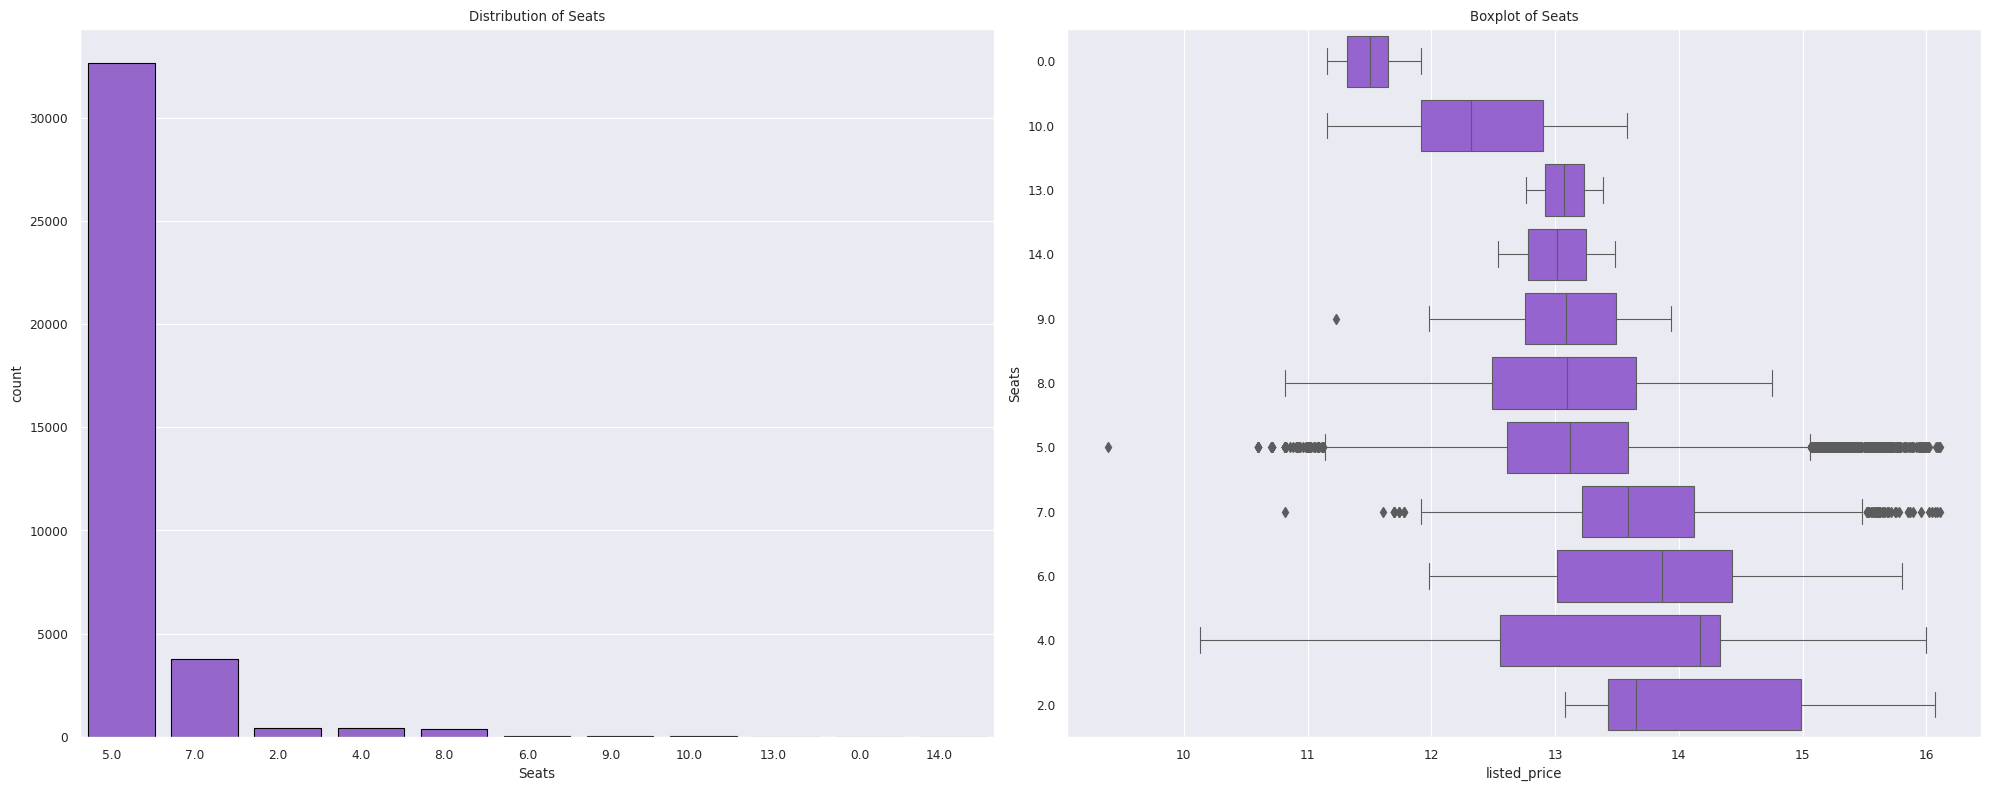

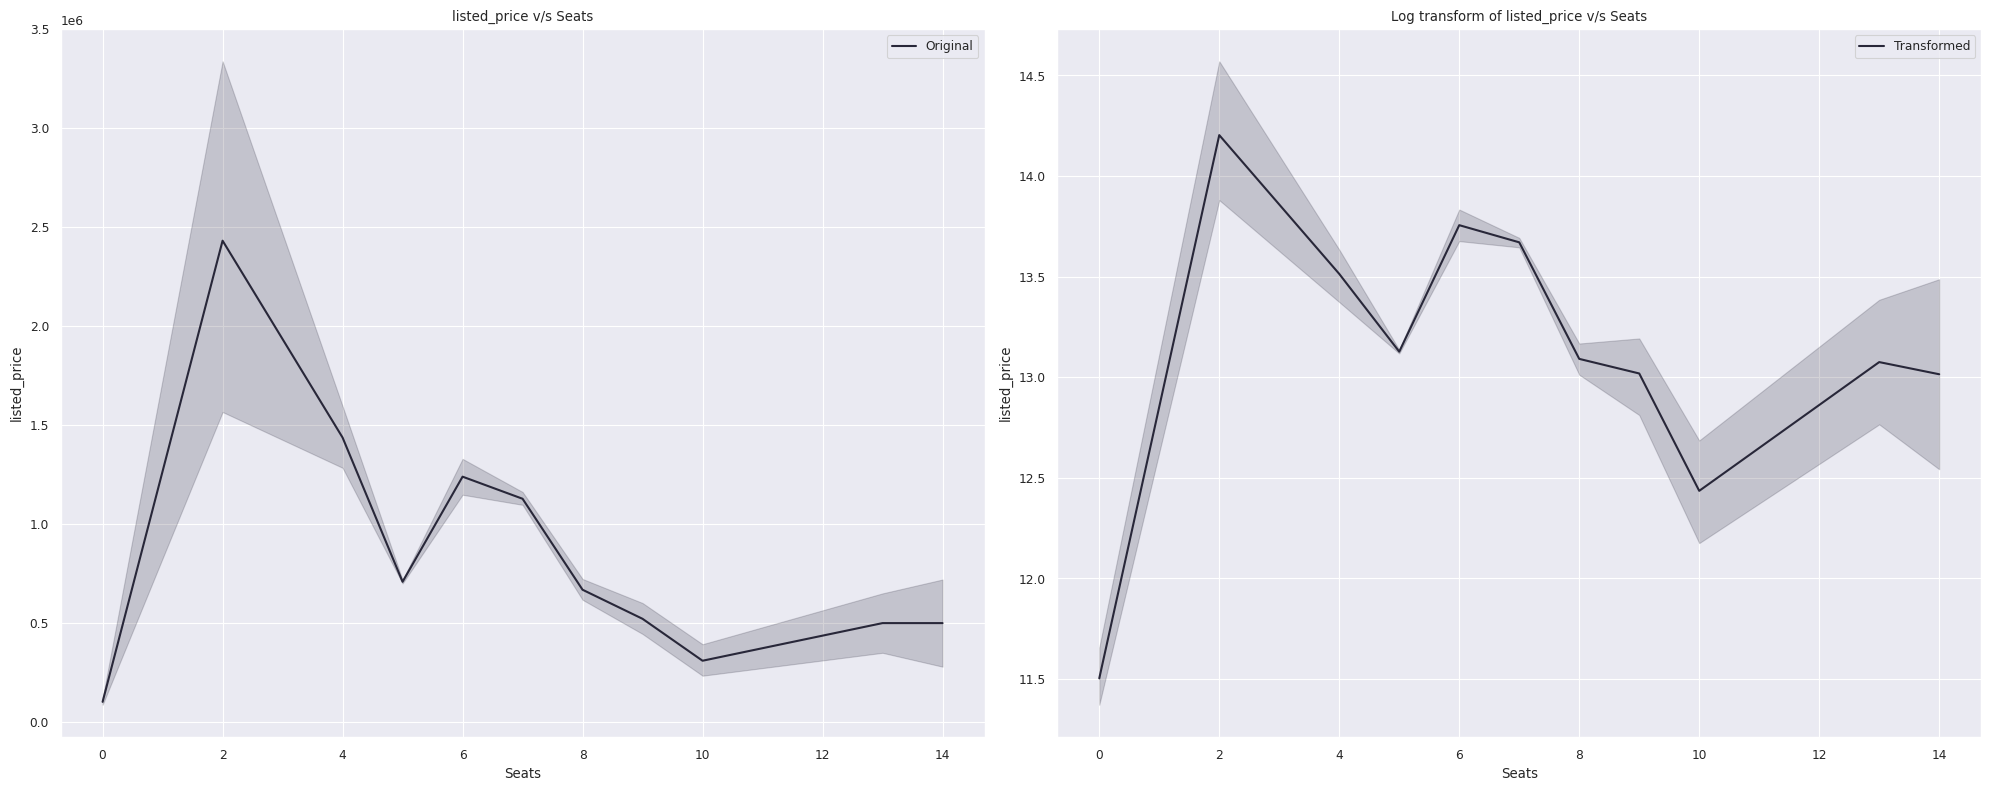

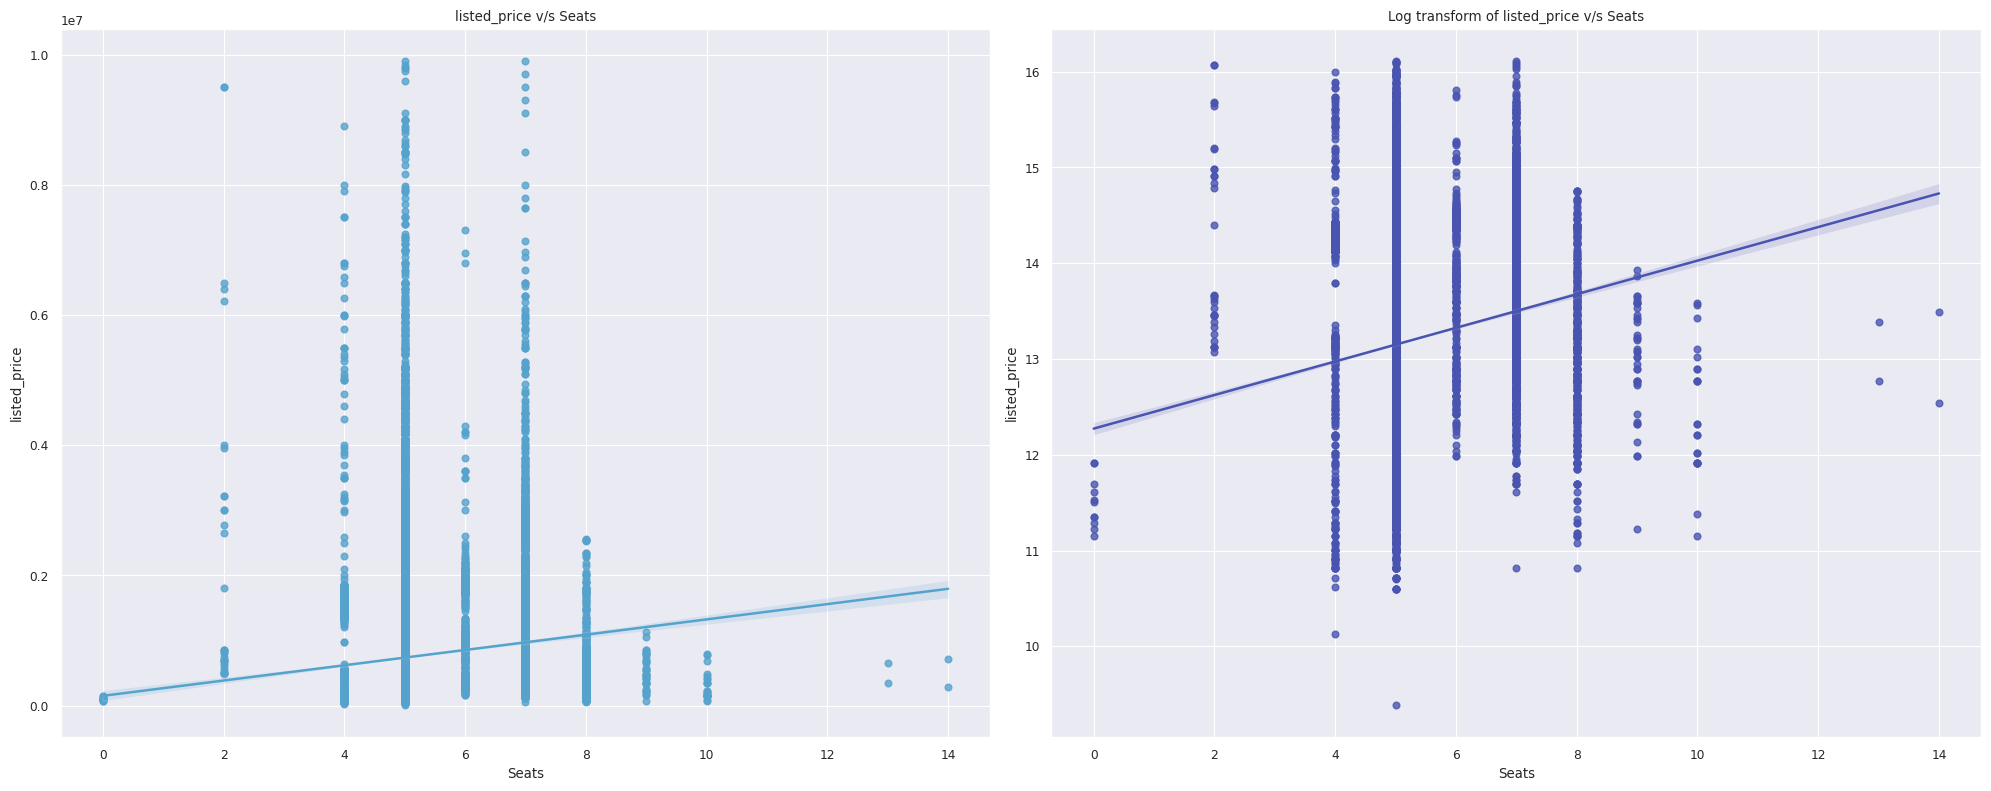

In [9]:
feature_dist_plots(df2, 'Seats', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True, category=True);
target_relation_plots(df2, col='Seats', linewidth = 1.5, fontscale=1, rotation=0, sorted=False, plot='line');
target_relation_plots(df2, col='Seats', fontscale=1, rotation=0, sorted=True, plot='reg', order=1);

### Suggestions 

11 cars reported the number of seats to be zero. It is better to make these rows null.

In [10]:
def Seats_transformation(df: pd.DataFrame):
    """
    Replace the Seats with null if the value is zero
    """
    df.loc[(df['Seats'] == 0), 'Seats'] = np.NaN
    return

suggested_transformations.append(Seats_transformation)

---

### `Steering Type`

In [11]:
analyze_data(df2, 'Steering Type');

Overview of column "Steering Type"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          2           |
|   Distinct %   | 0.005296329643557015 |
| Missing Count  |         805          |
|   Missing %    |  2.1317726815316984  |
+----------------+----------------------+


Column Steering Type is not numeric
Common values for column "Steering Type"
+--------+-------+--------------------+-------------------+
| Value  | Count |     Frequency      |   Mean of Target  |
+--------+-------+--------------------+-------------------+
| power  | 36300 | 98.22225830018671  | 757918.1647658402 |
| manual |  657  | 1.7777416998132964 | 283977.0197869102 |
+--------+-------+--------------------+-------------------+




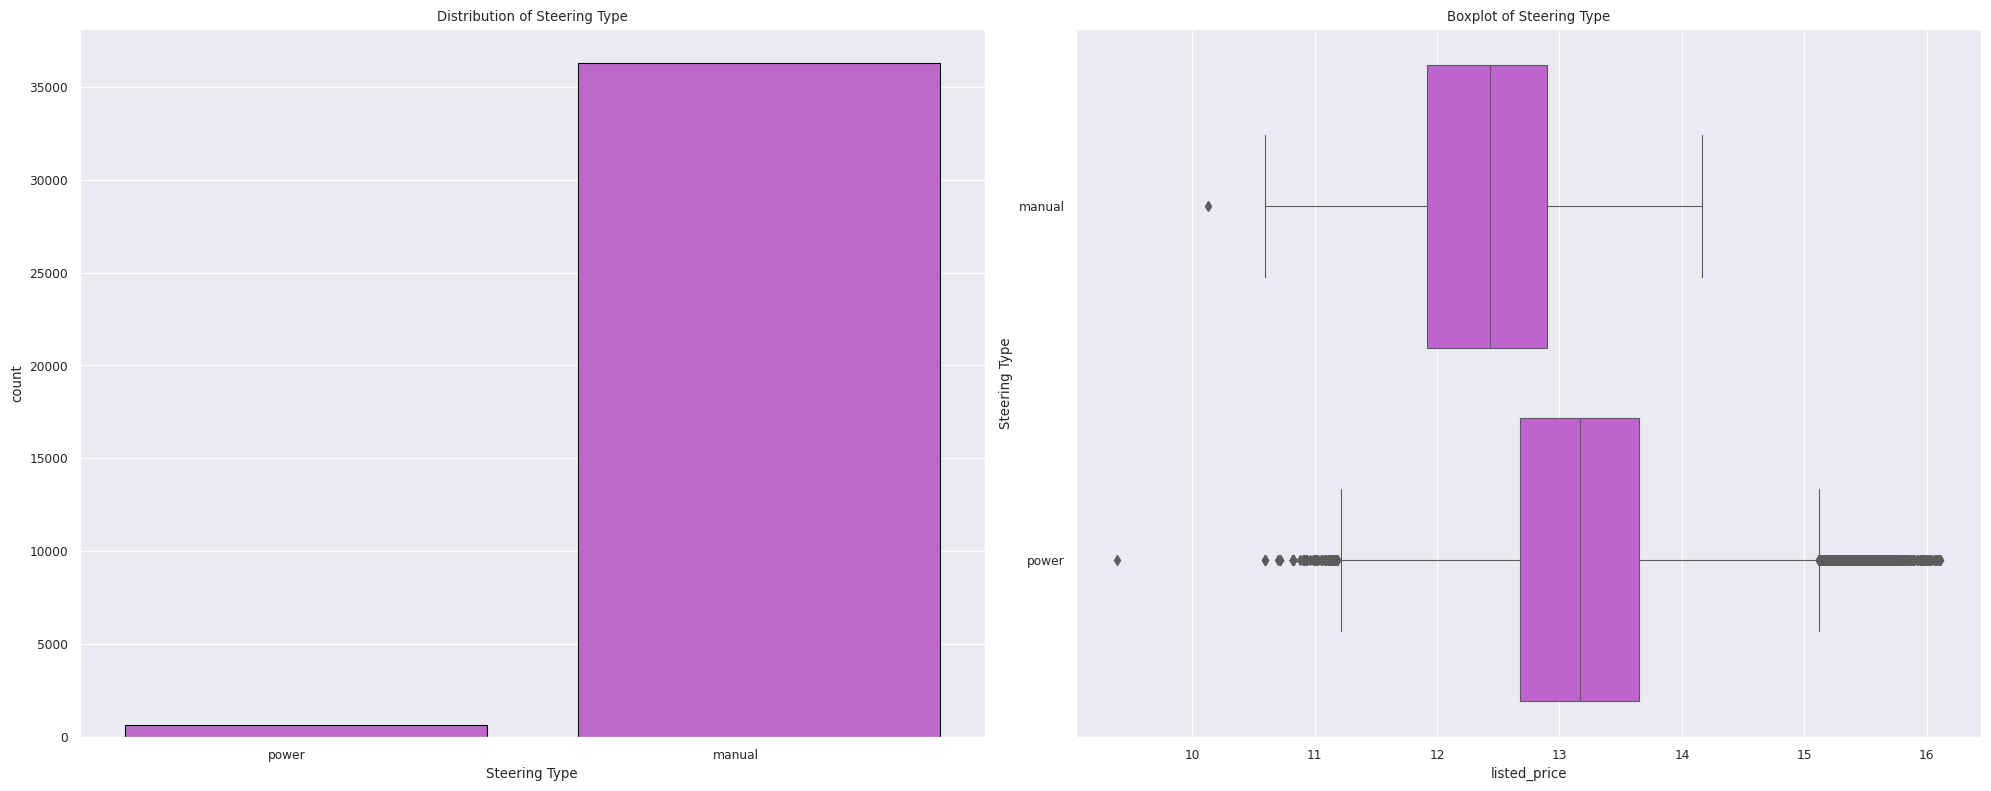

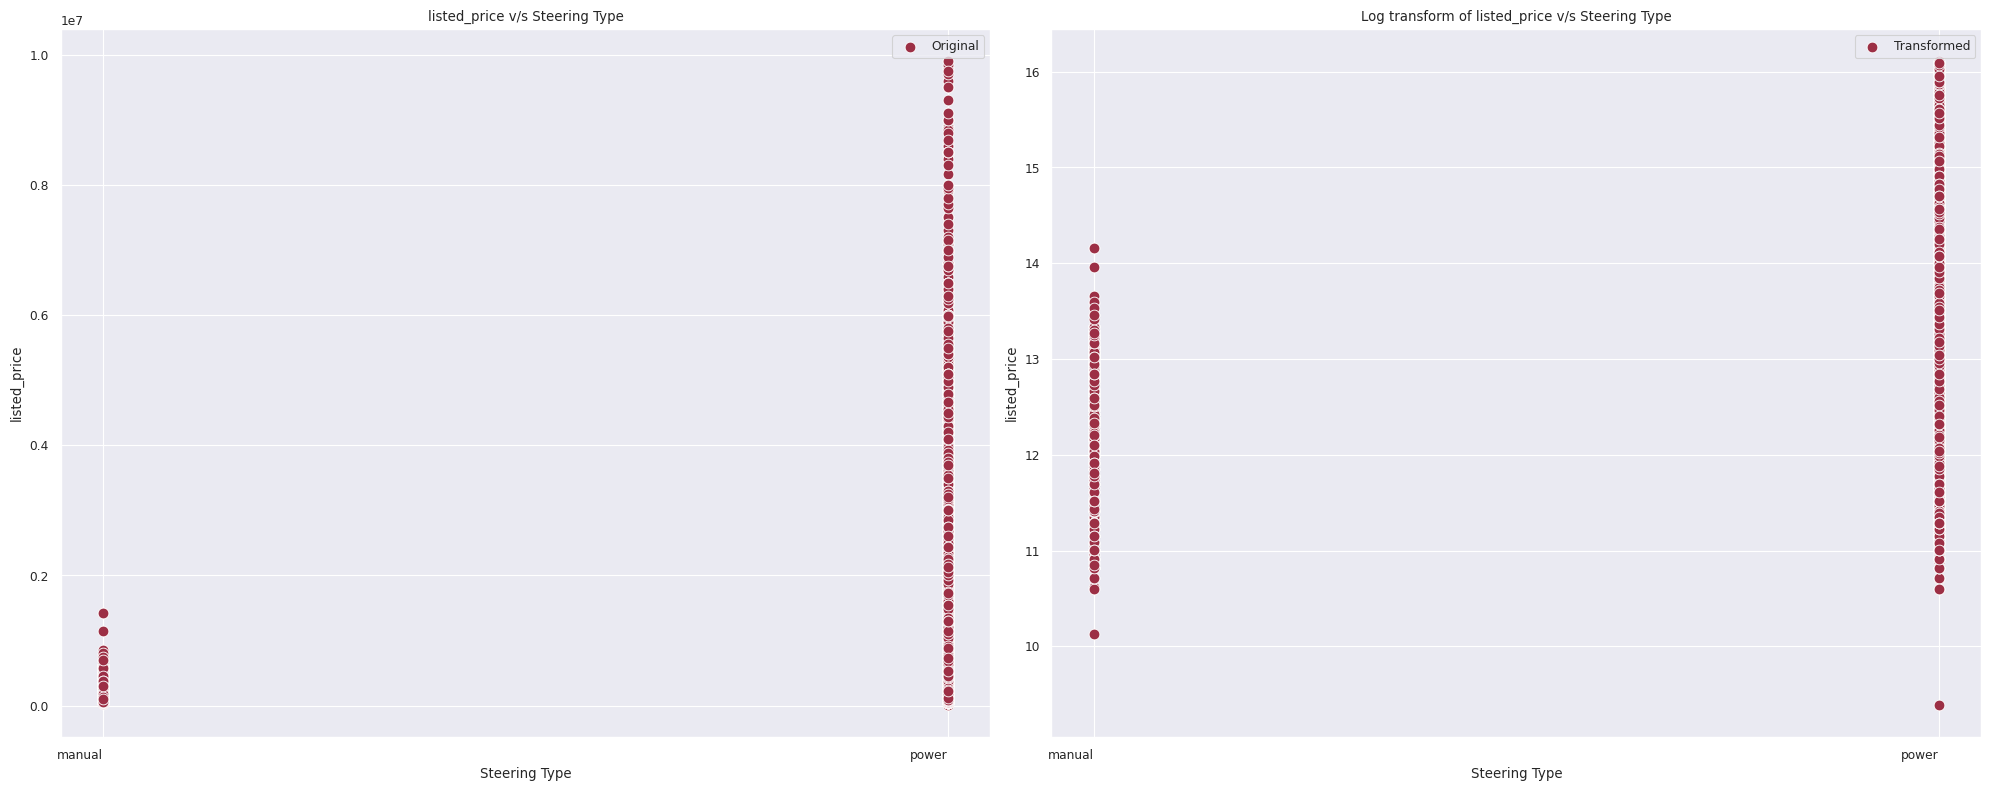

In [12]:
feature_dist_plots(df2, 'Steering Type', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log);
target_relation_plots(df2, col='Steering Type', fontscale=1, rotation=0, plot='scatter', sorted=True, s=60);

---

### `Turning Radius`

In [13]:
analyze_data(df2, 'Turning Radius');

Overview of column "Turning Radius"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          72         |
|   Distinct %   | 0.19066786716805253 |
| Missing Count  |         5817        |
|   Missing %    |  15.404374768285578 |
|      Mean      |  5.493222100485208  |
|    Minimum     |         3.5         |
|    Maximum     |        6250.0       |
+----------------+---------------------+


Quantile stats for column "Turning Radius"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       |  3.5   |
|    5th Percentile   |  4.6   |
|  First Quartile, Q1 |  4.8   |
|        Median       |  5.1   |
|  Third Quartile, Q3 |  5.3   |
|   95th Percentile   |  5.8   |
|       Maximum       | 6250.0 |
|        Range        | 6246.5 |
| Interquartile Range |  0.5   |
+---------------------+--------+


Extremums for column "Turning Radius"

We can see there are 2 cars which have a turning radius greater than 6000(m). Obviously this data is wrongly reported, and we should nullify the data.

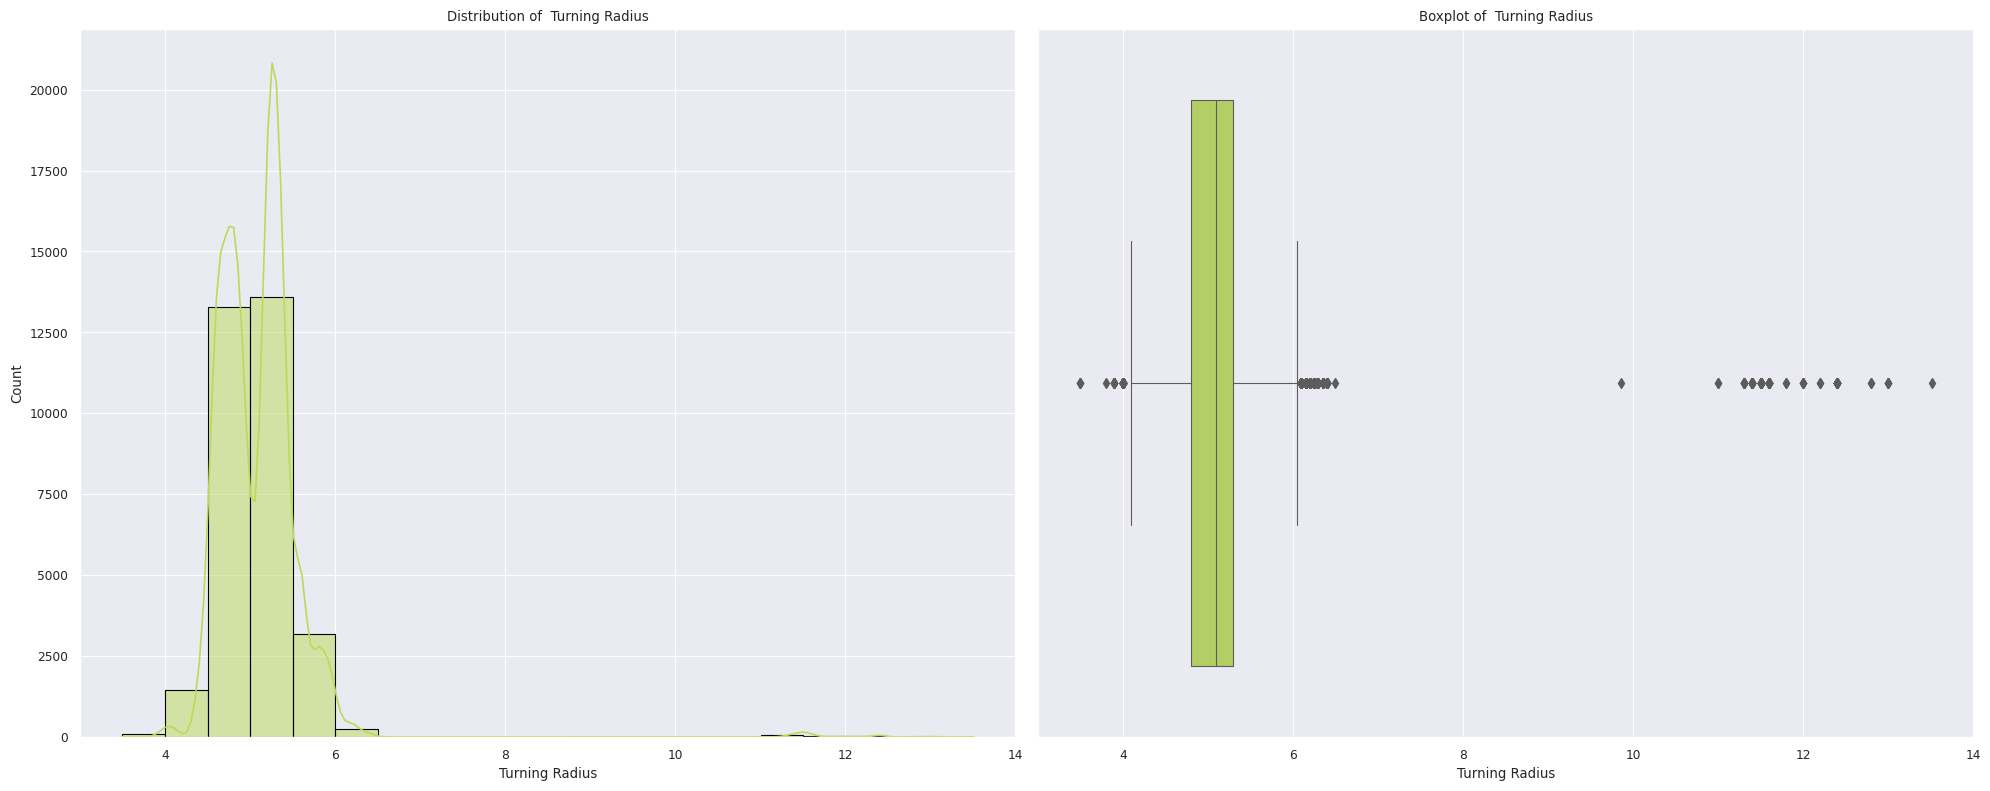

In [14]:
feature_dist_plots(df2[df2['Turning Radius'] < 15], 'Turning Radius', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log);

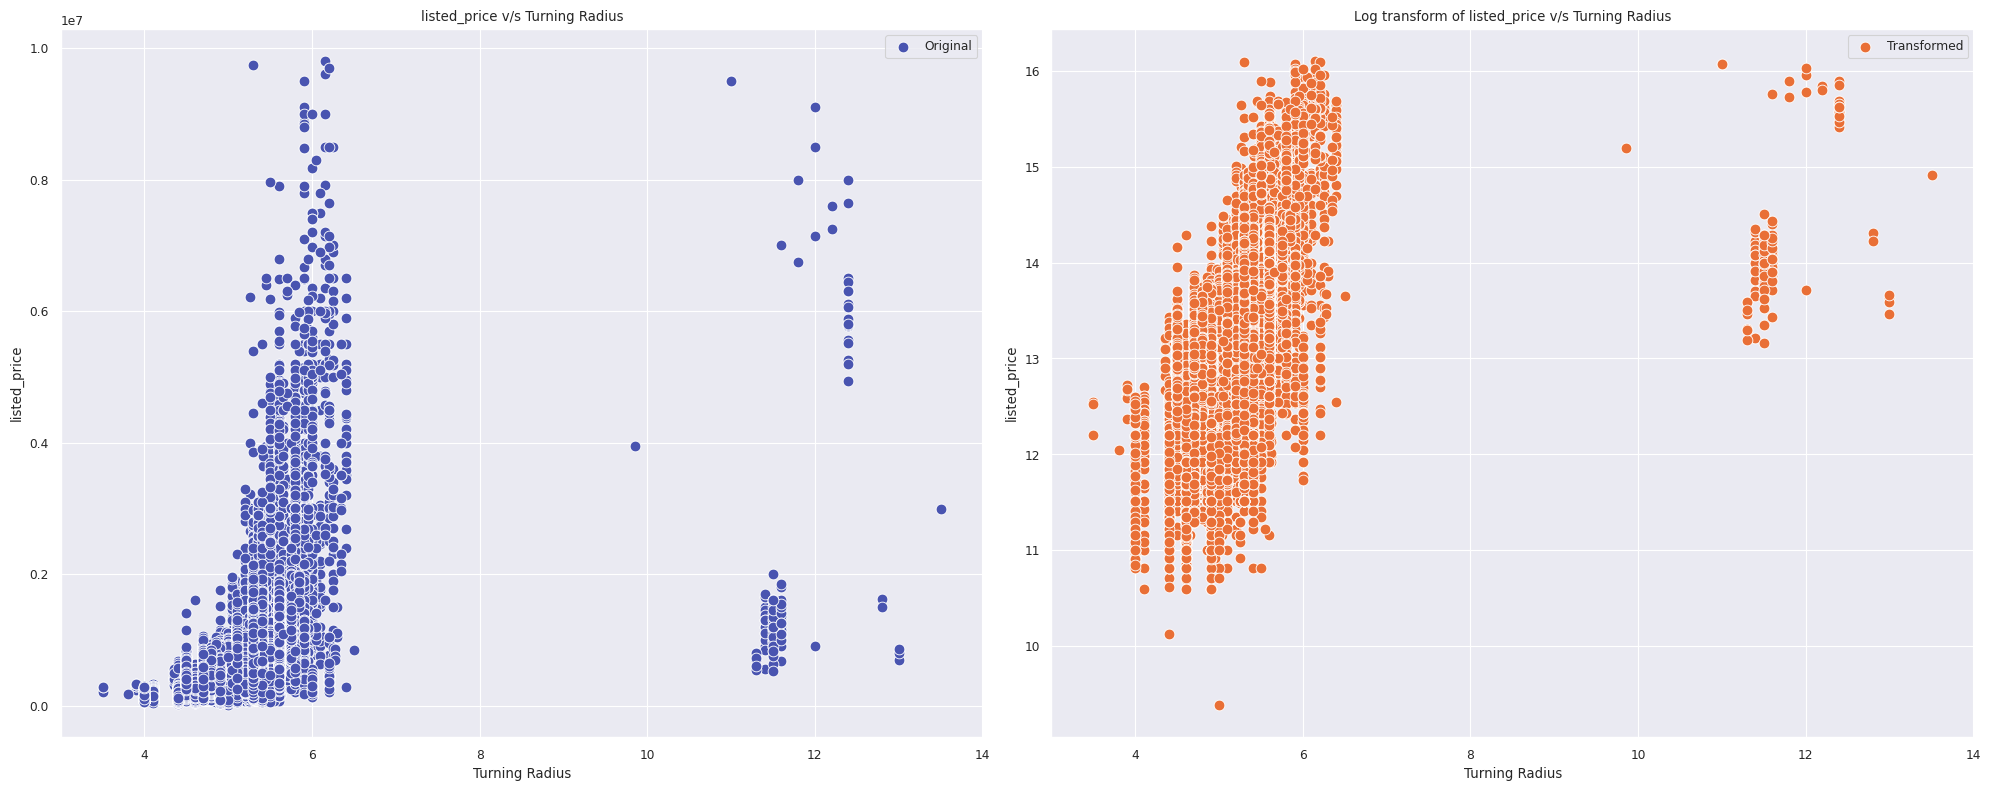

In [15]:
target_relation_plots(df2[df2['Turning Radius'] < 15], col='Turning Radius', fontscale=1, rotation=0, plot='scatter', sorted=True, s=60);

### Suggestions

1. We have to hanlde the turning radius which are greter than, say 15m. One way would be to clip the values with a maximum and minimum range. But a better approach would be to straight away make those values null and impute them using some imputation technique.

In [16]:
def TurningRadius_transformation(df: pd.DataFrame):
    """
    Replace the Turning Radius with null if the value is greater and 15
    """
    df.loc[(df['Turning Radius'] > 15.0), 'Turning Radius'] = np.NaN
    return

suggested_transformations.append(TurningRadius_transformation)

---

### `Front Brake Type` and `Rear Brake Type`

In [17]:
analyze_data(df2, 'Front Brake Type');

Overview of column "Front Brake Type"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          5           |
|   Distinct %   | 0.013240824108892536 |
| Missing Count  |         318          |
|   Missing %    |  0.8421164133255653  |
+----------------+----------------------+


Column Front Brake Type is not numeric
Common values for column "Front Brake Type"
+-----------------+-------+---------------------+--------------------+
|      Value      | Count |      Frequency      |   Mean of Target   |
+-----------------+-------+---------------------+--------------------+
|       disc      | 23312 |  62.258305736566605 | 813068.2304392587  |
| ventilated disc | 13744 |  36.70548018374105  | 692004.8796565774  |
|     caliper     |  308  |  0.8225616921269095 |  592128.435064935  |
|       drum      |   70  | 0.18694583911975216 | 145797.67142857143 |
|   disc & drum   |   10  | 0.02670654844567

In [18]:
analyze_data(df2, 'Rear Brake Type');

Overview of column "Rear Brake Type"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          5           |
|   Distinct %   | 0.013240824108892536 |
| Missing Count  |         317          |
|   Missing %    |  0.8394682485037868  |
+----------------+----------------------+


Column Rear Brake Type is not numeric
Common values for column "Rear Brake Type"
+-----------------+-------+---------------------+--------------------+
|      Value      | Count |      Frequency      |   Mean of Target   |
+-----------------+-------+---------------------+--------------------+
|       drum      | 29969 |  80.03471758579249  | 539053.6581133838  |
|       disc      |  6174 |  16.488182667912938 | 1606745.6218011014 |
| ventilated disc |  930  |  2.4836426759246897 | 2568083.4924731185 |
|     caliper     |  308  |  0.8225397249298971 |  592128.435064935  |
|   disc & drum   |   64  | 0.17091734543997864

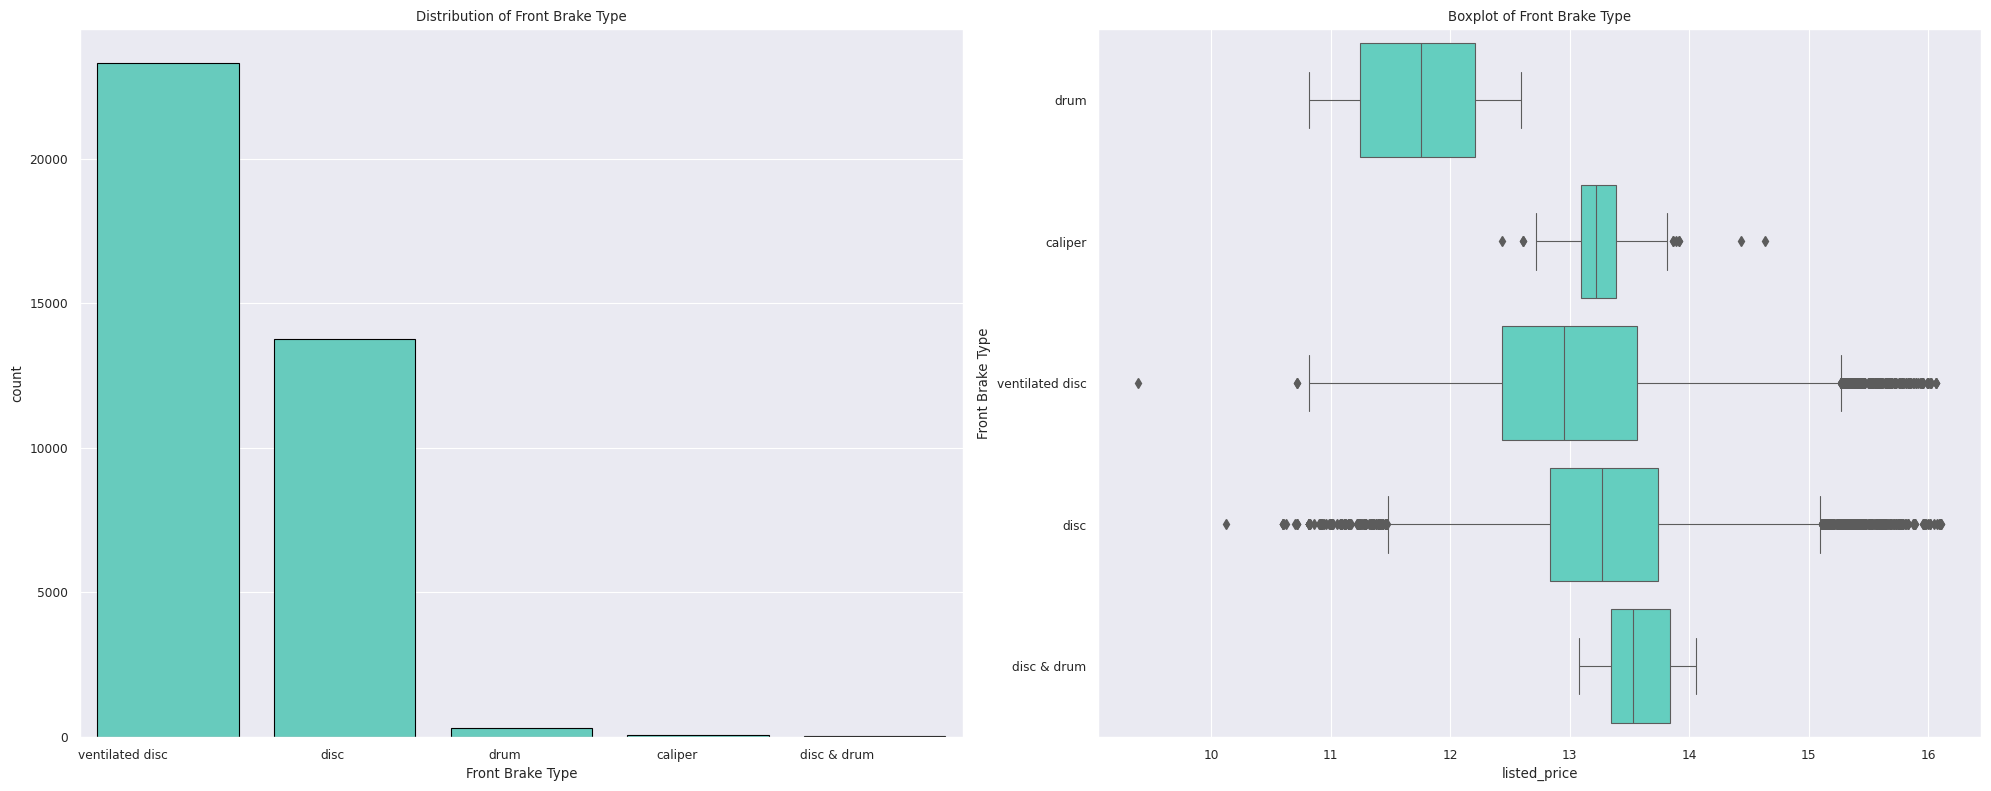

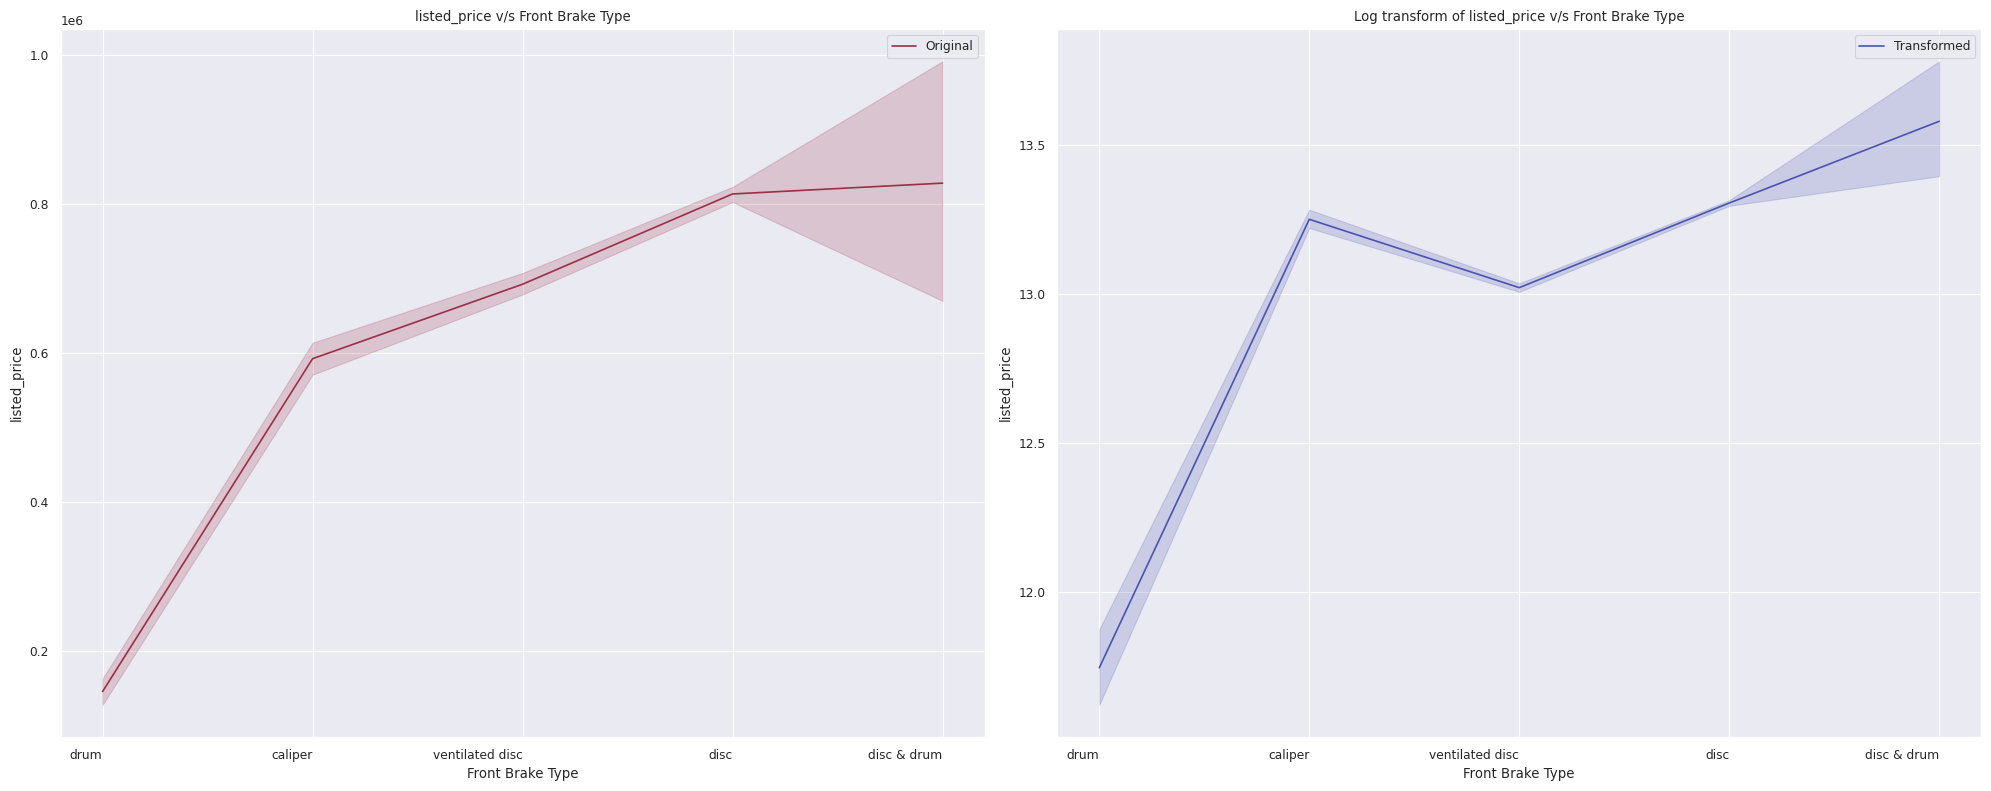

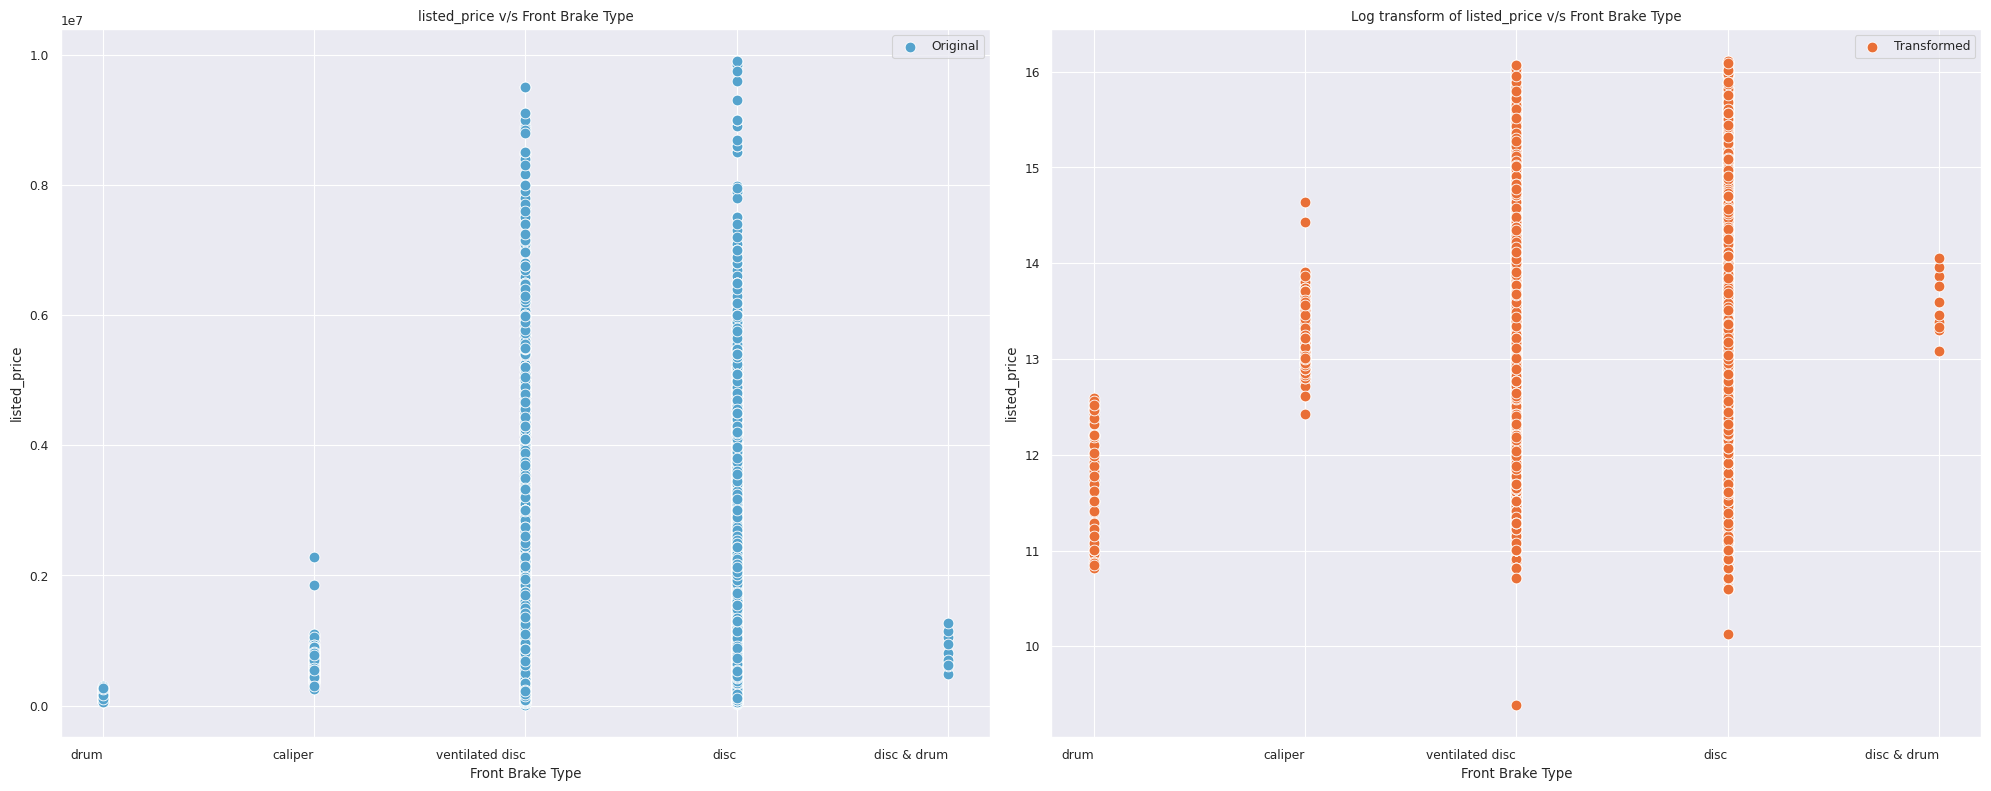

In [19]:
feature_dist_plots(df2, 'Front Brake Type', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Front Brake Type', fontscale=1, rotation=0, plot='line', sorted=True);
target_relation_plots(df2, col='Front Brake Type', fontscale=1, rotation=0, plot='scatter', sorted=True, s=60);

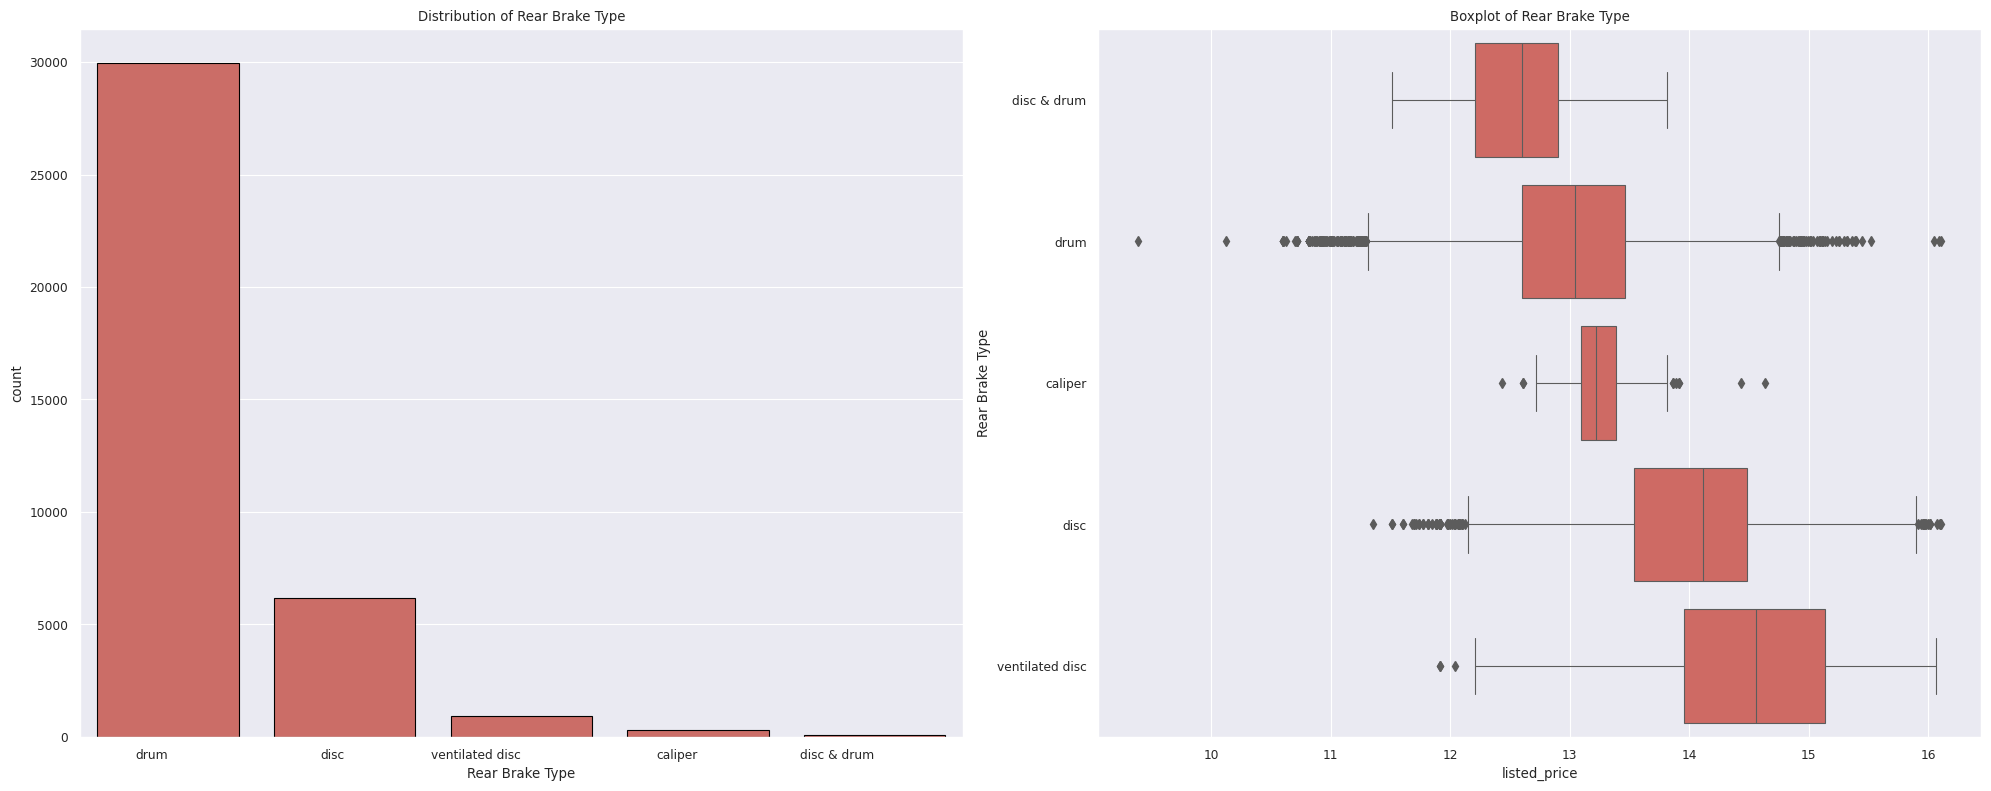

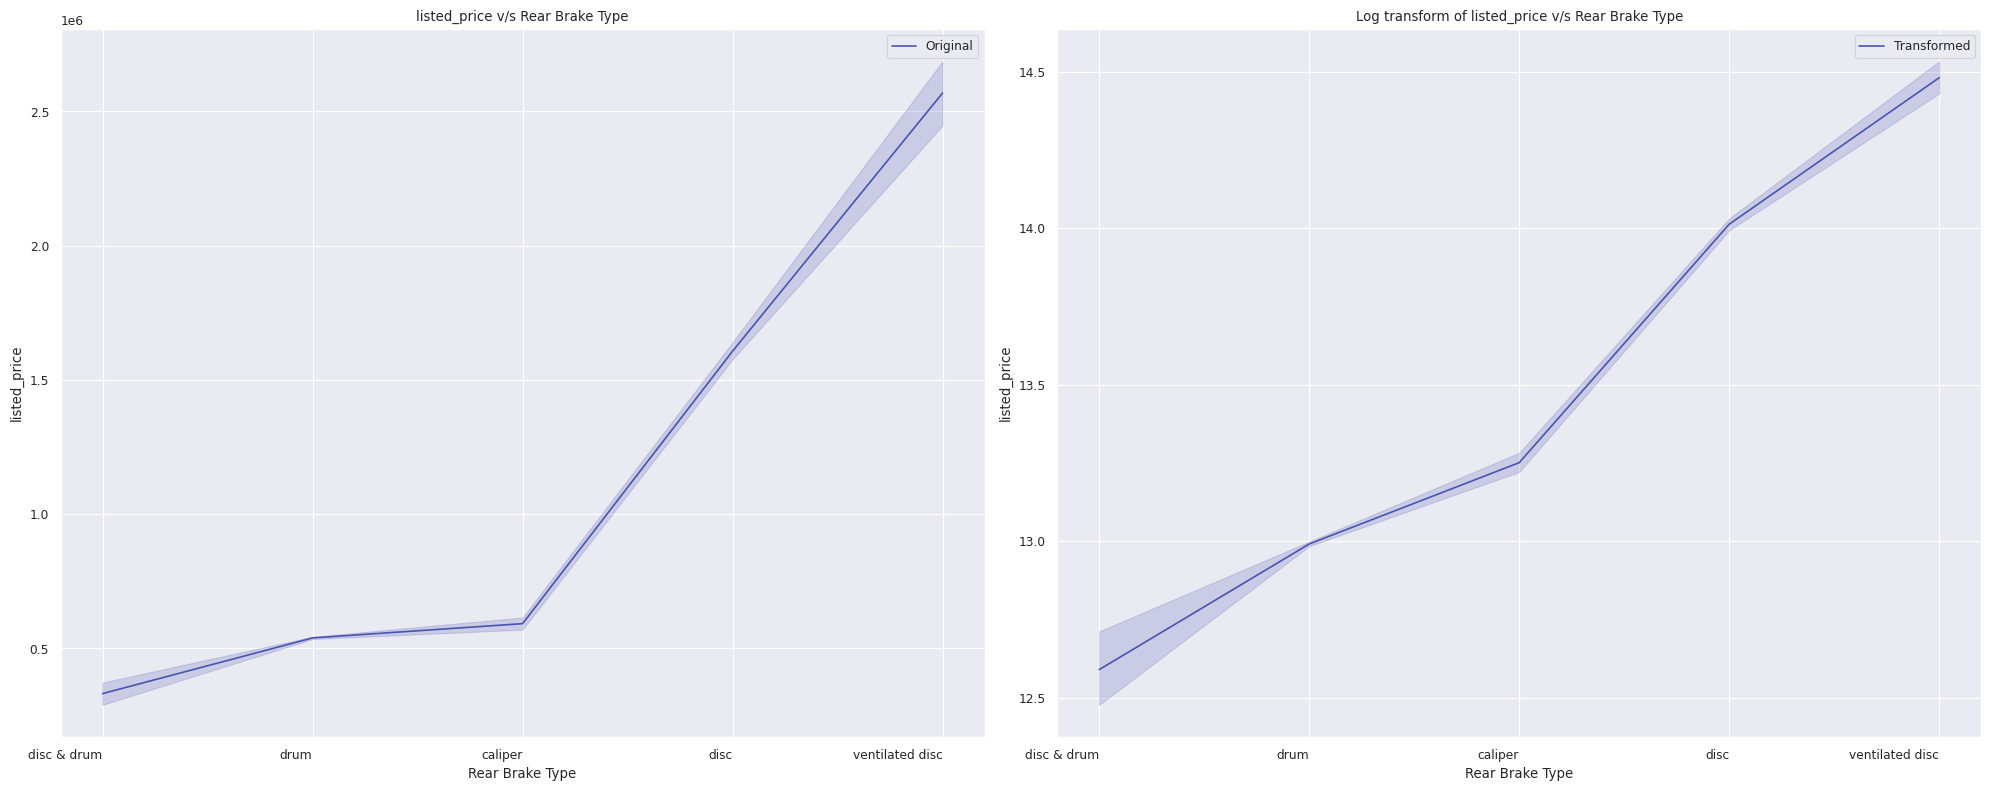

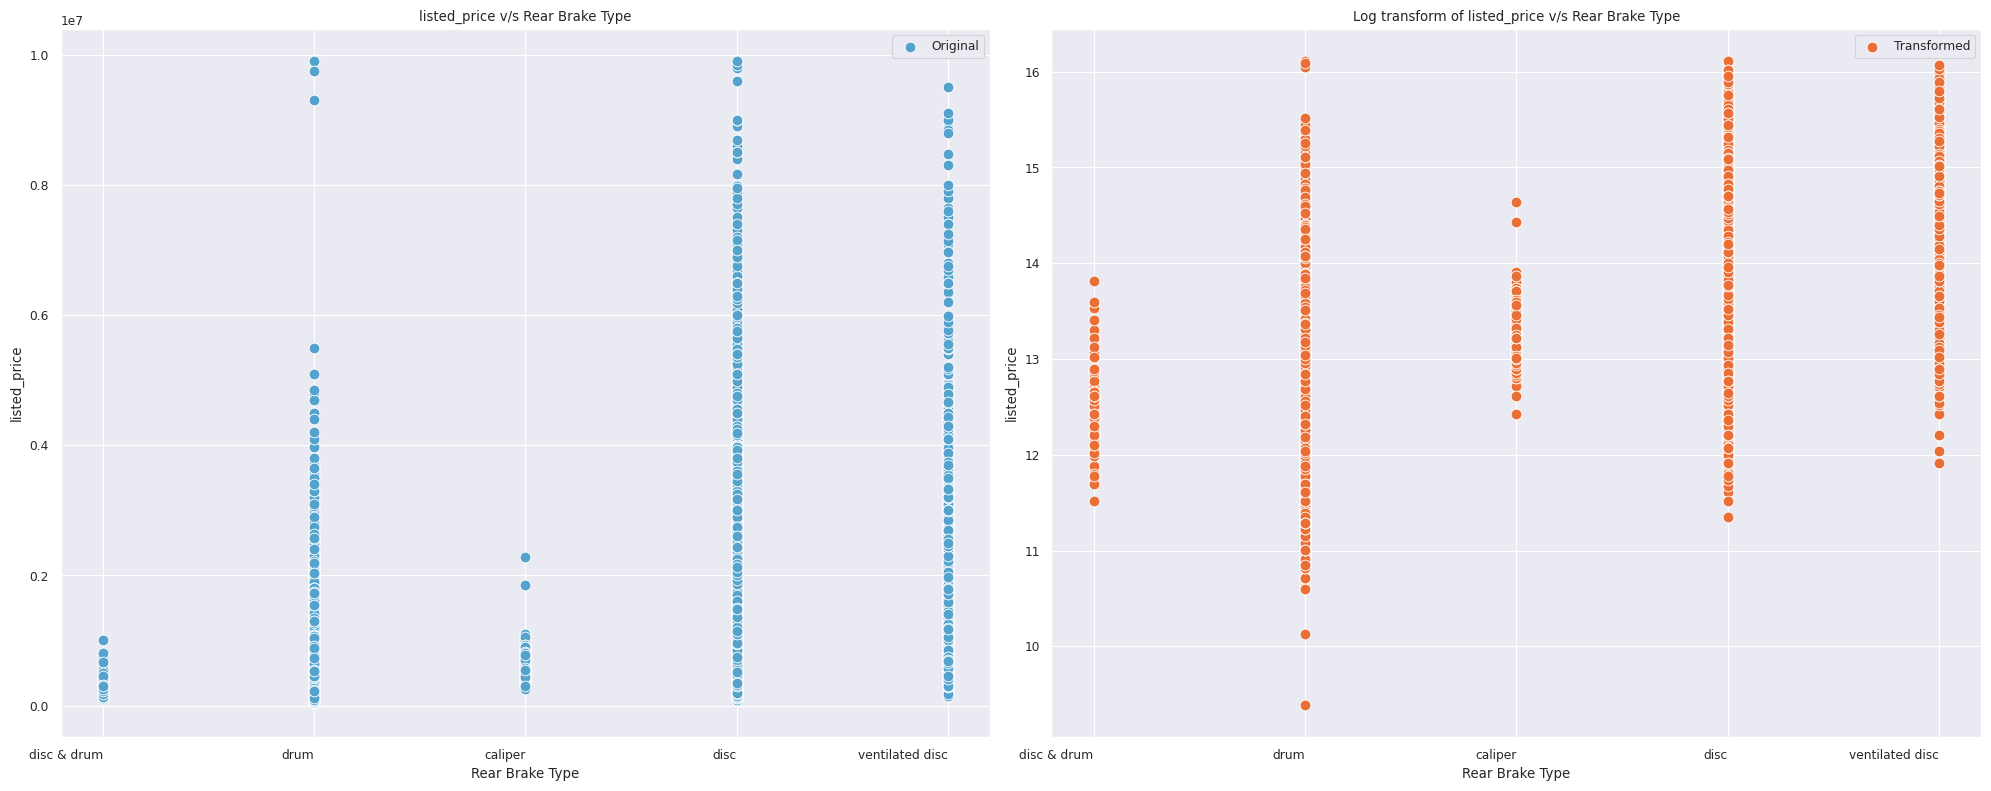

In [20]:
feature_dist_plots(df2, 'Rear Brake Type', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Rear Brake Type', fontscale=1, rotation=0, plot='line', sorted=True);
target_relation_plots(df2, col='Rear Brake Type', fontscale=1, rotation=0, plot='scatter', sorted=True, s=60);

In [21]:
chi2_test(df, 'Front Brake Type', 'Rear Brake Type');

Null Hypothesis: There is no correlation between the columns 'Front Brake Type' and 'Rear Brake Type'
+-------------------+--------------------------------------------------------------------+--------+-----+
|        Chi2       |                           Expected Freq.                           | pvalue | dof |
+-------------------+--------------------------------------------------------------------+--------+-----+
| 77245.75474125879 | [[2.580000e+00 1.000000e-02 5.156000e+01 5.300000e-01 2.494600e+02 |  0.0   |  25 |
|                   |                            7.860000e+00]                           |        |     |
|                   |  [1.000000e-02 0.000000e+00 1.700000e-01 0.000000e+00 8.000000e-01 |        |     |
|                   |                            3.000000e-02]                           |        |     |
|                   |  [1.929700e+02 6.200000e-01 3.856220e+03 3.984000e+01 1.865674e+04 |        |     |
|                   |                            5

### Suggestions

1. As we can see from the chi2 test, that the degree of association is quite hight between the 2 columns. It would be benificial to drop one of them for interpretablity, but here we decide to keep them since it won't harm the performance of the model

---
### `Top Speed` and `Acceleration`

In [22]:
analyze_data(df2, 'Top Speed');

Overview of column "Top Speed"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |         185         |
|   Distinct %   | 0.48991049202902387 |
| Missing Count  |        15342        |
|   Missing %    |  40.62814469572586  |
|      Mean      |  172.8541962533452  |
|    Minimum     |         70.0        |
|    Maximum     |        312.0        |
+----------------+---------------------+


Quantile stats for column "Top Speed"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  70.0 |
|    5th Percentile   | 137.0 |
|  First Quartile, Q1 | 156.0 |
|        Median       | 168.0 |
|  Third Quartile, Q3 | 188.0 |
|   95th Percentile   | 228.0 |
|       Maximum       | 312.0 |
|        Range        | 242.0 |
| Interquartile Range |  32.0 |
+---------------------+-------+


Extremums for column "Top Speed"
Maximum 5 values
+-------+-

In [23]:
analyze_data(df2, 'Acceleration');

Overview of column "Acceleration"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        240         |
|   Distinct %   | 0.6355595572268418 |
| Missing Count  |       13985        |
|   Missing %    | 37.03458503257242  |
|      Mean      | 13.147450897926568 |
|    Minimum     |        4.1         |
|    Maximum     |       44.04        |
+----------------+--------------------+


Quantile stats for column "Acceleration"
+---------------------+-------------------+
|      Statistic      |       Value       |
+---------------------+-------------------+
|       Minimum       |        4.1        |
|    5th Percentile   |        7.8        |
|  First Quartile, Q1 |       11.14       |
|        Median       |        13.2       |
|  Third Quartile, Q3 |       14.85       |
|   95th Percentile   |        18.6       |
|       Maximum       |       44.04       |
|        Range        |       39.94       |

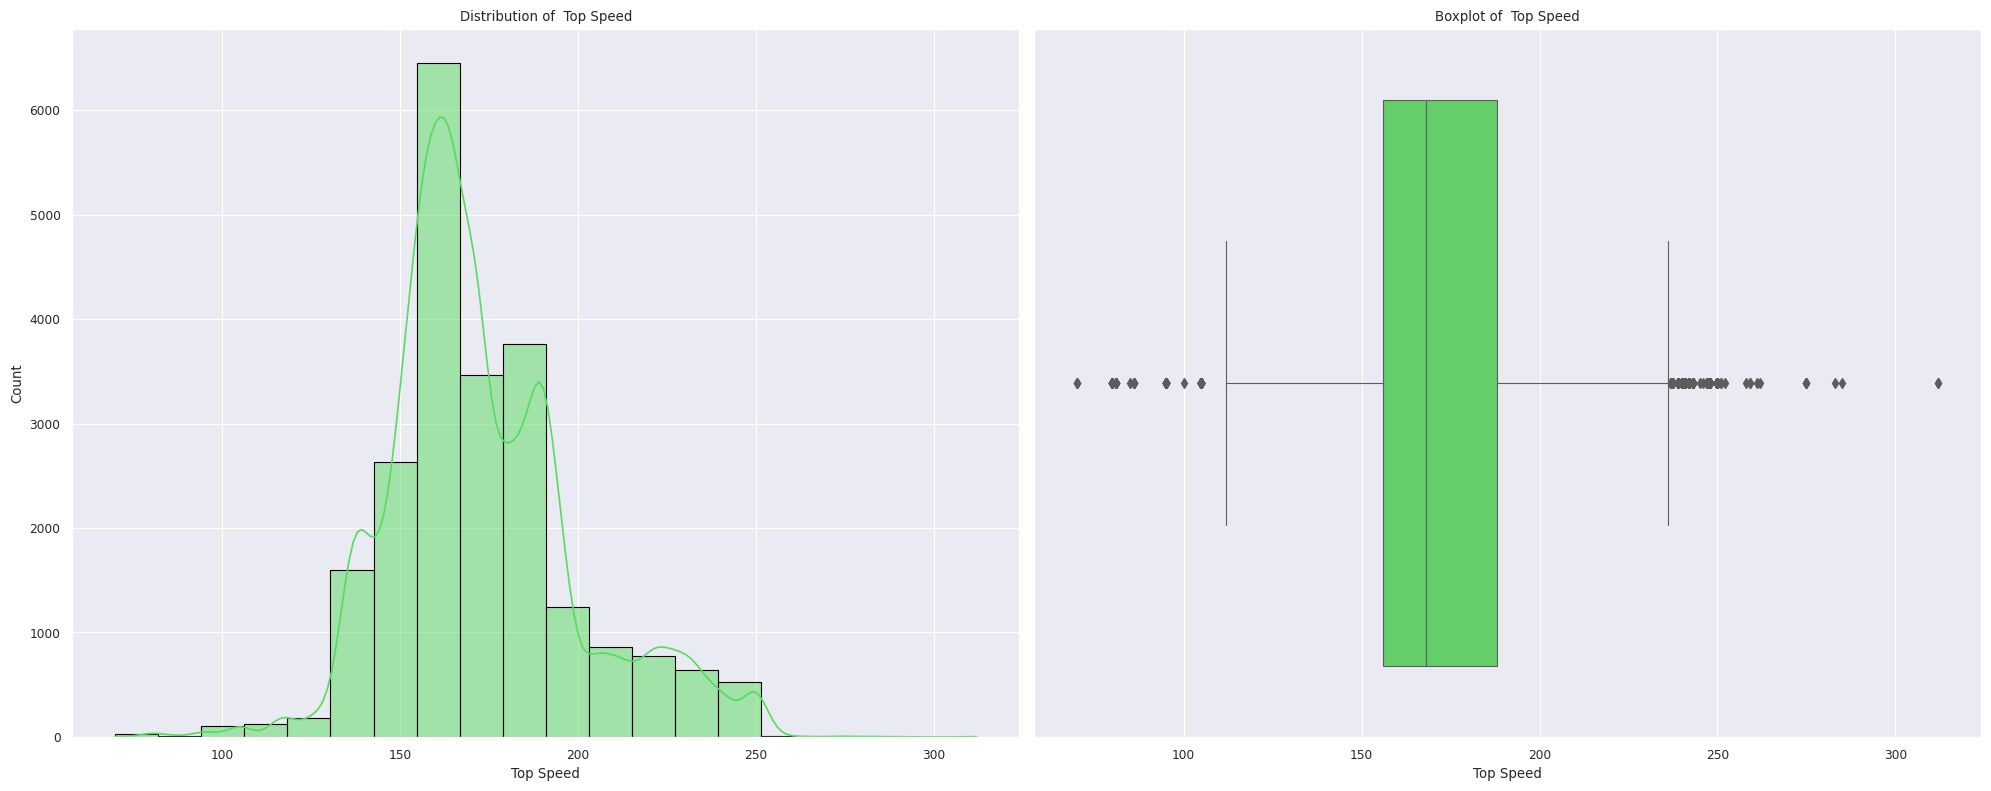

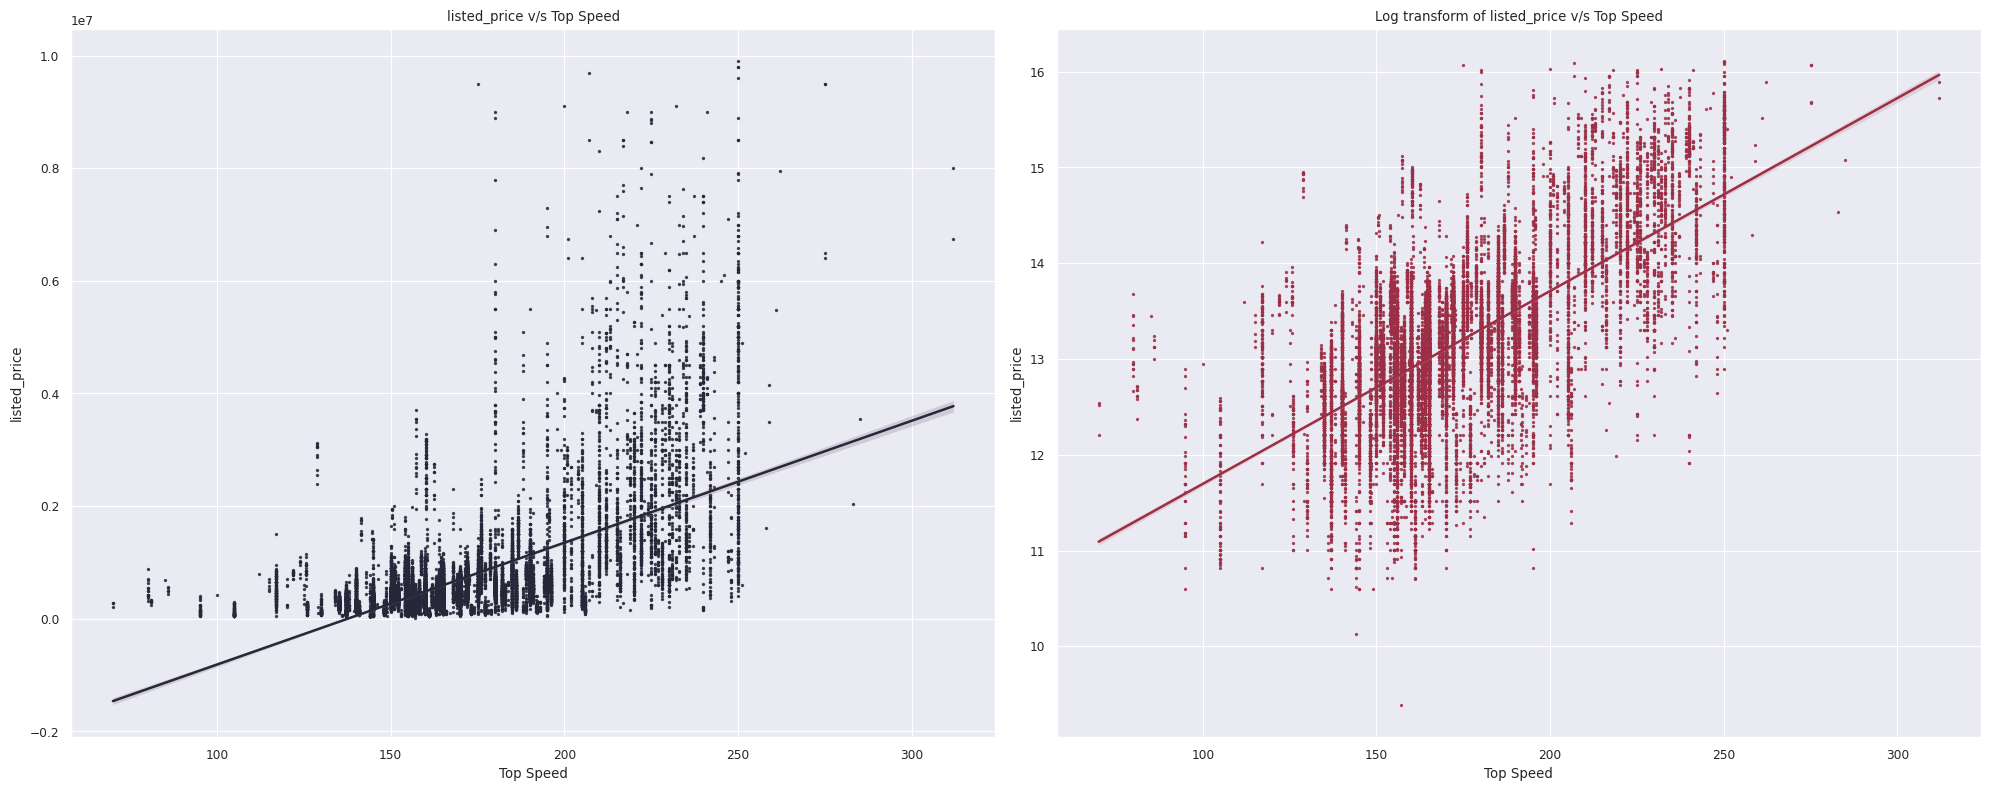

In [24]:
feature_dist_plots(df2, col='Top Speed', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Top Speed', fontscale=1, rotation=0, plot='reg', scatter_kws={'s':2});

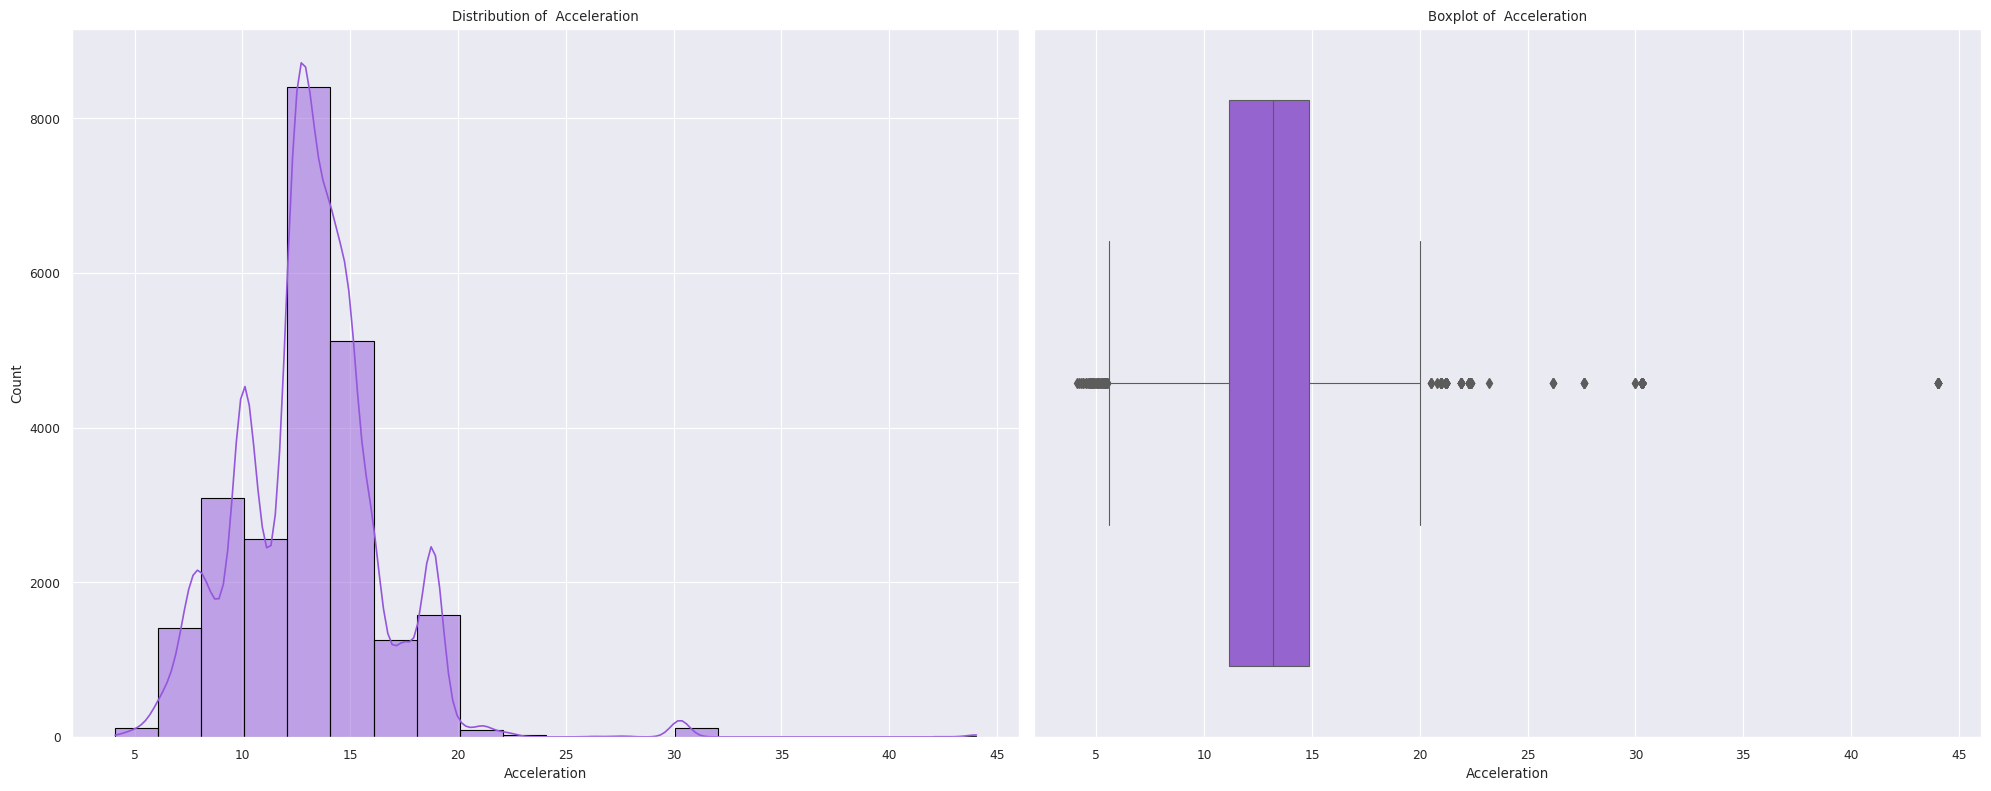

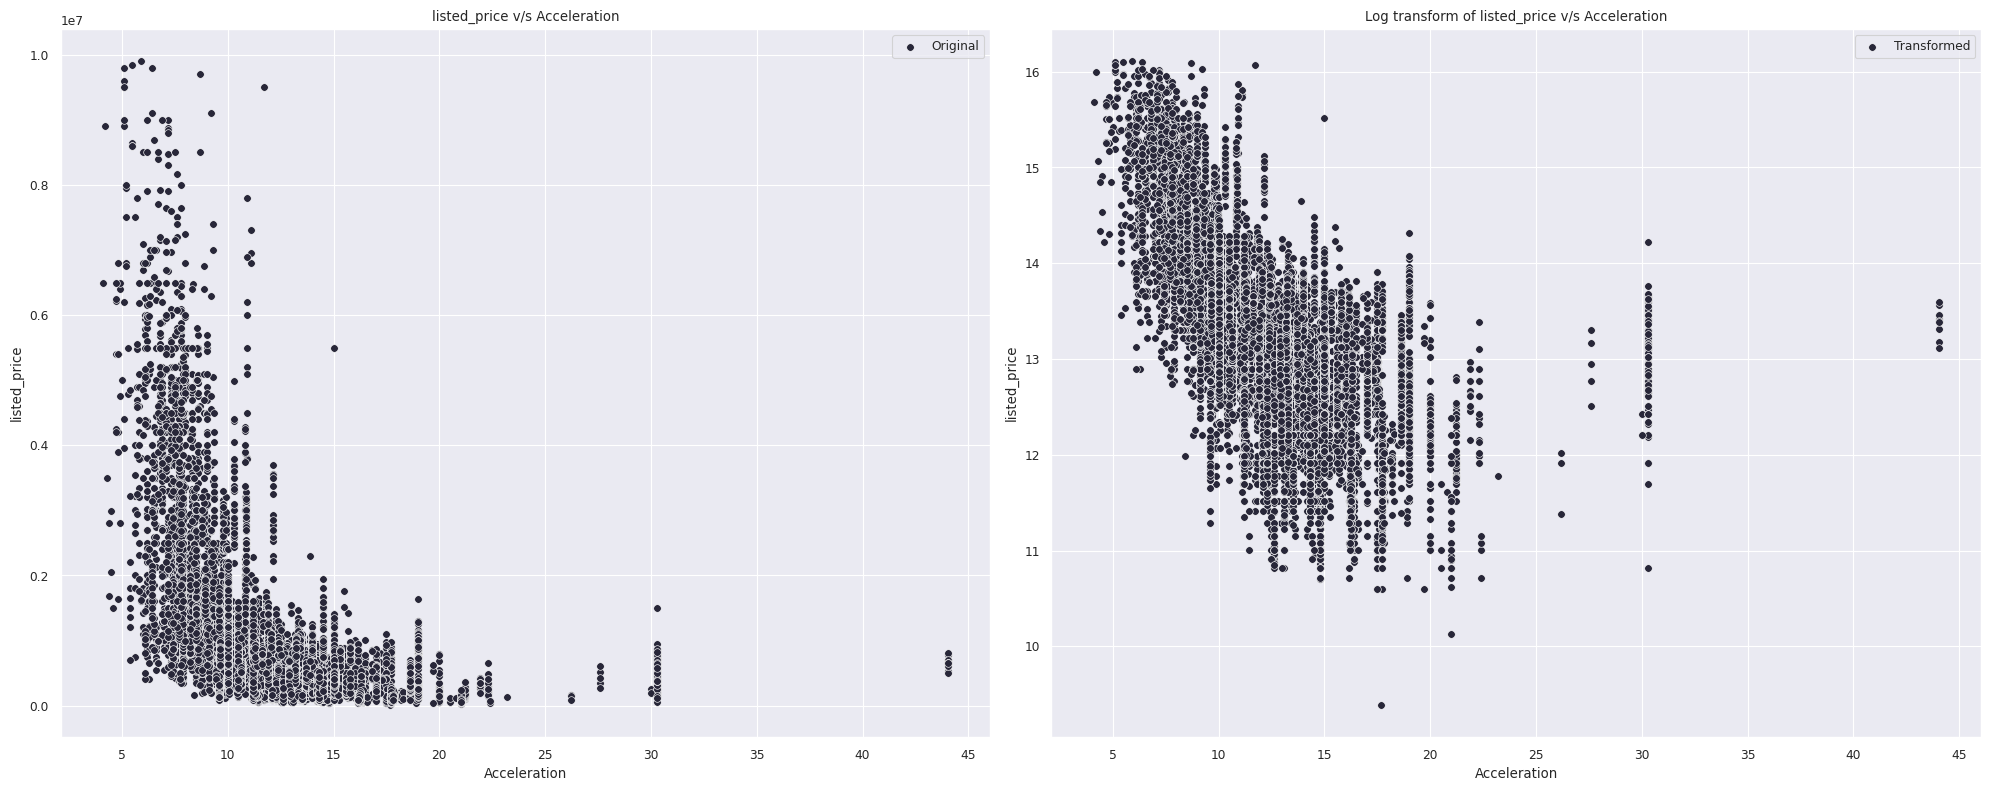

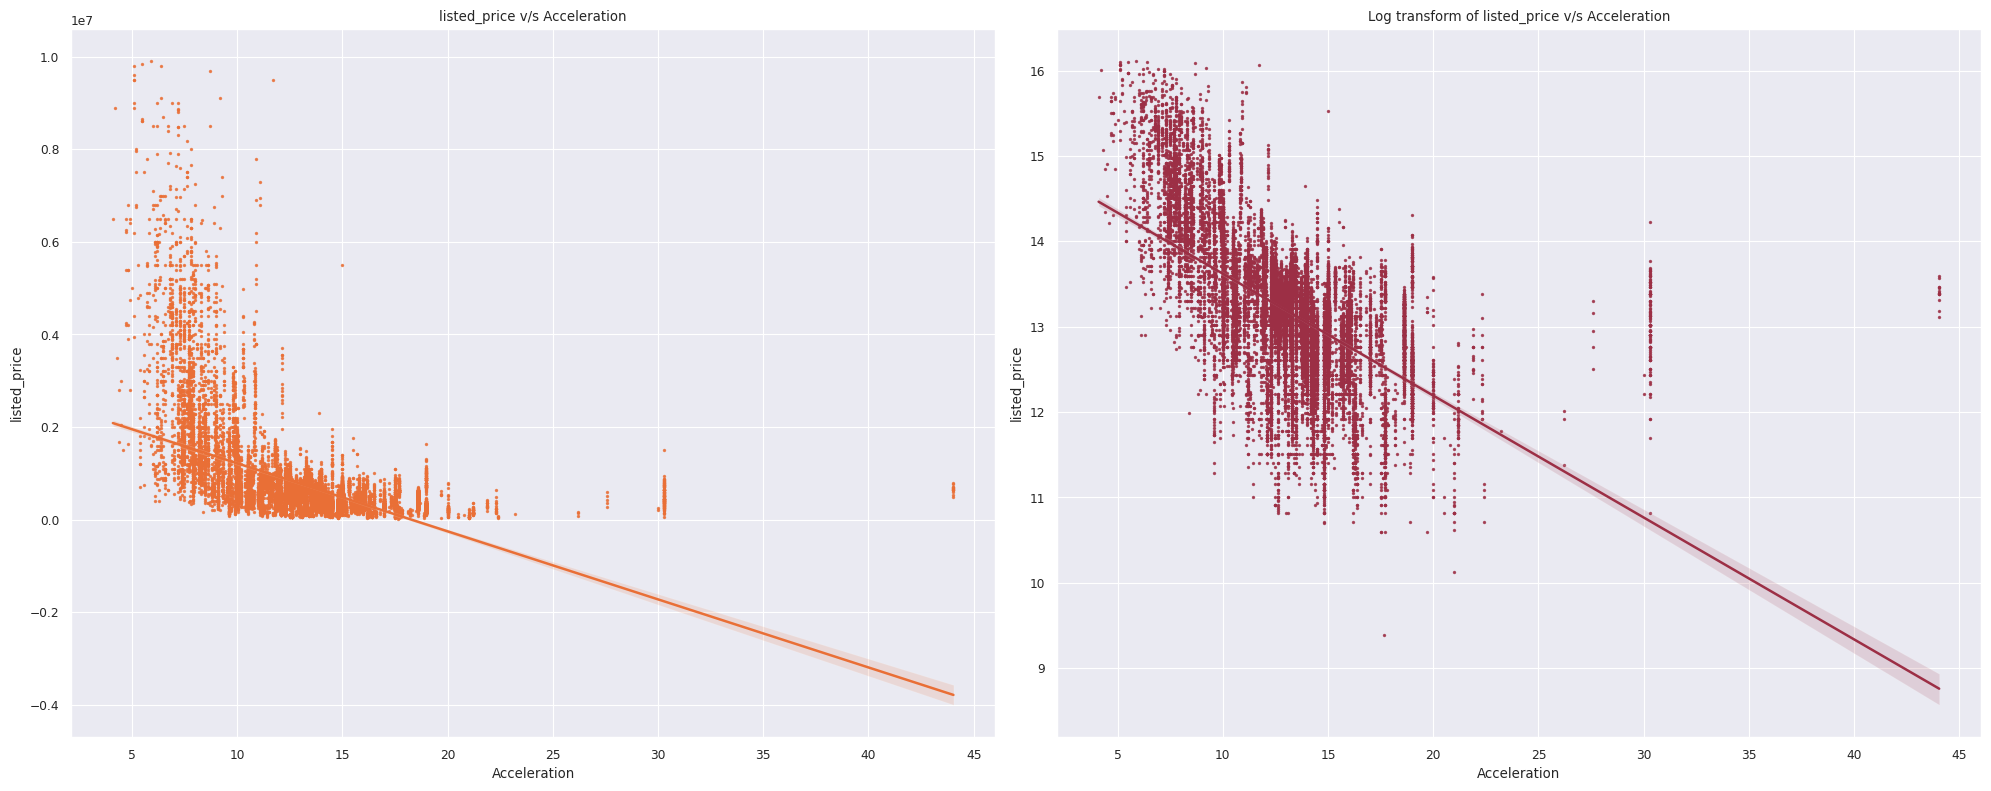

In [25]:
feature_dist_plots(df2, col='Acceleration', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Acceleration', fontscale=1, rotation=0, plot='scatter', s=30);
target_relation_plots(df2, col='Acceleration', fontscale=1, rotation=0, plot='reg', scatter_kws={'s':2});

---

### `Tyre Type`


In [26]:
analyze_data(df2, 'Tyre Type');

Overview of column "Tyre Type"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          4          |
|   Distinct %   | 0.01059265928711403 |
| Missing Count  |         255         |
|   Missing %    |  0.6752820295535195 |
+----------------+---------------------+


Column Tyre Type is not numeric
Common values for column "Tyre Type"
+-----------------+-------+----------------------+-------------------+
|      Value      | Count |      Frequency       |   Mean of Target  |
+-----------------+-------+----------------------+-------------------+
| tubeless radial | 29070 |  77.50553230063721   | 788887.4766081871 |
|     tubeless    |  8183 |  21.81726077798811   | 577987.5174141513 |
|     runflat     |  250  |  0.6665422454475165  |     3934205.28    |
|       tube      |   4   | 0.010664675927160264 |      787500.0     |
+-----------------+-------+----------------------+-------------------+




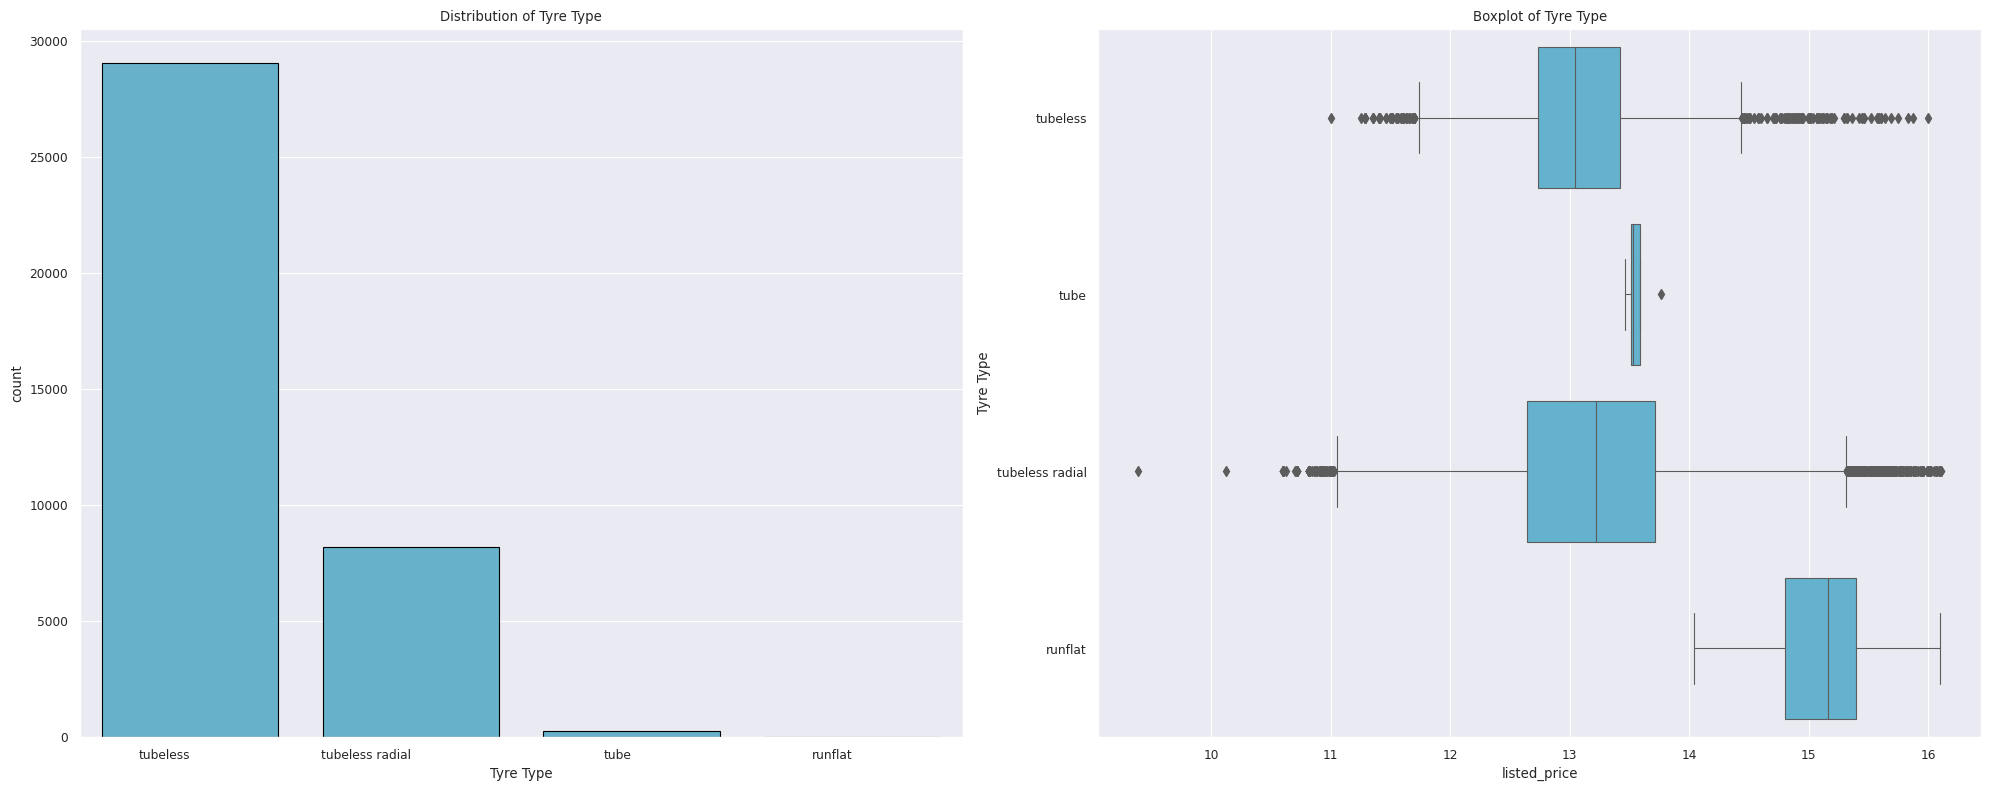

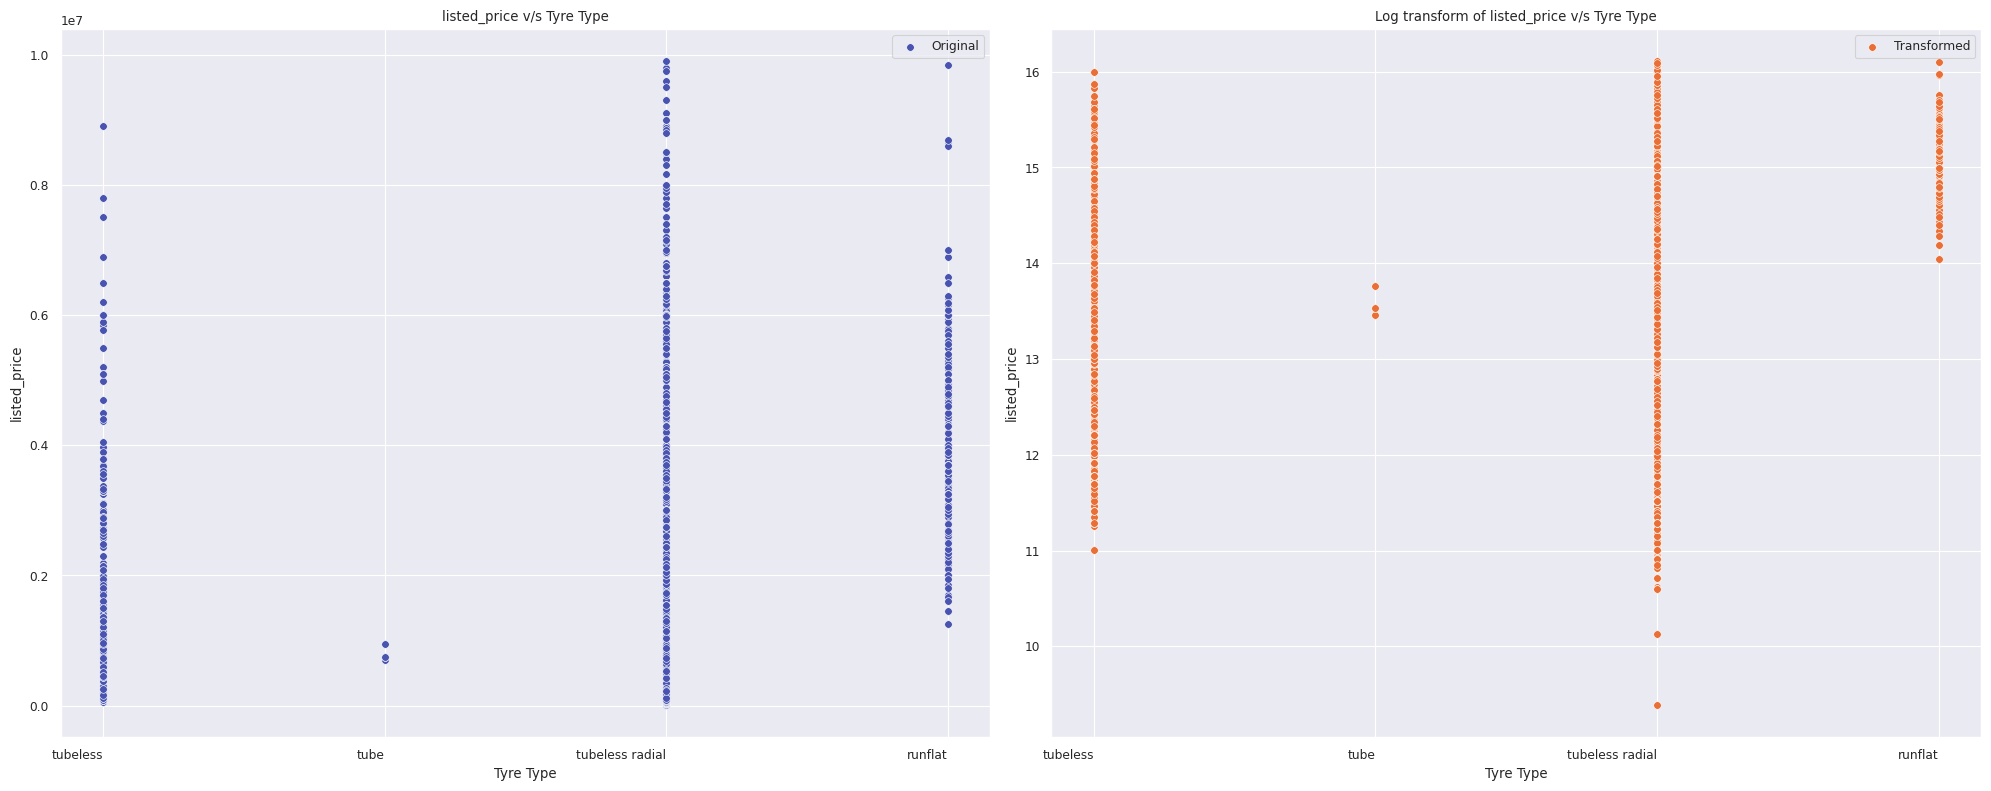

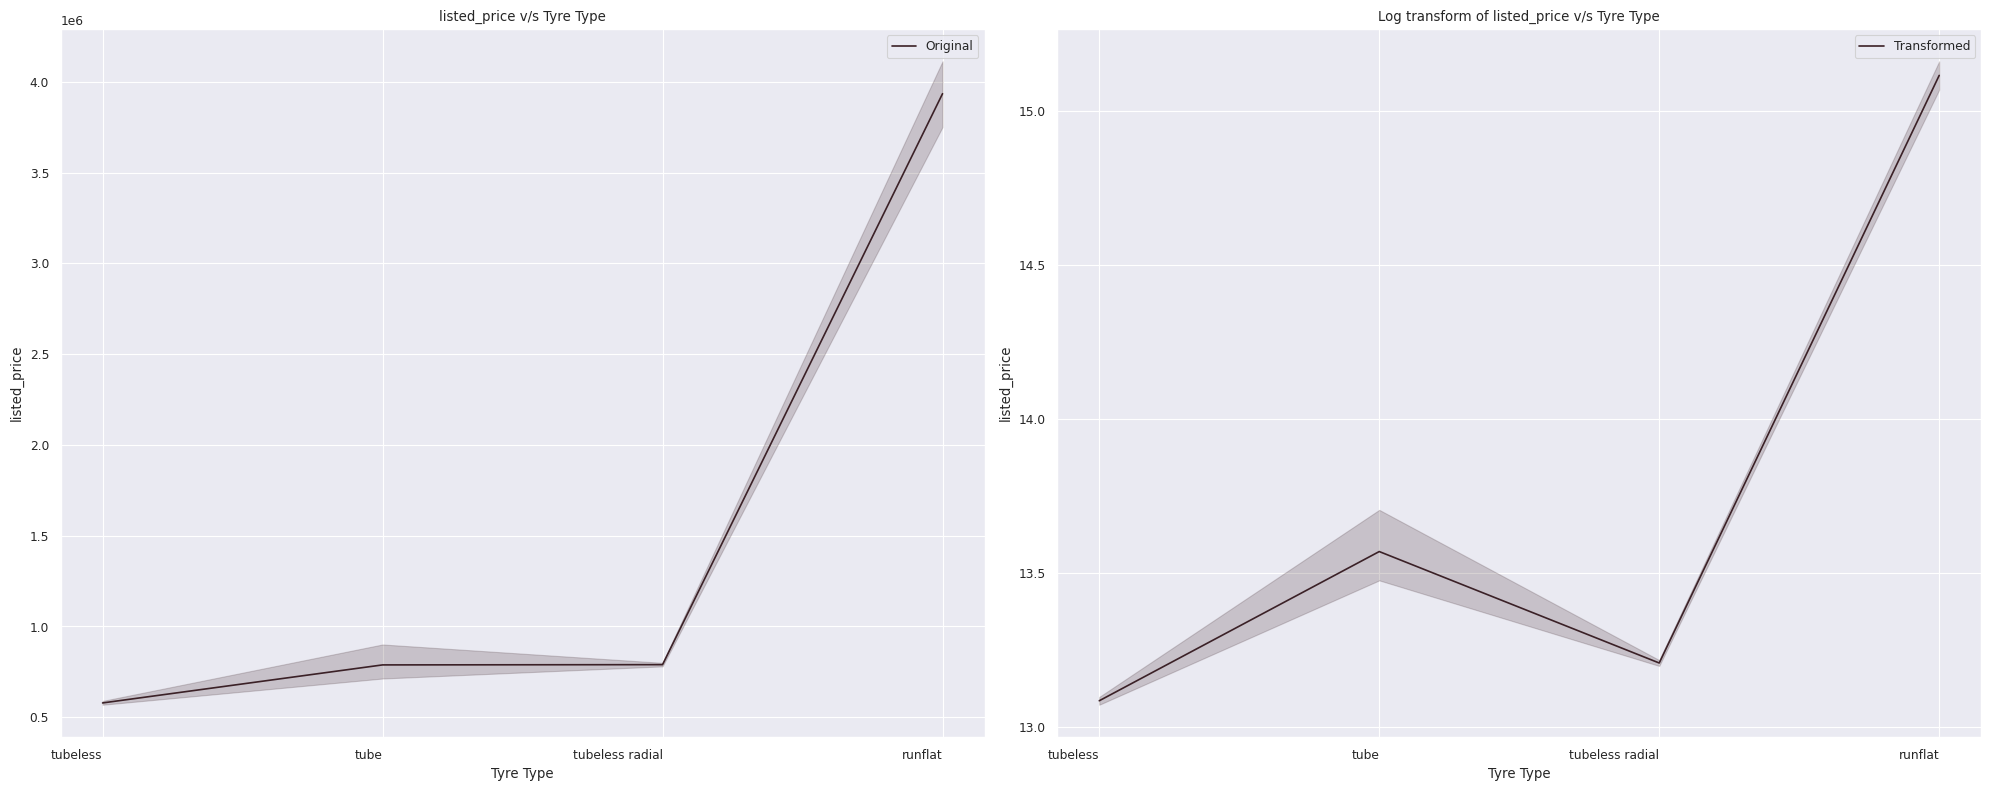

In [27]:
feature_dist_plots(df2, col='Tyre Type', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Tyre Type', fontscale=1, rotation=0, plot='scatter', sorted=True, s=30);
target_relation_plots(df2, col='Tyre Type', fontscale=1, rotation=0, plot='line', sorted=True);

In [28]:
annova_test(df2, 'Tyre Type');

Null Hypothesis: There is no difference between groups of Tyre Type
+---------------------+--------------------+------------------------+------+-----+-------+
|         F(c)        |    F statistic     |         pvalue         |  q   | dfd |  dfn  |
+---------------------+--------------------+------------------------+------+-----+-------+
| 0.17767772226172518 | 260.25966391413965 | 3.475744922678716e-167 | 0.05 |  4  | 37762 |
+---------------------+--------------------+------------------------+------+-----+-------+


In [29]:
annova_test(df2[df2['Tyre Type'] != 'runflat'], 'Tyre Type');

Null Hypothesis: There is no difference between groups of Tyre Type
+---------------------+-------------------+------------------------+------+-----+-------+
|         F(c)        |    F statistic    |         pvalue         |  q   | dfd |  dfn  |
+---------------------+-------------------+------------------------+------+-----+-------+
| 0.11728109270682684 | 296.0203331493839 | 2.823873339442902e-128 | 0.05 |  3  | 37512 |
+---------------------+-------------------+------------------------+------+-----+-------+


### Observations and Suggestions

We can see that even after eliminating the `runflat` group in `Tyre Type`, the other groups are still dissimilar. Therefore we should not drop this column

---

### `Doors`

In [30]:
analyze_data(df2, 'Doors');

Overview of column "Doors"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          5           |
|   Distinct %   | 0.013240824108892536 |
| Missing Count  |          41          |
|   Missing %    |  0.1085747576929188  |
|      Mean      |  4.664536995307653   |
|    Minimum     |         2.0          |
|    Maximum     |         6.0          |
+----------------+----------------------+


Quantile stats for column "Doors"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  2.0  |
|    5th Percentile   |  4.0  |
|  First Quartile, Q1 |  4.0  |
|        Median       |  5.0  |
|  Third Quartile, Q3 |  5.0  |
|   95th Percentile   |  5.0  |
|       Maximum       |  6.0  |
|        Range        |  4.0  |
| Interquartile Range |  1.0  |
+---------------------+-------+


Extremums for column "Doors"
Maximum 5 values
+-------+--

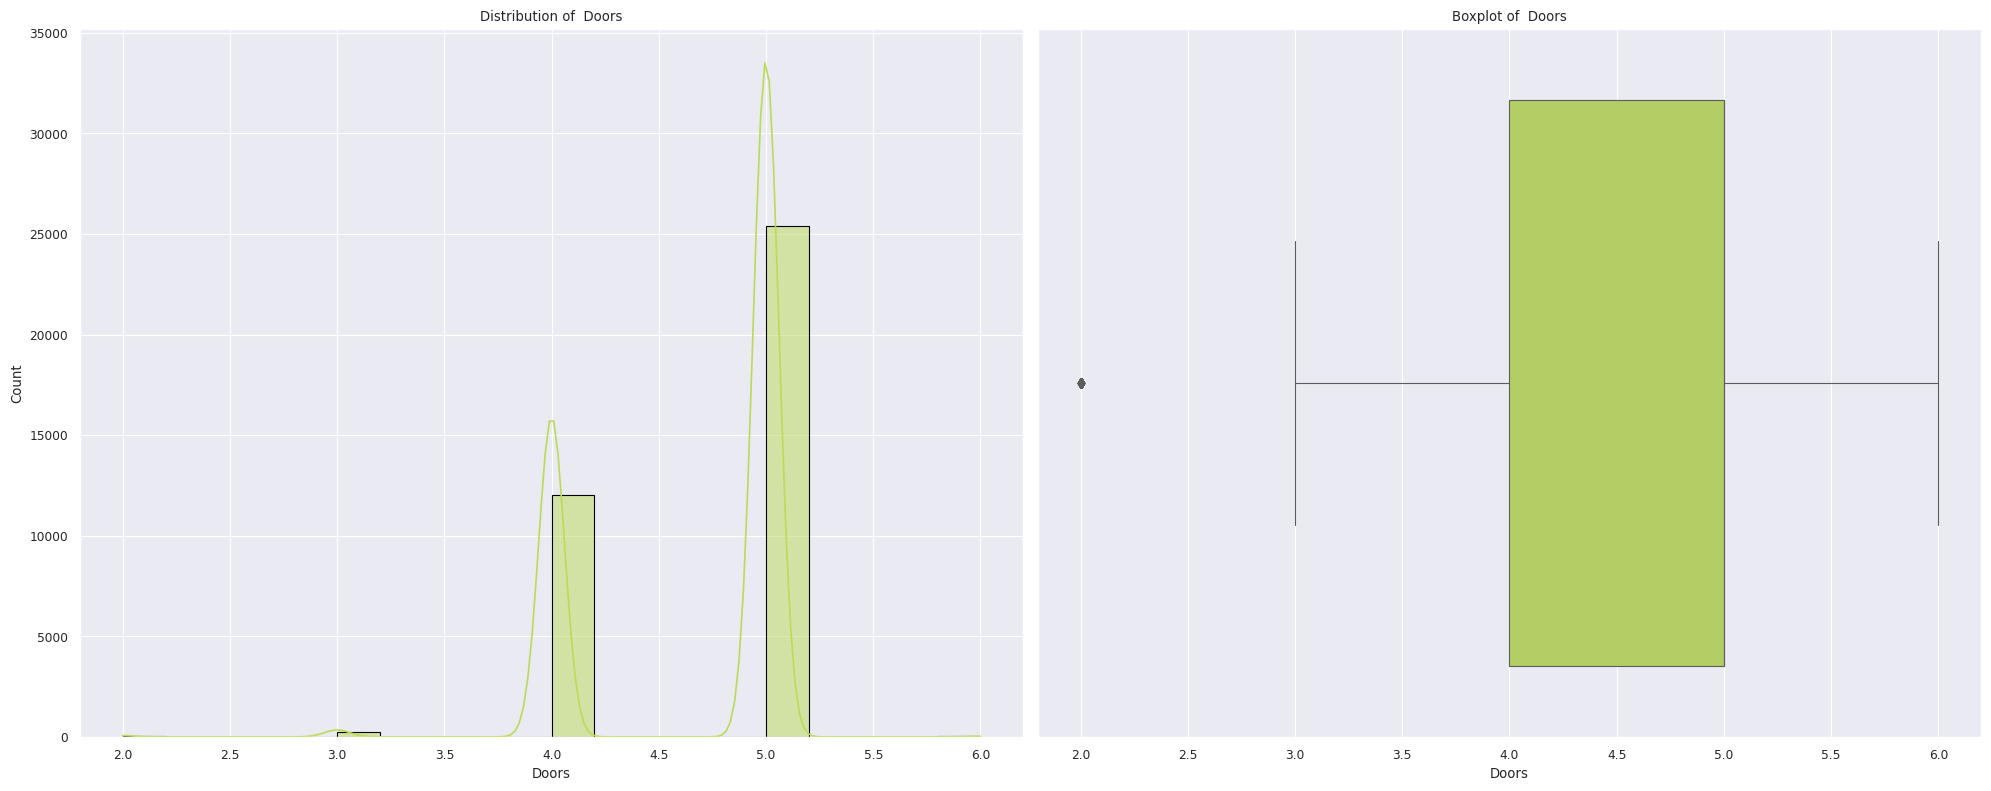

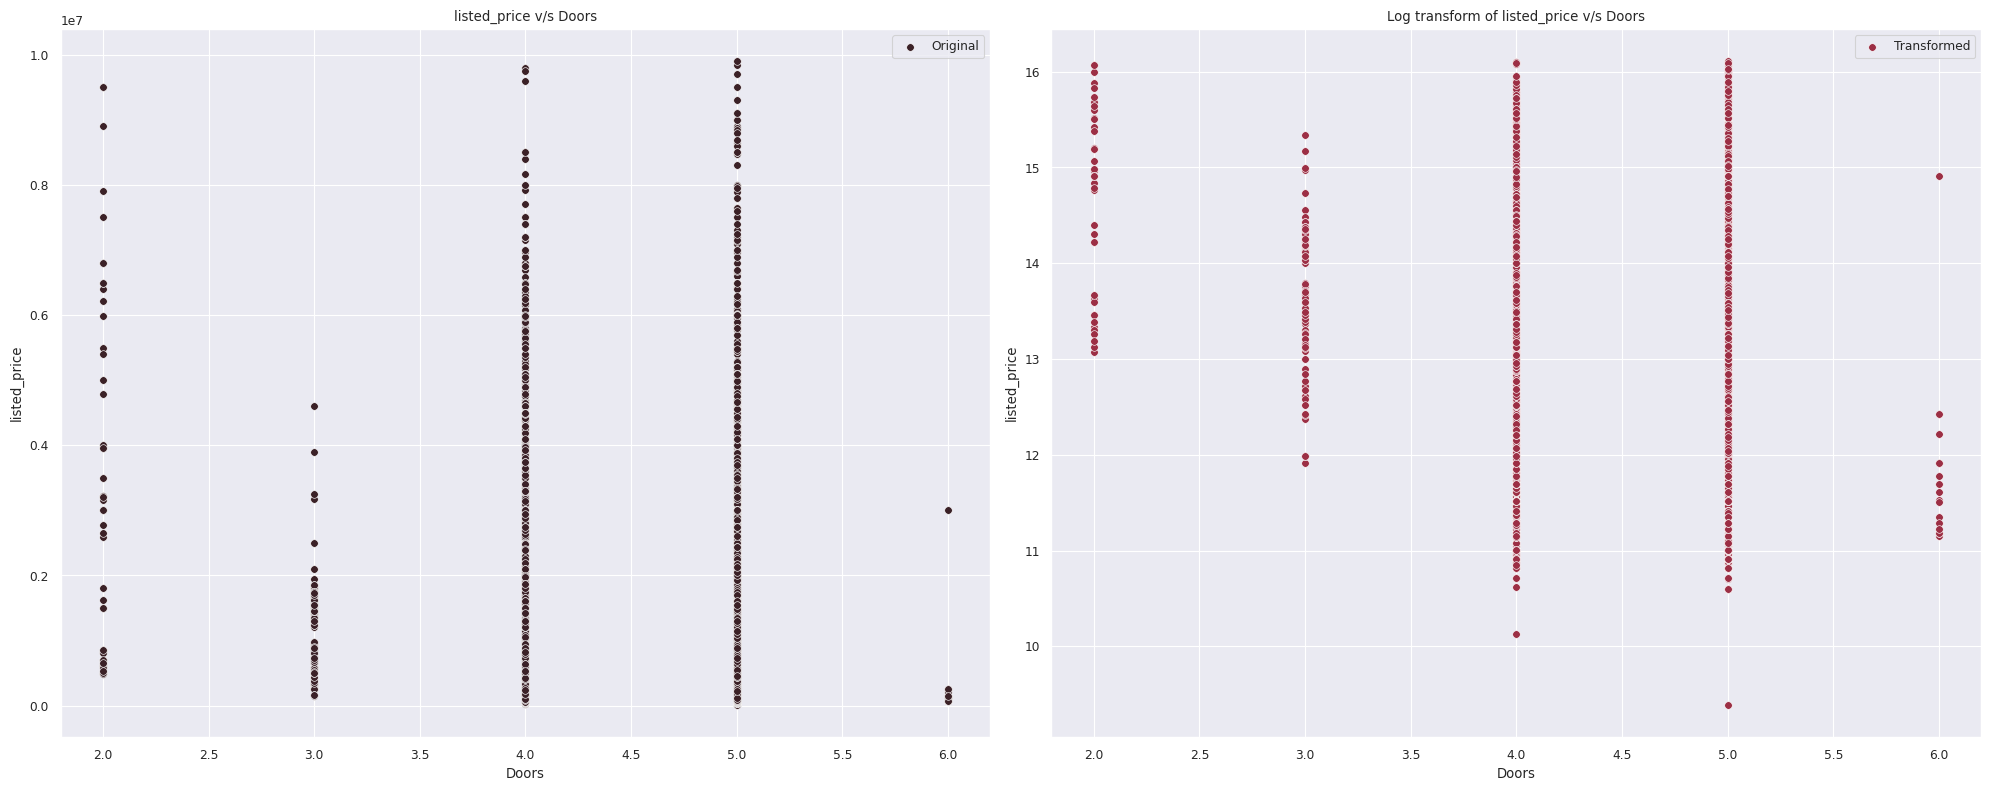

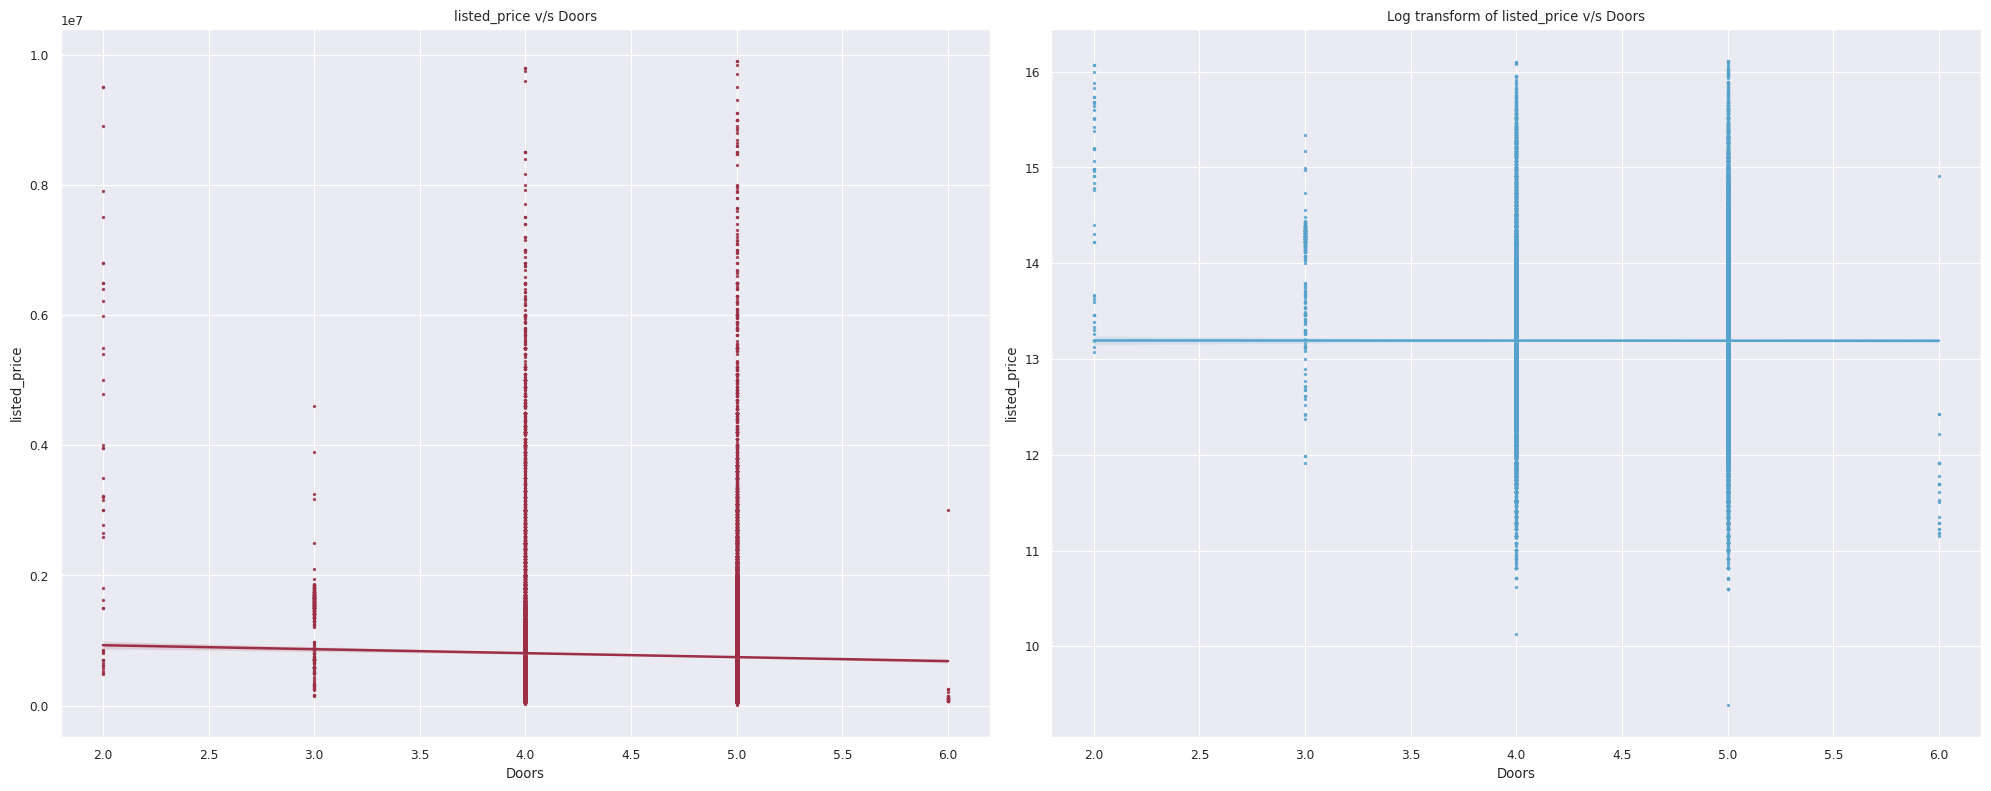

In [31]:
feature_dist_plots(df2, col='Doors', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Doors', fontscale=1, rotation=0, plot='scatter', s=30);
target_relation_plots(df2, col='Doors', fontscale=1, rotation=0, plot='reg', scatter_kws={'s':2});

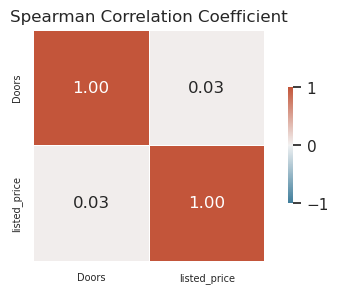

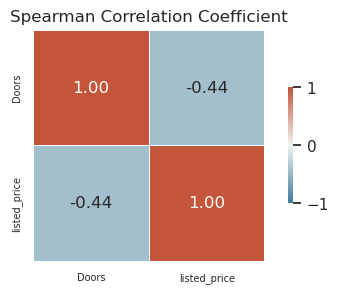

In [32]:
correlation_with_plot(df2, features=['Doors', TARGET], target=False, annot=True, method='spearman', clip=False, figsize=(6, 3));
correlation_with_plot(df2[(df2['Doors'] != 4) & (df2['Doors'] != 5)], features=['Doors', TARGET], target=False, annot=True, method='spearman', clip=False, figsize=(6, 3));

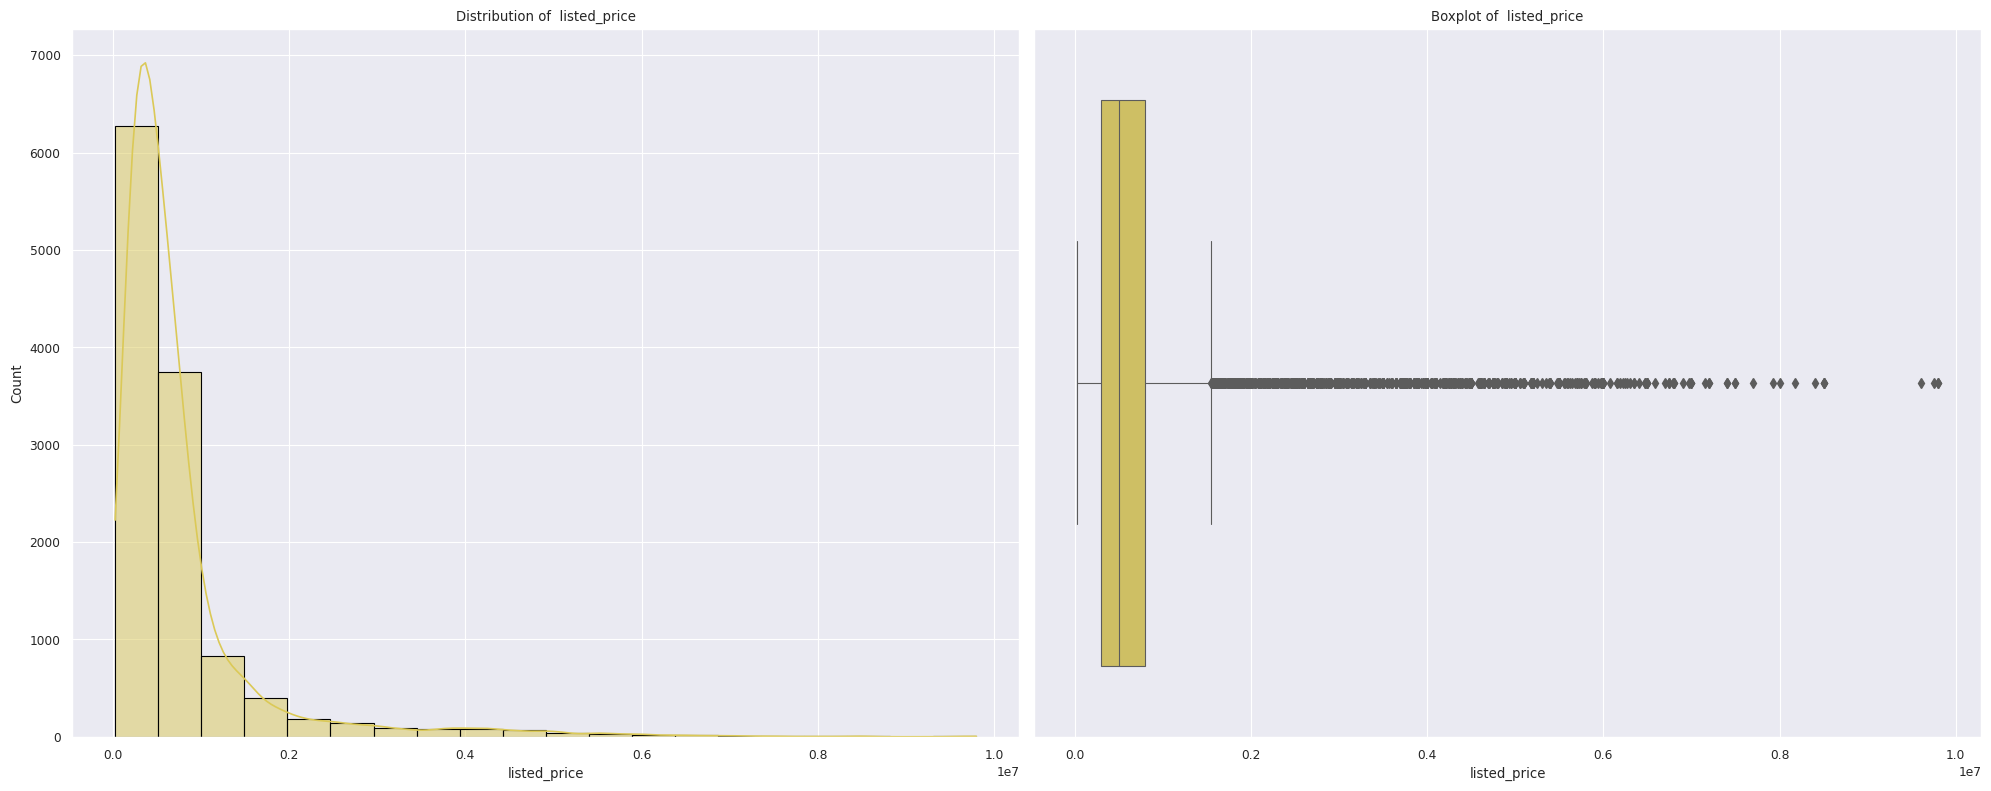

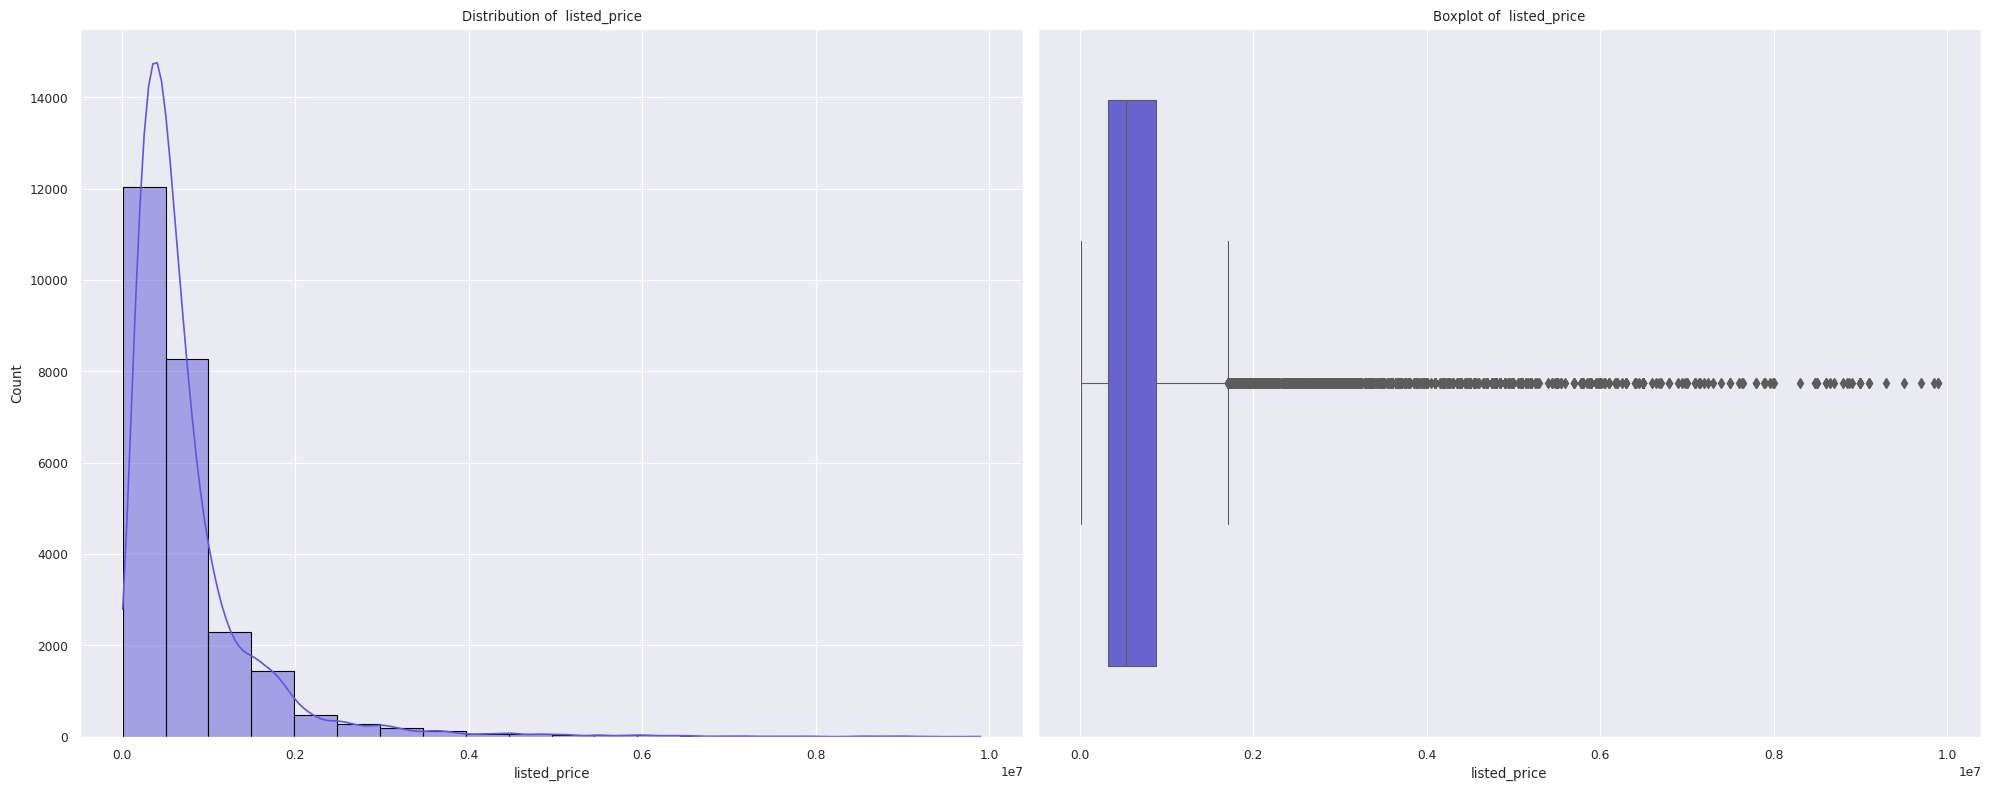

In [33]:
feature_dist_plots(df2[df2['Doors'] == 4], col=TARGET, linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
feature_dist_plots(df2[df2['Doors'] == 5], col=TARGET, linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);

### Observations and Suggestions for `Doors`

- We can see that there isn't any major variation in the price of the car with the number of doors. But this is only because of the fact that the majority of the cars have 4 or 5 doors, which isn't a huge factor but for the rest, the price vary quite a bit. Therefore it would not be wise to drop this column.
- However as the above distributions suggest, the cars with 4 doors have a very similiar distribution to those having 5 doors. We should just replace all the columns which have 5 as the `Doors` with 4.

**Since this is not a transformation only on the training set and can also affect predictions of new cars, this should be included in the *MODEL PIPELINE* as well**.

In [34]:
def Doors_transformation(df: pd.DataFrame):
    """
    Replace all rows having Doors=5 with Doors=4
    """
    df.loc[(df['Doors'] == 5), 'Doors'] = 4
    return

suggested_transformations.append(Doors_transformation)

---
### `Cargo Volume`

In [35]:
analyze_data(df2, 'Cargo Volume');

Overview of column "Cargo Volume"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        199         |
|   Distinct %   | 0.526984799533923  |
| Missing Count  |        6703        |
|   Missing %    | 17.750648800381335 |
|      Mean      | 363.0107859235648  |
|    Minimum     |        20.0        |
|    Maximum     |       2055.0       |
+----------------+--------------------+


Quantile stats for column "Cargo Volume"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       |  20.0  |
|    5th Percentile   | 175.0  |
|  First Quartile, Q1 | 256.0  |
|        Median       | 350.0  |
|  Third Quartile, Q3 | 465.0  |
|   95th Percentile   | 540.0  |
|       Maximum       | 2055.0 |
|        Range        | 2035.0 |
| Interquartile Range | 209.0  |
+---------------------+--------+


Extremums for column "Cargo Volume"
Maximum 5 values

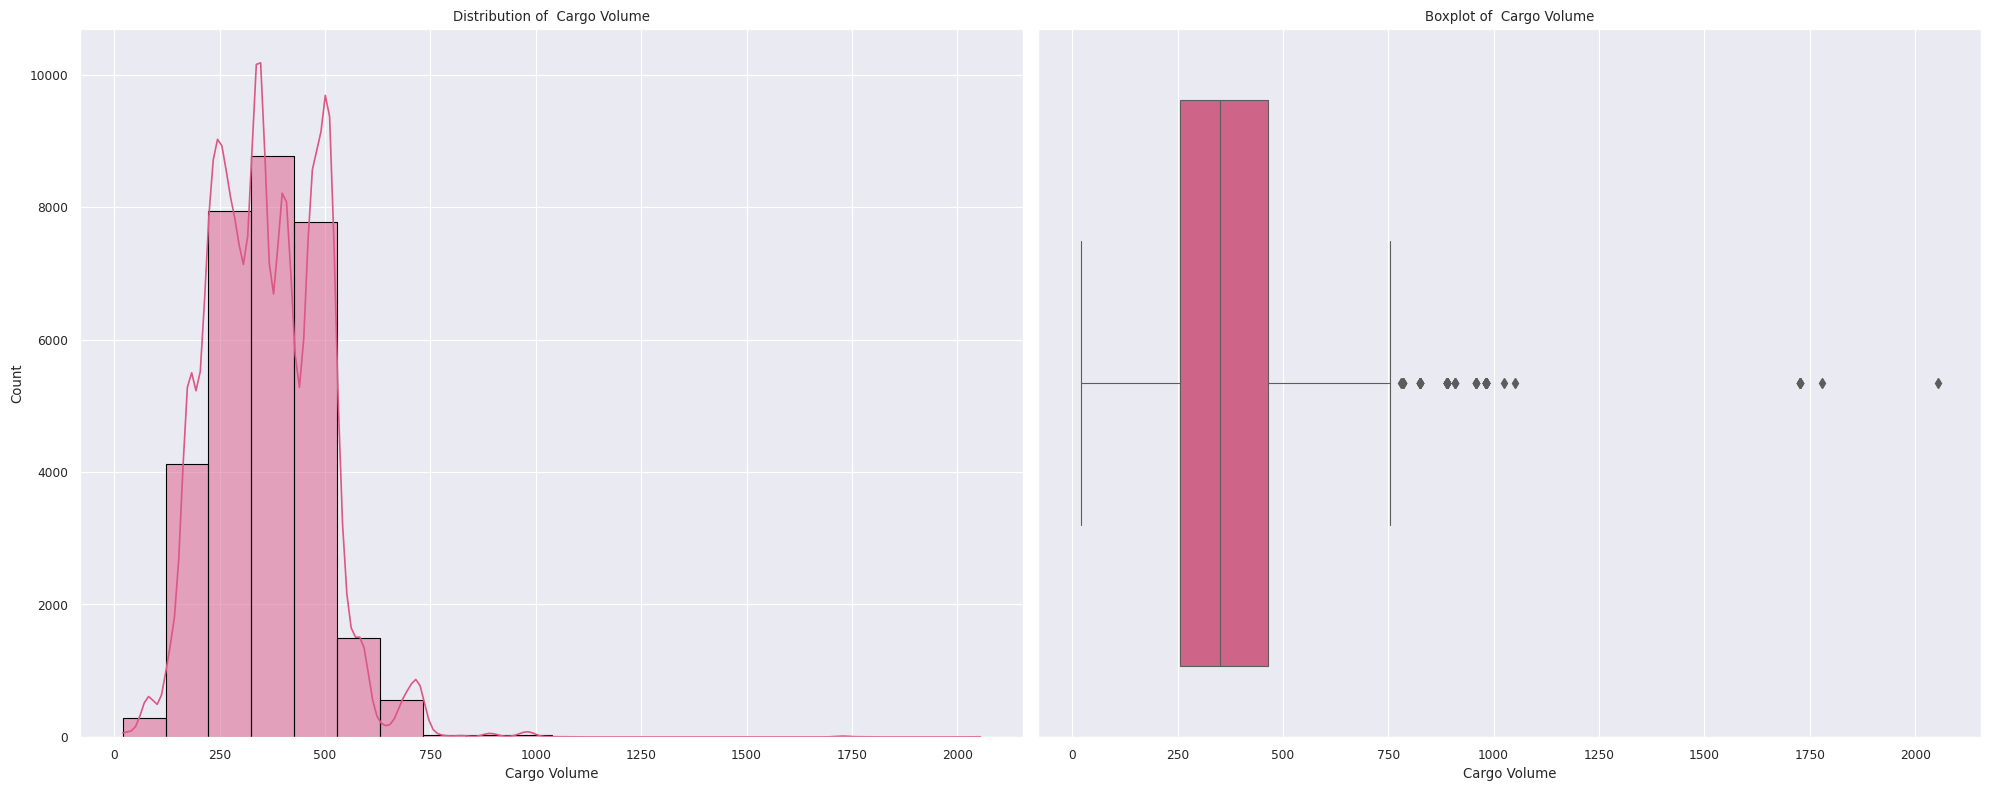

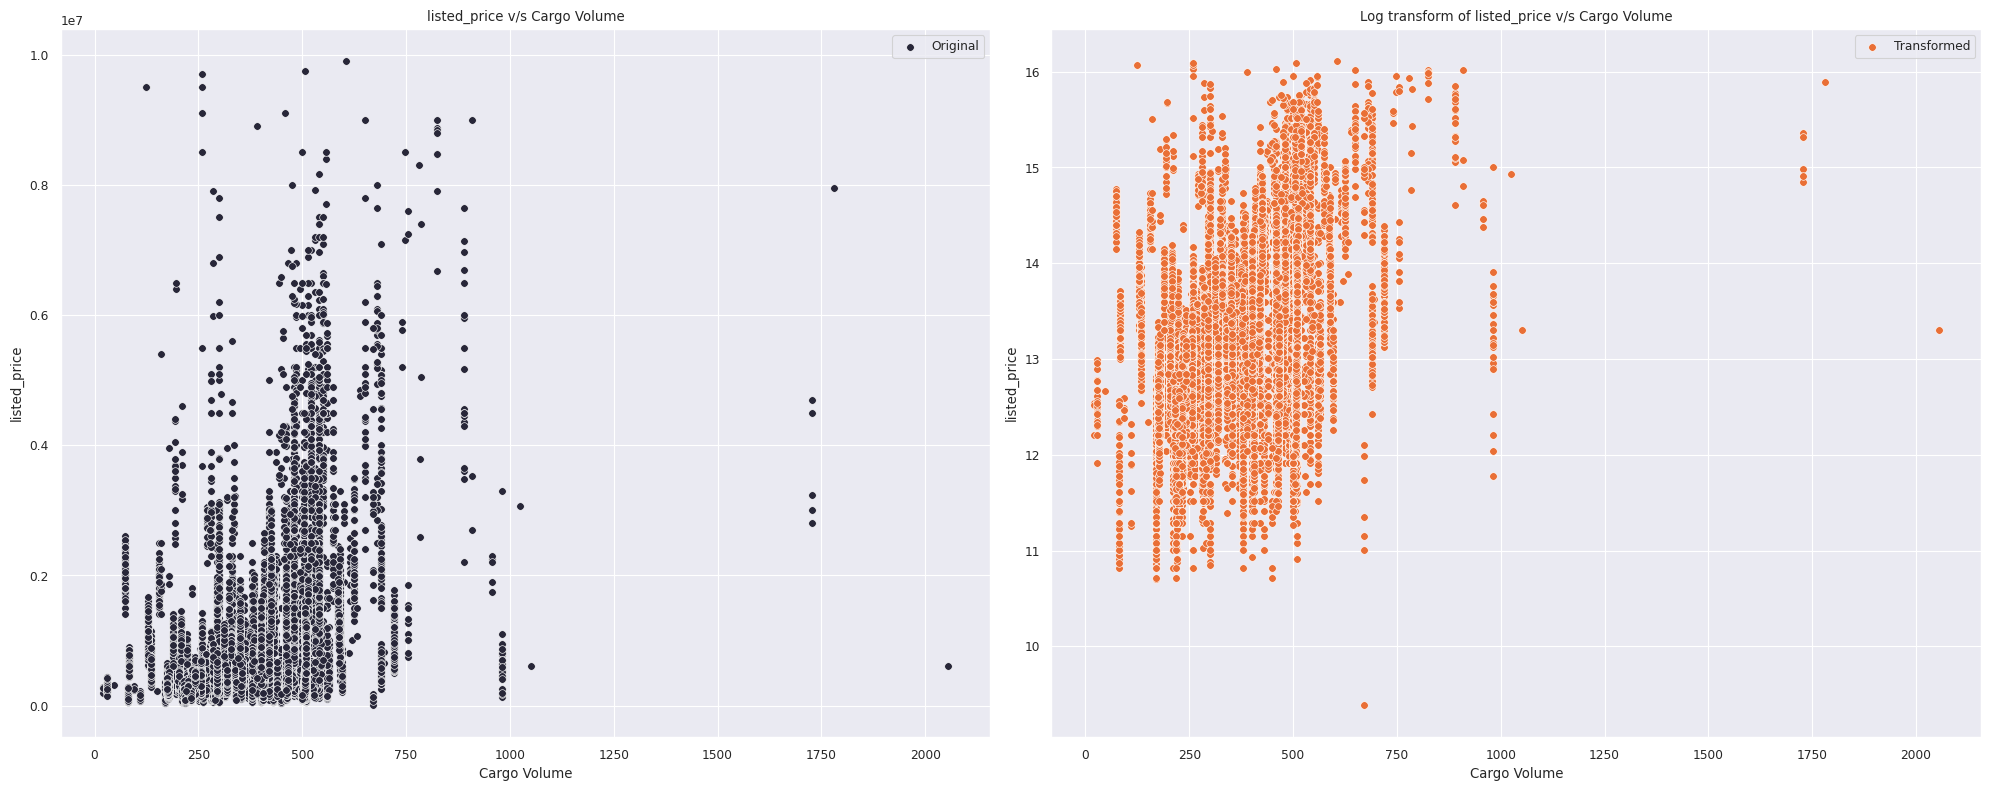

In [36]:
feature_dist_plots(df2, col='Cargo Volume', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Cargo Volume', fontscale=1, rotation=0, plot='scatter', s=30);

---

### `model_type_new`

In [37]:
analyze_data(df2, 'model_type_new');

Overview of column "model_type_new"
+----------------+-----------------------+
|    Measure     |         Value         |
+----------------+-----------------------+
| Distinct Count |           1           |
|   Distinct %   | 0.0026481648217785074 |
| Missing Count  |           0           |
|   Missing %    |          0.0          |
+----------------+-----------------------+


Column model_type_new is not numeric
Common values for column "model_type_new"
+-------+-------+-----------+-------------------+
| Value | Count | Frequency |   Mean of Target  |
+-------+-------+-----------+-------------------+
|  used | 37762 |   100.0   | 763937.9758487368 |
+-------+-------+-----------+-------------------+




### Suggestions for `model_type_new`

Drop the column since it has zero variance.

In [38]:
def model_type_new_transformation(df: pd.DataFrame):
    """
    Drop the 'model_type_new' column
    """
    df.drop('model_type_new', axis=1, inplace=True)
    return

suggested_transformations.append(model_type_new_transformation)

---

### `exterior_color`

In [39]:
analyze_data(df2, 'exterior_color', n=15);

Overview of column "exterior_color"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        747         |
|   Distinct %   | 1.9781791218685452 |
| Missing Count  |        122         |
|   Missing %    | 0.3230761082569779 |
+----------------+--------------------+


Column exterior_color is not numeric
Common values for column "exterior_color"
+--------------+-------+--------------------+--------------------+
|    Value     | Count |     Frequency      |   Mean of Target   |
+--------------+-------+--------------------+--------------------+
|    white     | 10046 | 26.689691817215728 |  851571.088891101  |
|    silver    |  4445 | 11.809245483528162 |  614480.327784027  |
|     grey     |  3284 | 8.724760892667375  | 724972.7335566382  |
|     red      |  2809 | 7.4628055260361315 | 696180.1936632254  |
|     blue     |  2009 |  5.33740701381509  | 1089624.6520657043 |
|    black     |  1954 | 5.

### Suggestion

Since we already have a column named 'Color', drop this column

In [40]:
def exterior_color_new_transformation(df: pd.DataFrame):
    """
    Drop the 'exterior_color_new' column
    """
    df.drop('exterior_color_new', axis=1, inplace=True)
    return

suggested_transformations.append(exterior_color_new_transformation)

---

### `owner_type`

In [41]:
analyze_data(df2, 'owner_type', n=6);

Overview of column "owner_type"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          6           |
|   Distinct %   | 0.015888988930671043 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Column owner_type is not numeric
Common values for column "owner_type"
+------------------+-------+----------------------+--------------------+
|      Value       | Count |      Frequency       |   Mean of Target   |
+------------------+-------+----------------------+--------------------+
|      first       | 26523 |  70.23727556803135   | 841031.9716472495  |
|      second      |  8764 |  23.20851649806684   |  629532.901414879  |
|      third       |  1963 |  5.1983475451512104  | 433661.9974528782  |
|      fourth      |  445  |  1.1784333456914358  | 311651.2561797753  |
|      fifth       |   58  | 0.15359355966315344

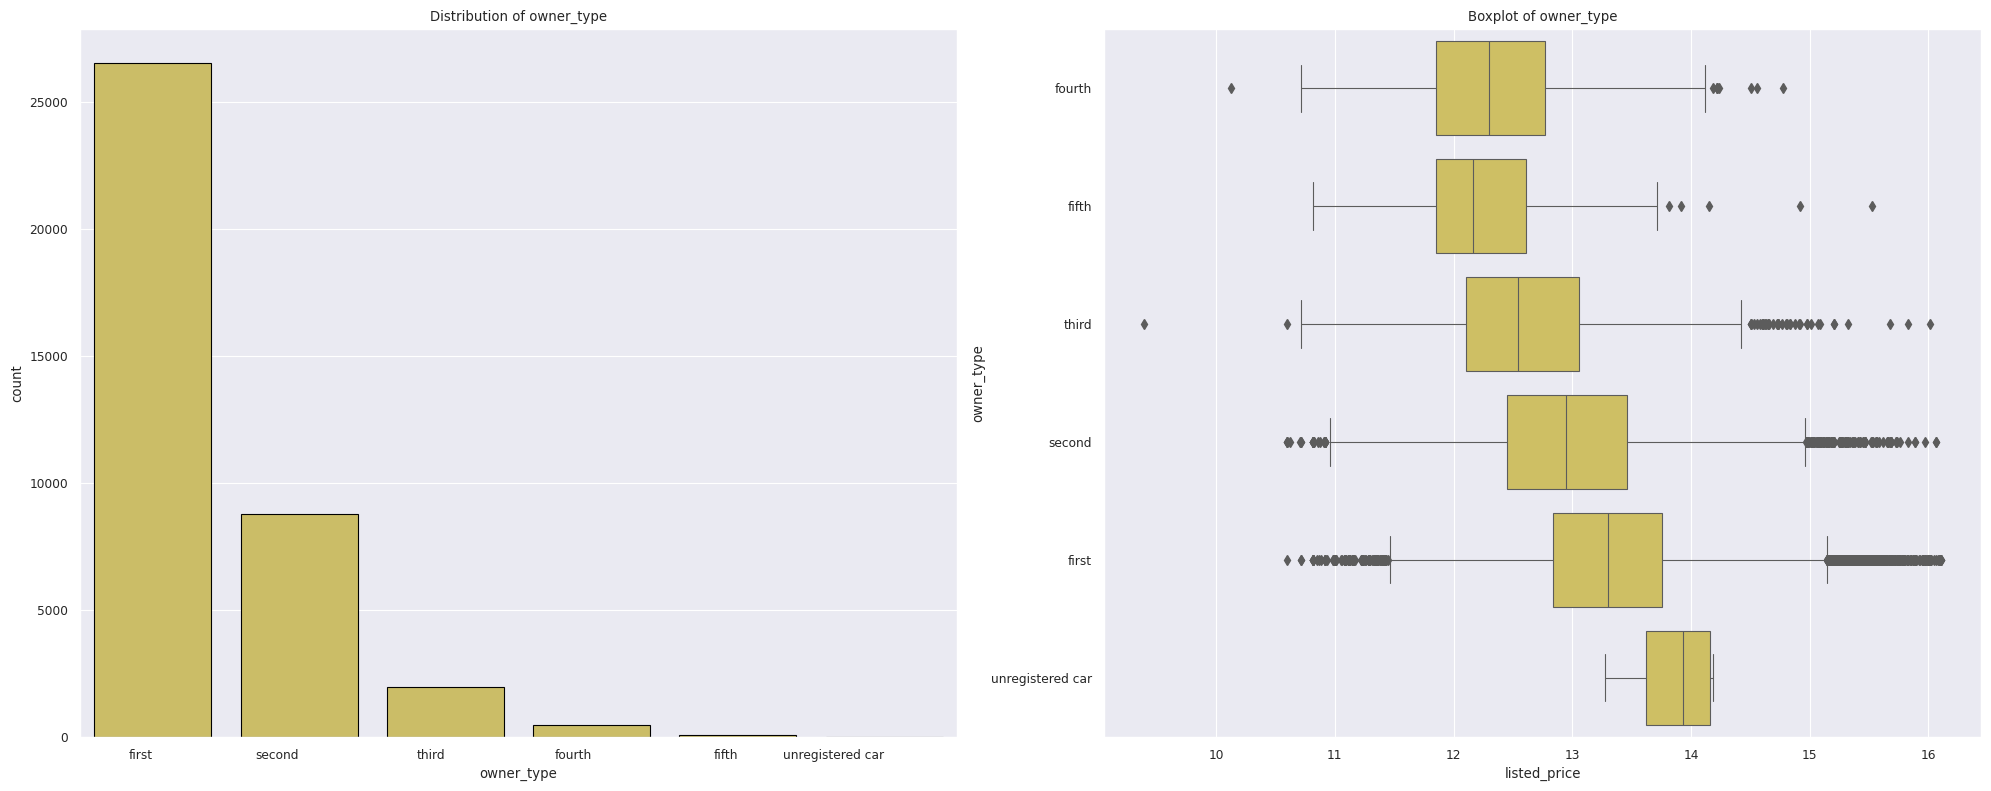

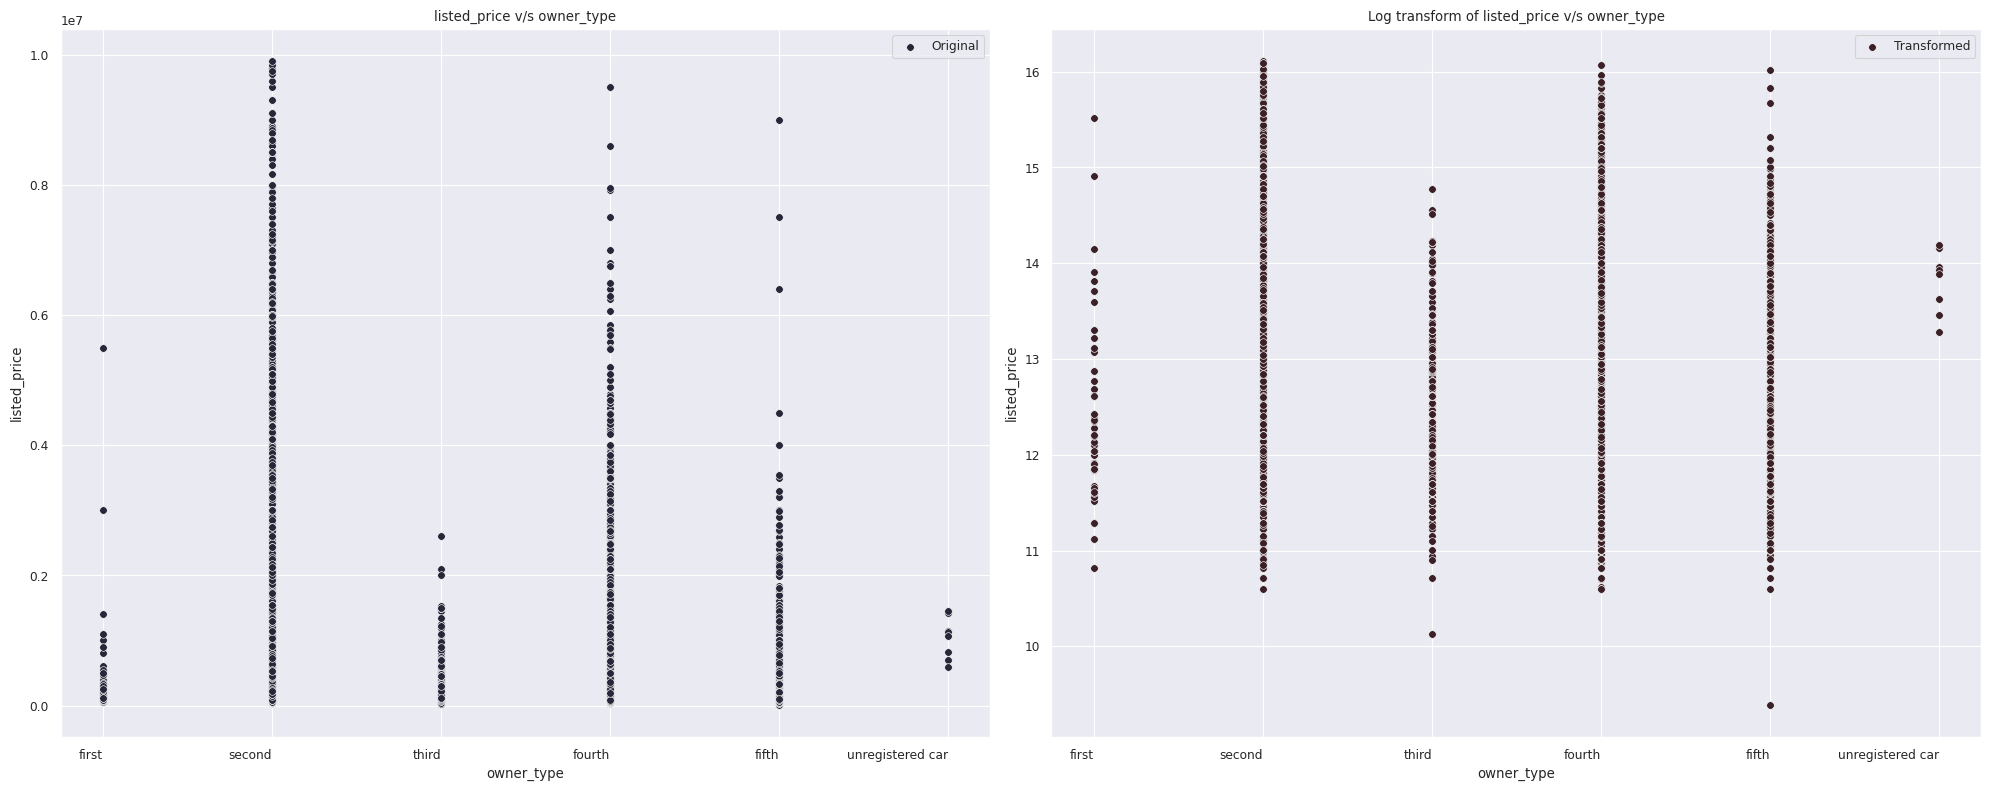

In [42]:
feature_dist_plots(df2, col='owner_type', linewidth=0.8, sat=0.8, fontscale=1, rotation=0, transformation=np.log, sorted=True);
target_relation_plots(df2, col='owner_type', fontscale=1, rotation=0, plot='scatter', s=30);

---

### `Fuel Suppy System`

In [43]:
analyze_data(df2, 'Fuel Suppy System');

Overview of column "Fuel Suppy System"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |         14         |
|   Distinct %   | 0.0370743075048991 |
| Missing Count  |        5482        |
|   Missing %    | 14.517239552989777 |
+----------------+--------------------+


Column Fuel Suppy System is not numeric
Common values for column "Fuel Suppy System"
+----------------------------+-------+--------------------+--------------------+
|           Value            | Count |     Frequency      |   Mean of Target   |
+----------------------------+-------+--------------------+--------------------+
| Multi-Point Fuel Injection | 14054 | 43.53779429987608  | 474150.75444713247 |
|   Common Rail Injection    | 11810 | 36.586121437422555 | 959658.9740897544  |
|      Direct Injection      |  3819 | 11.83085501858736  |  999018.821942917  |
| Electronic Fuel Injection  |  1593 | 4.934944237918216  | 404450.0

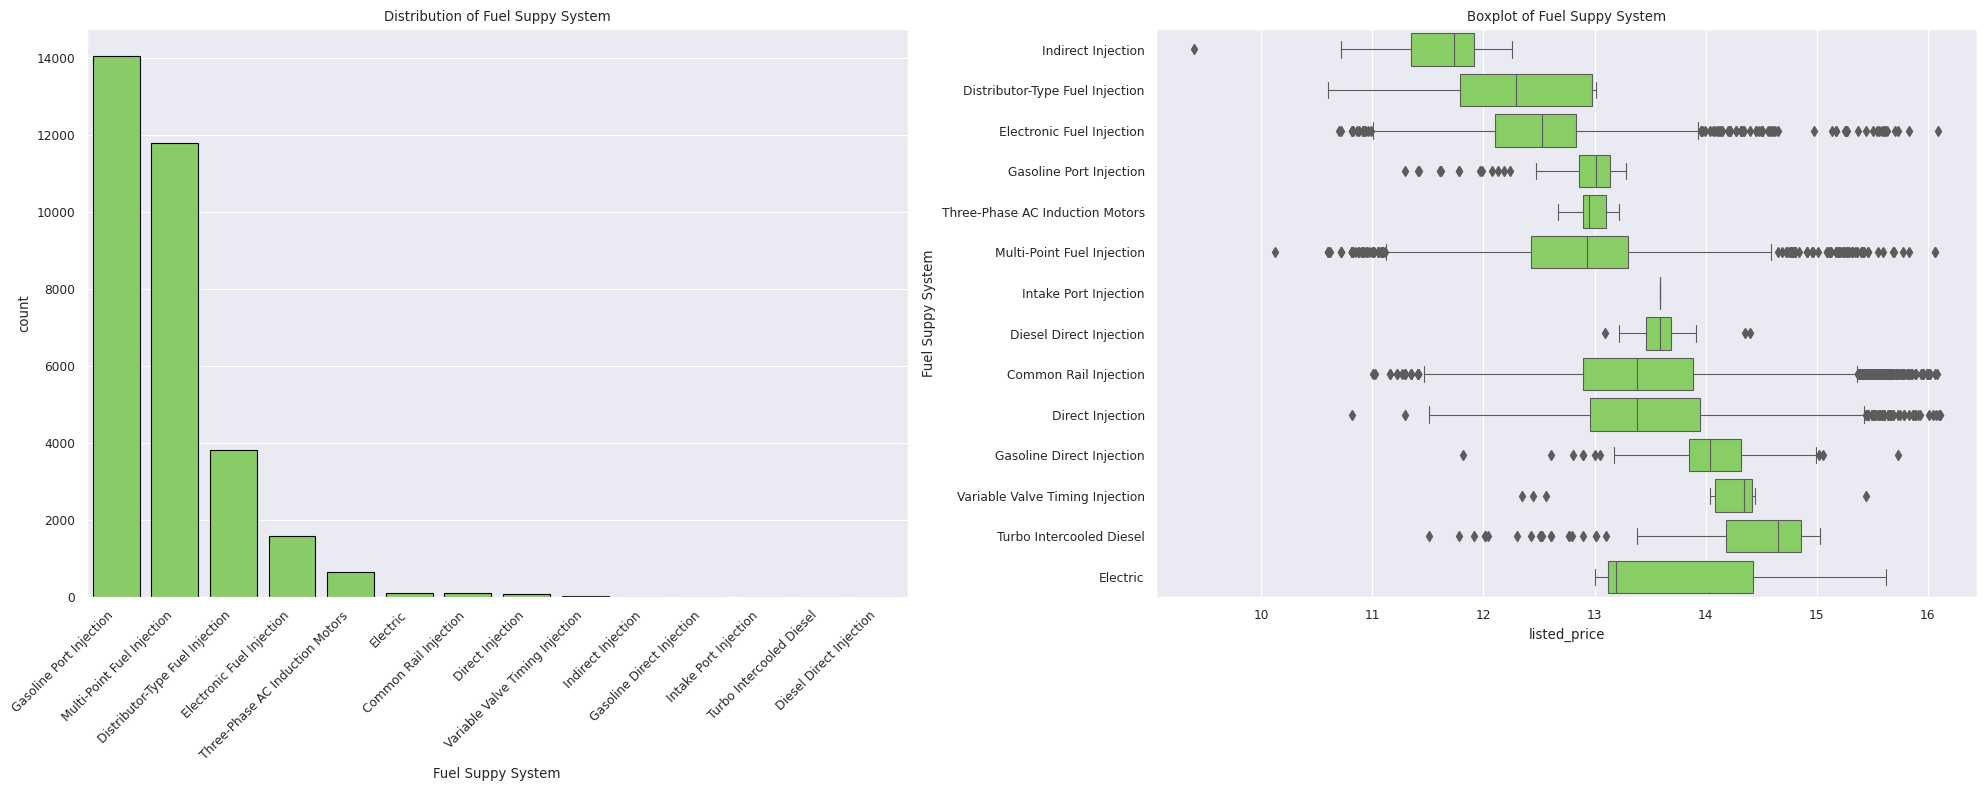

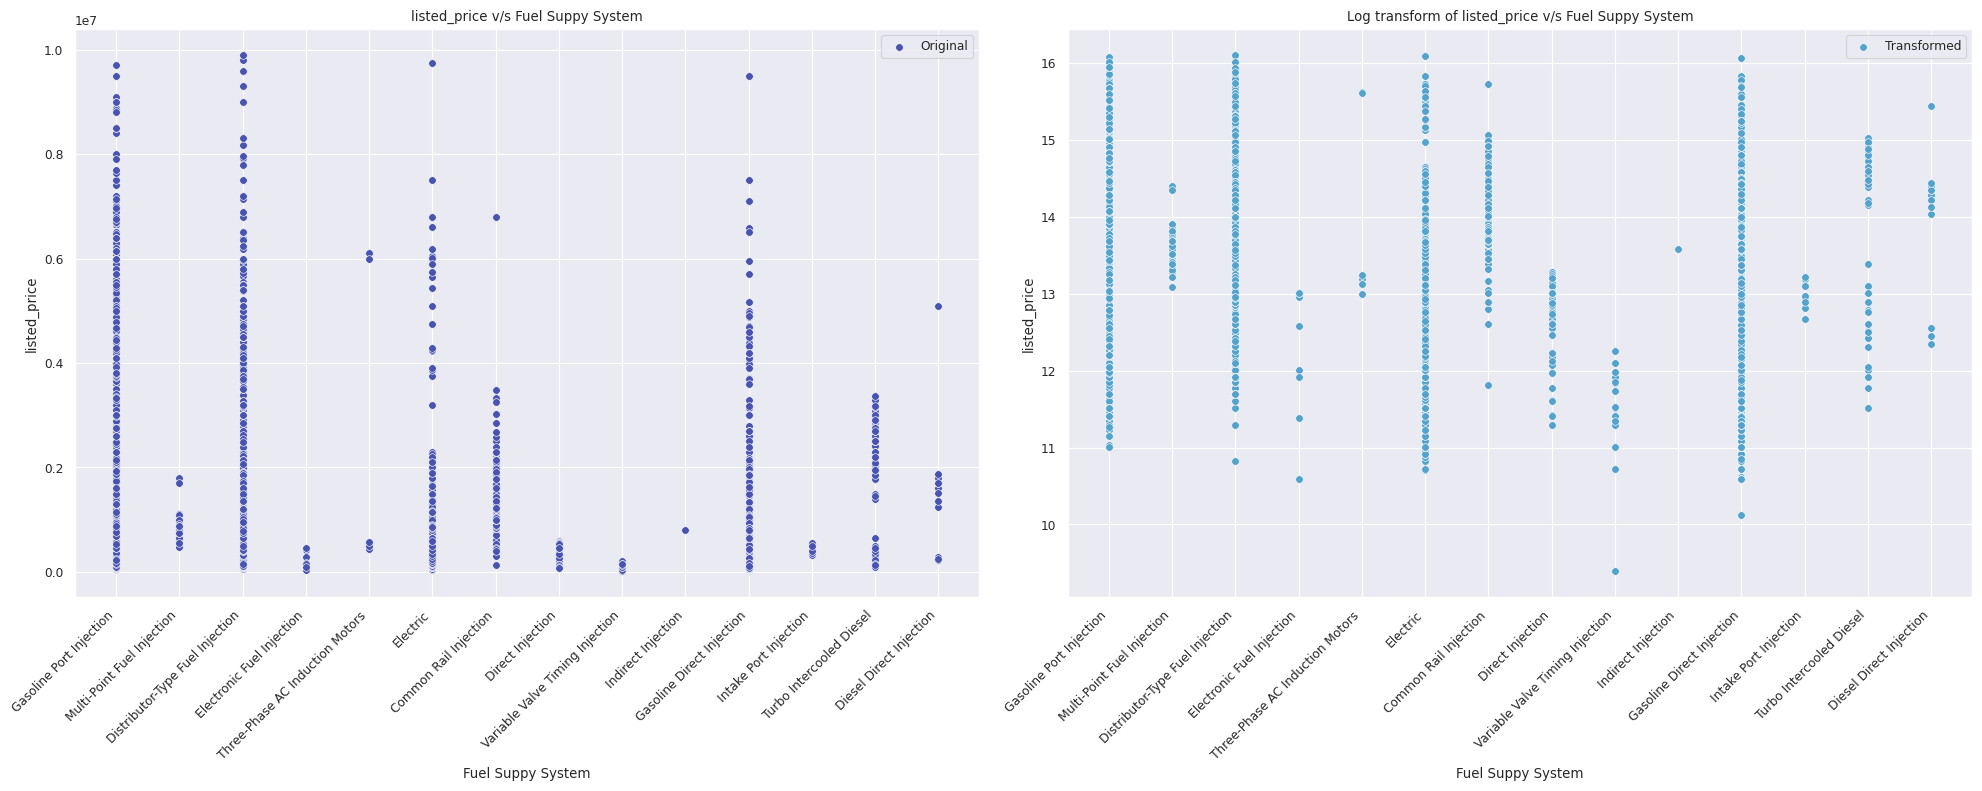

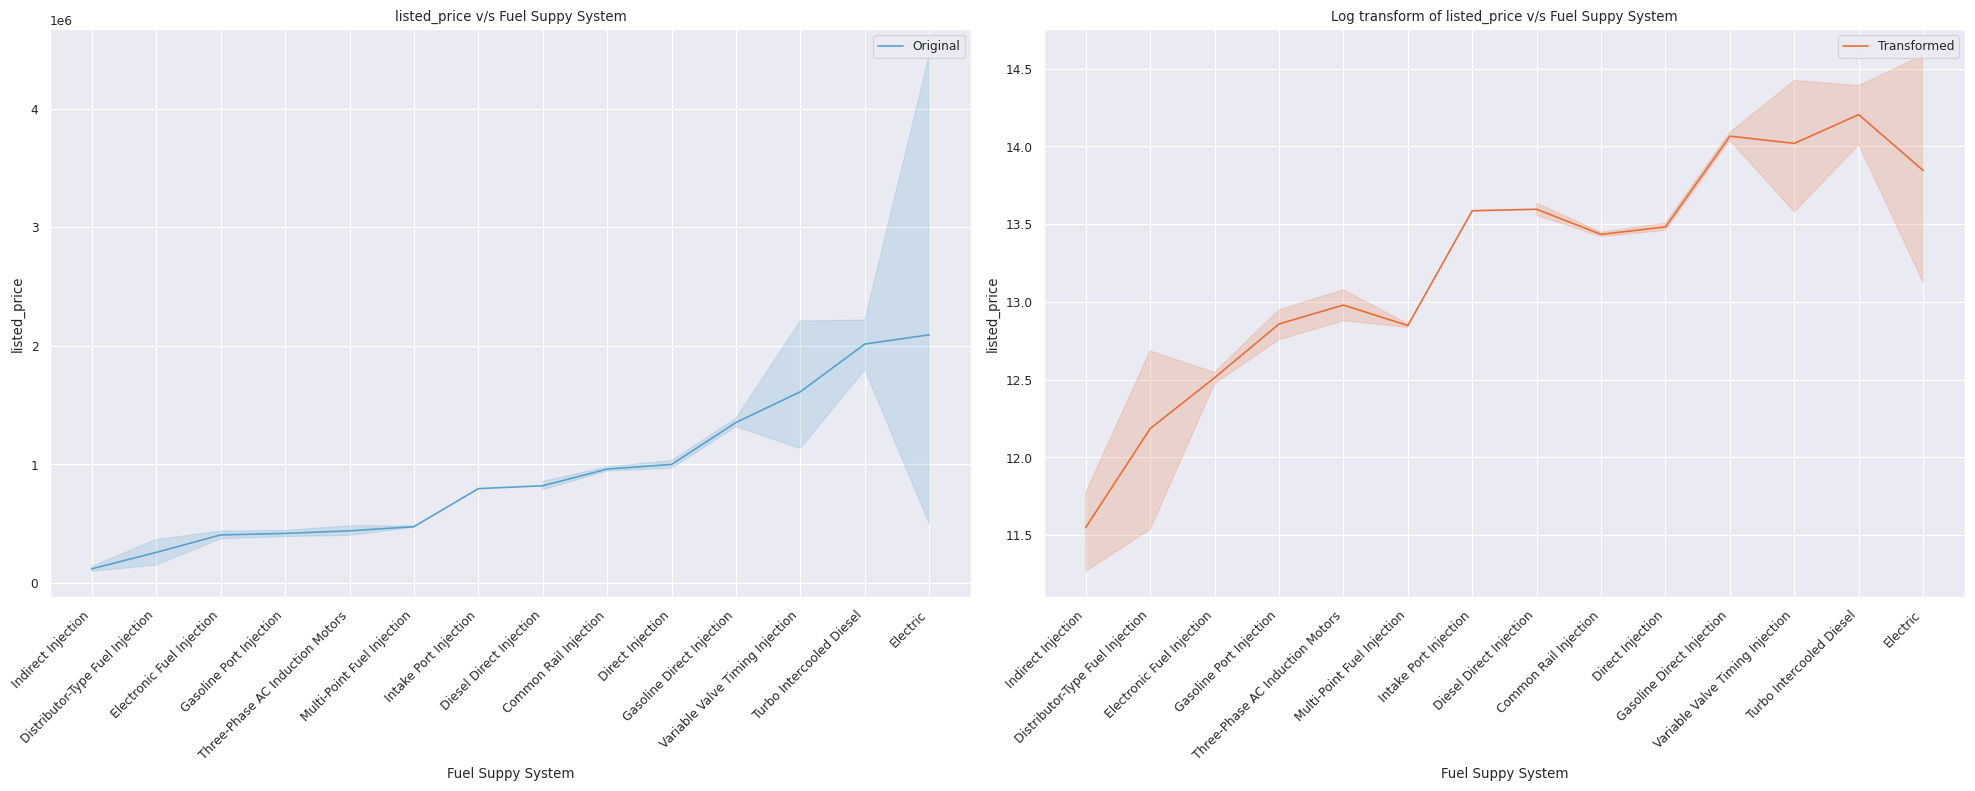

In [44]:
feature_dist_plots(df2, col='Fuel Suppy System', linewidth=0.8, sat=0.8, fontscale=1, rotation=45, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Fuel Suppy System', fontscale=1, rotation=45, plot='scatter', s=30);
target_relation_plots(df2, col='Fuel Suppy System', fontscale=1, rotation=45, plot='line', sorted=True);

---

### `Compression Ratio` 

In [45]:
analyze_data(df2, 'Compression Ratio');

Overview of column "Compression Ratio"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          60         |
|   Distinct %   | 0.15888988930671044 |
| Missing Count  |        27758        |
|   Missing %    |  73.50775912292781  |
|      Mean      |  12.833528588564574 |
|    Minimum     |         4.17        |
|    Maximum     |         81.0        |
+----------------+---------------------+


Quantile stats for column "Compression Ratio"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  4.17 |
|    5th Percentile   |  9.0  |
|  First Quartile, Q1 |  10.1 |
|        Median       |  10.5 |
|  Third Quartile, Q3 |  16.2 |
|   95th Percentile   |  17.6 |
|       Maximum       |  81.0 |
|        Range        | 76.83 |
| Interquartile Range |  6.1  |
+---------------------+-------+


Extremums for column "Compression Ratio"
Max

In [46]:
analyze_data(df2, 'Ground Clearance Unladen');

Overview of column "Ground Clearance Unladen"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          26         |
|   Distinct %   | 0.06885228536624119 |
| Missing Count  |        35610        |
|   Missing %    |  94.30114930353265  |
|      Mean      |  179.41589219330854 |
|    Minimum     |         91.0        |
|    Maximum     |        213.0        |
+----------------+---------------------+


Quantile stats for column "Ground Clearance Unladen"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  91.0 |
|    5th Percentile   | 120.0 |
|  First Quartile, Q1 | 178.0 |
|        Median       | 190.0 |
|  Third Quartile, Q3 | 192.0 |
|   95th Percentile   | 209.0 |
|       Maximum       | 213.0 |
|        Range        | 122.0 |
| Interquartile Range |  14.0 |
+---------------------+-------+


Extremums for column "Ground C

### Suggestions

These column has over **60%** data missing. It is better top drop these columns.

In [47]:
# Drop the Ground Clearance Unladen and Compression Ratio columns
def GroundClearanceUnladen_transformation(df: pd.DataFrame):
    """
    Drop the 'Ground Clearance Unladen' column
    """
    df.drop('Ground Clearance Unladen', axis=1, inplace=True)
    return

suggested_transformations.append(GroundClearanceUnladen_transformation)


def CompressionRatio_transformation(df: pd.DataFrame):
    """
    Drop the 'Compression Ratio' column
    """
    df.drop('Compression Ratio', axis=1, inplace=True)
    return

suggested_transformations.append(CompressionRatio_transformation)

---

### `Alloy Wheel Size`

In [48]:
analyze_data(df2, 'Alloy Wheel Size');

Overview of column "Alloy Wheel Size"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          11         |
|   Distinct %   | 0.02912981303956358 |
| Missing Count  |        14457        |
|   Missing %    |  38.28451882845189  |
|      Mean      |  15.441450332546664 |
|    Minimum     |         7.0         |
|    Maximum     |         21.0        |
+----------------+---------------------+


Quantile stats for column "Alloy Wheel Size"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  7.0  |
|    5th Percentile   |  13.0 |
|  First Quartile, Q1 |  14.0 |
|        Median       |  16.0 |
|  Third Quartile, Q3 |  16.0 |
|   95th Percentile   |  18.0 |
|       Maximum       |  21.0 |
|        Range        |  14.0 |
| Interquartile Range |  2.0  |
+---------------------+-------+


Extremums for column "Alloy Wheel Size"
Maximu

In [49]:
df2[df2['Alloy Wheel Size'] == 7][['model', TARGET]]

model  listed_price
6764  skoda yeti    445000.000
6880  skoda yeti    250000.000

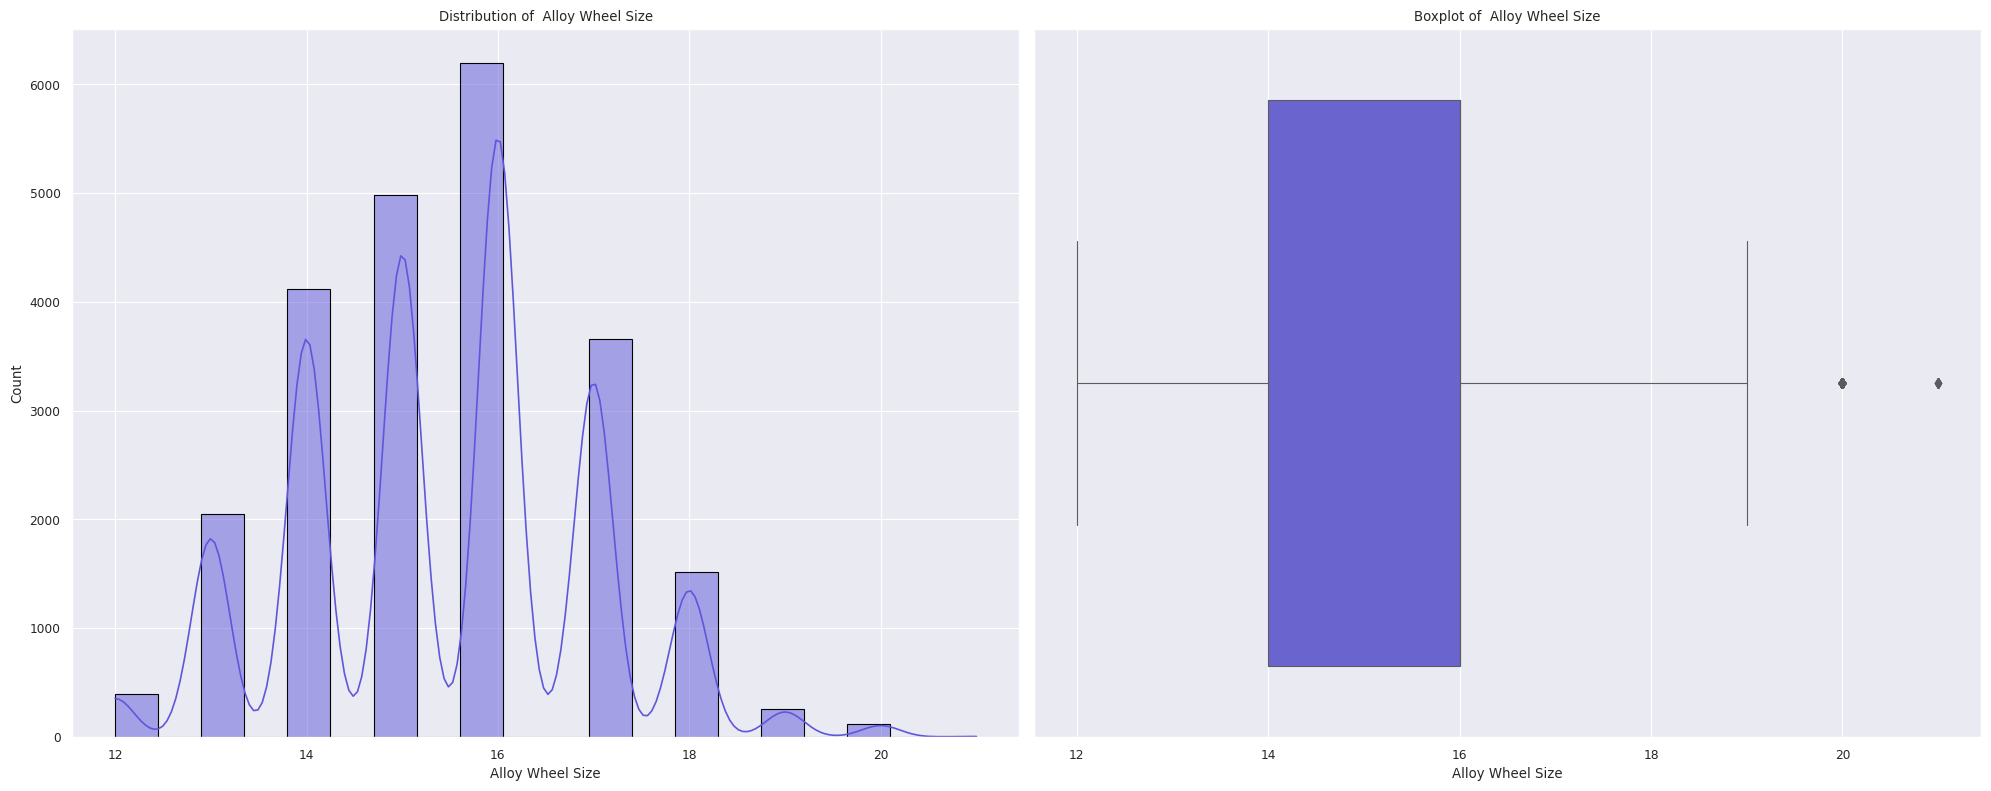

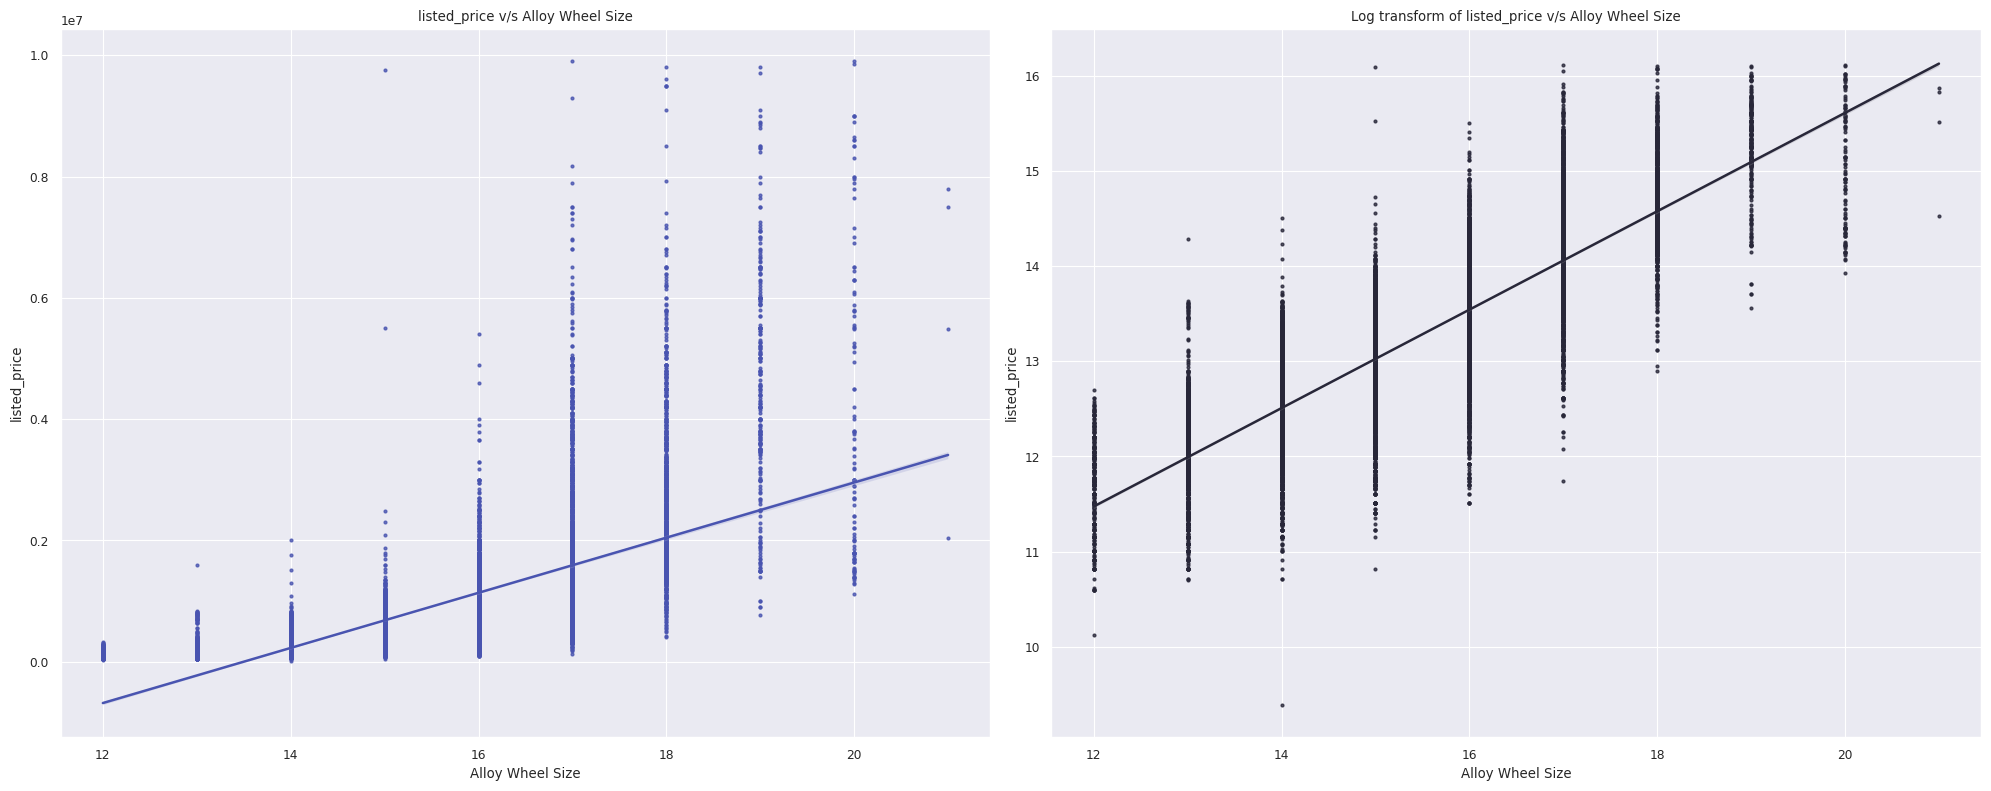

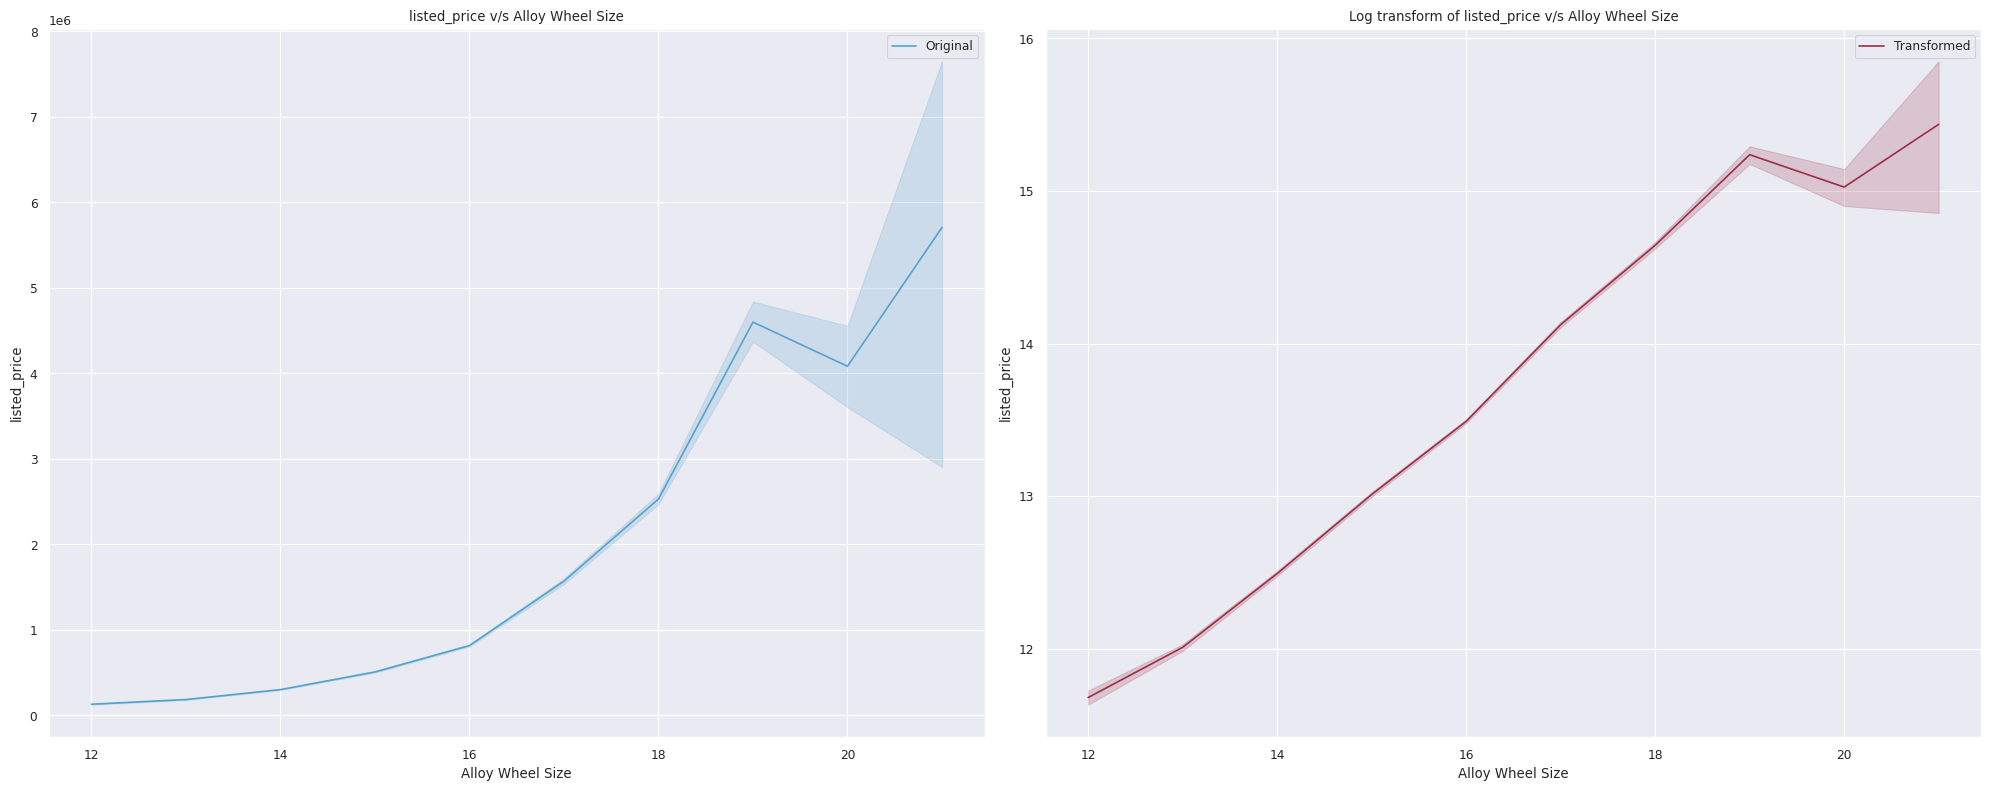

In [50]:
feature_dist_plots(df2[df2['Alloy Wheel Size'] != 7], col='Alloy Wheel Size', linewidth=0.8, sat=0.8, fontscale=1, rotation=45, transformation=np.log, sorted=True);
target_relation_plots(df2[df2['Alloy Wheel Size'] != 7], col='Alloy Wheel Size', fontscale=1, rotation=45, plot='reg', scatter_kws={'s':4}, order=1);
target_relation_plots(df2[df2['Alloy Wheel Size'] != 7], col='Alloy Wheel Size', fontscale=1, rotation=45, plot='line', sorted=True);

### Suggestions

Drop the 2 rows having wheel size of 7.

In [51]:
def AlloyWheelSize_transformation(df: pd.DataFrame):
    """
    Drop the rows having Alloy Wheel Size=7
    """
    df.drop(df[df['Alloy Wheel Size'] == 7].index, inplace=True)
    return

suggested_transformations.append(AlloyWheelSize_transformation)

---

### `Max Power Delivered`

In [52]:
analyze_data(df2, 'Max Power Delivered', descriptive=True);

Overview of column "Max Power Delivered"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        555         |
|   Distinct %   | 1.4697314760870717 |
| Missing Count  |        230         |
|   Missing %    | 0.6090779090090567 |
|      Mean      | 102.41332193861237 |
|    Minimum     |        10.8        |
|    Maximum     |       552.0        |
+----------------+--------------------+


Quantile stats for column "Max Power Delivered"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       |  10.8  |
|    5th Percentile   | 58.16  |
|  First Quartile, Q1 | 74.96  |
|        Median       |  88.5  |
|  Third Quartile, Q3 | 118.35 |
|   95th Percentile   | 184.0  |
|       Maximum       | 552.0  |
|        Range        | 541.2  |
| Interquartile Range | 43.39  |
+---------------------+--------+


Descriptive stats for column "Max Powe

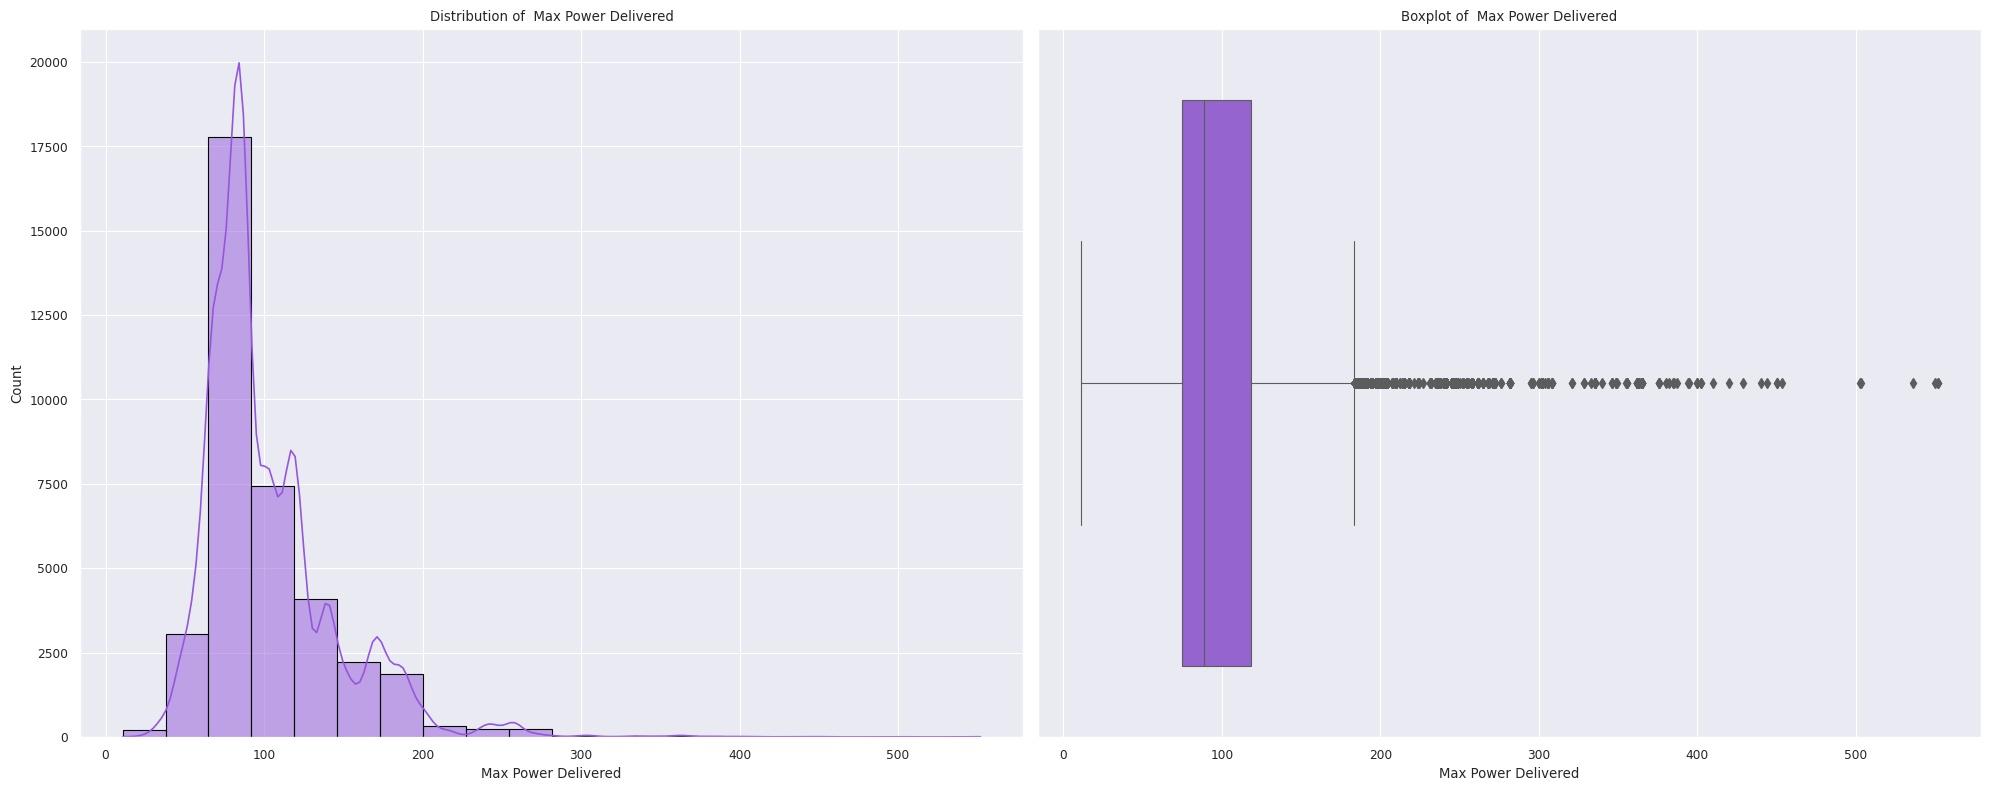

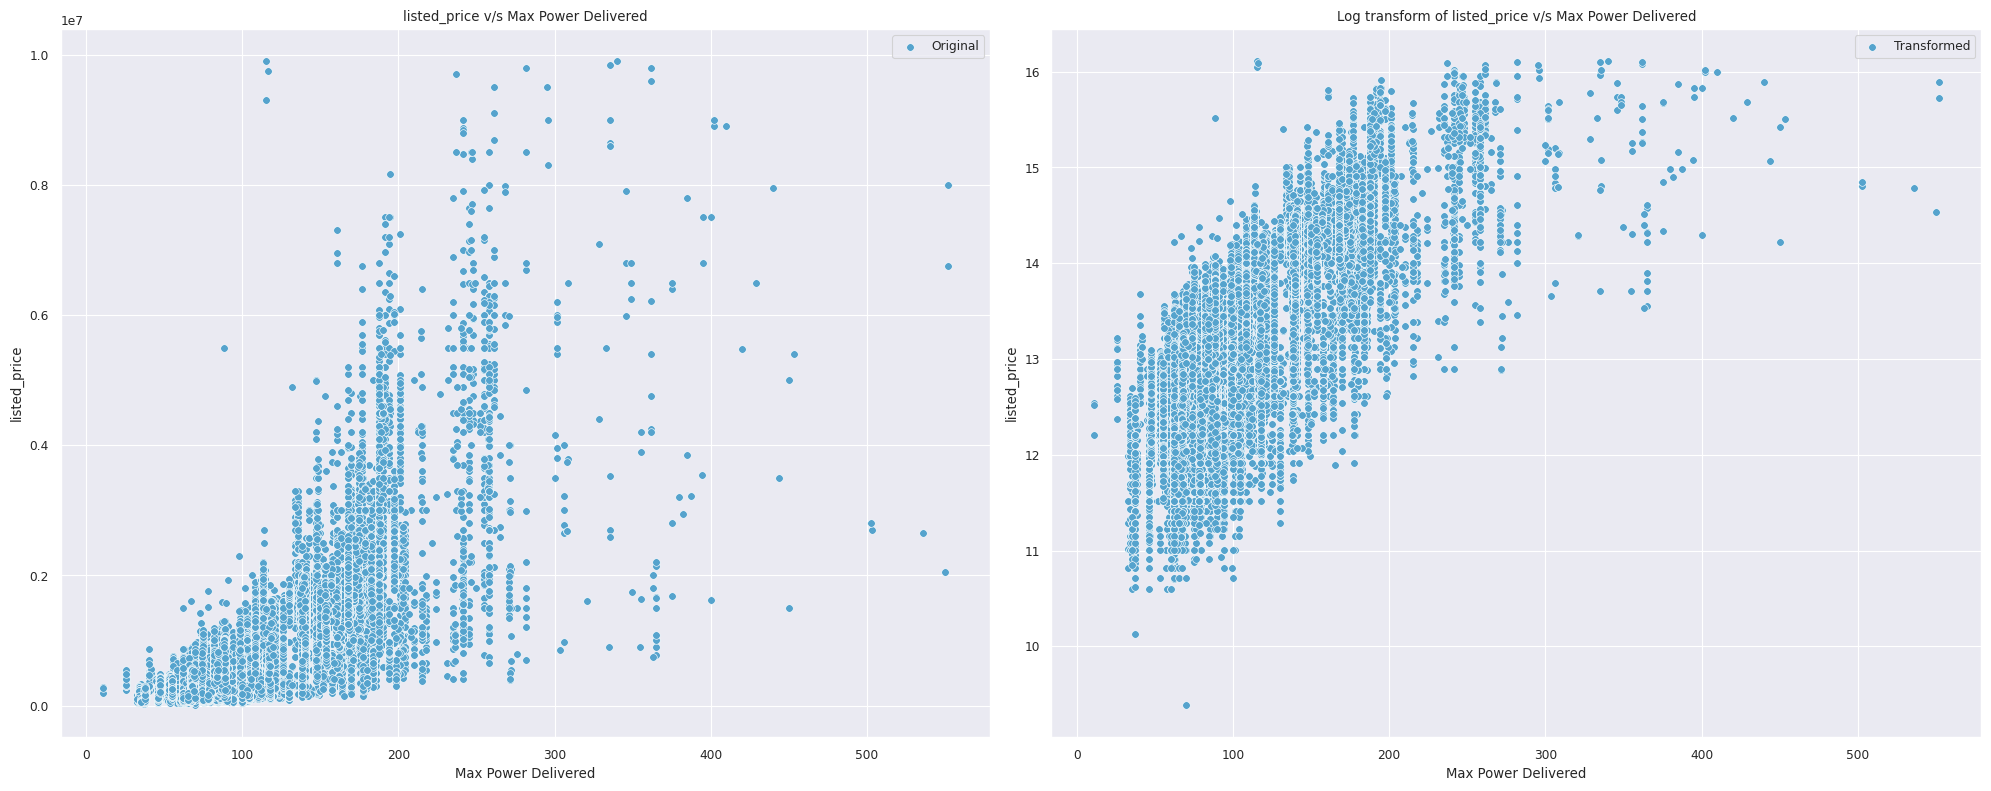

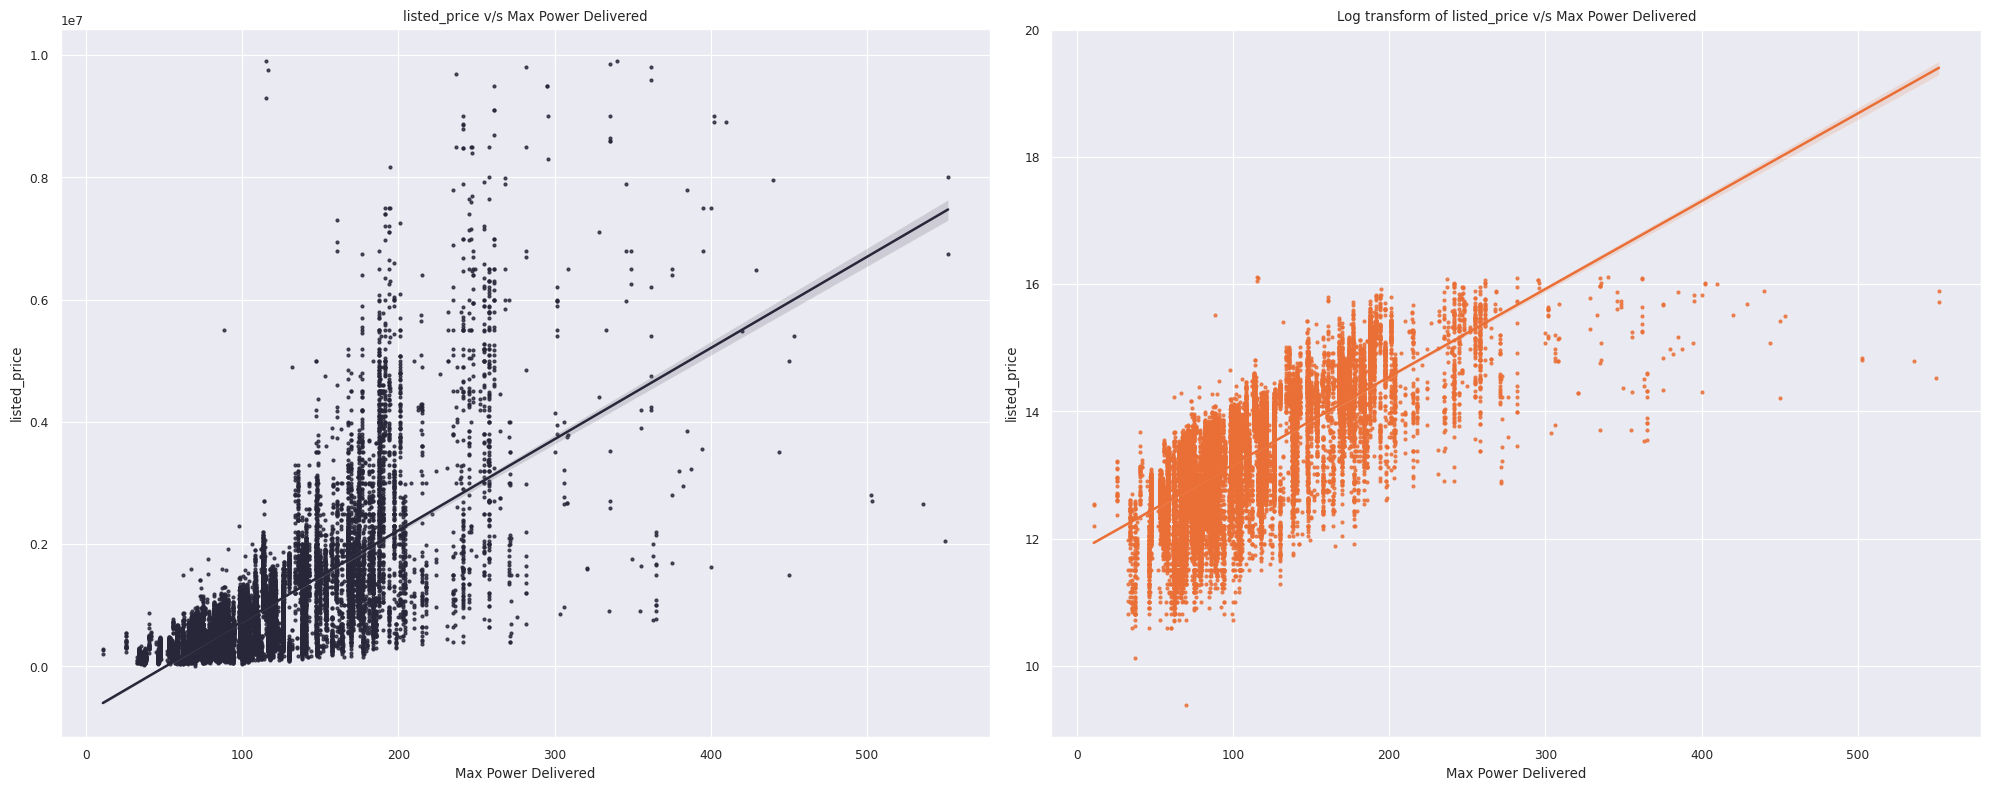

In [53]:
feature_dist_plots(df2, col='Max Power Delivered', linewidth=0.8, sat=0.8, fontscale=1, rotation=45, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Max Power Delivered', fontscale=1, rotation=45, plot='scatter', s=30);
target_relation_plots(df2, col='Max Power Delivered', fontscale=1, rotation=45, plot='reg', scatter_kws={'s':4}, order=1);

---

### `Max Power At`

In [54]:
analyze_data(df2, 'Max Power At');

Overview of column "Max Power At"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          46         |
|   Distinct %   | 0.12181558180181133 |
| Missing Count  |         2239        |
|   Missing %    |  5.929241035962078  |
|      Mean      |  5102.926836134336  |
|    Minimum     |        1620.0       |
|    Maximum     |        7000.0       |
+----------------+---------------------+


Quantile stats for column "Max Power At"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       | 1620.0 |
|    5th Percentile   | 3600.0 |
|  First Quartile, Q1 | 4000.0 |
|        Median       | 5500.0 |
|  Third Quartile, Q3 | 6000.0 |
|   95th Percentile   | 6400.0 |
|       Maximum       | 7000.0 |
|        Range        | 5380.0 |
| Interquartile Range | 2000.0 |
+---------------------+--------+


Extremums for column "Max Power At"
Maxim

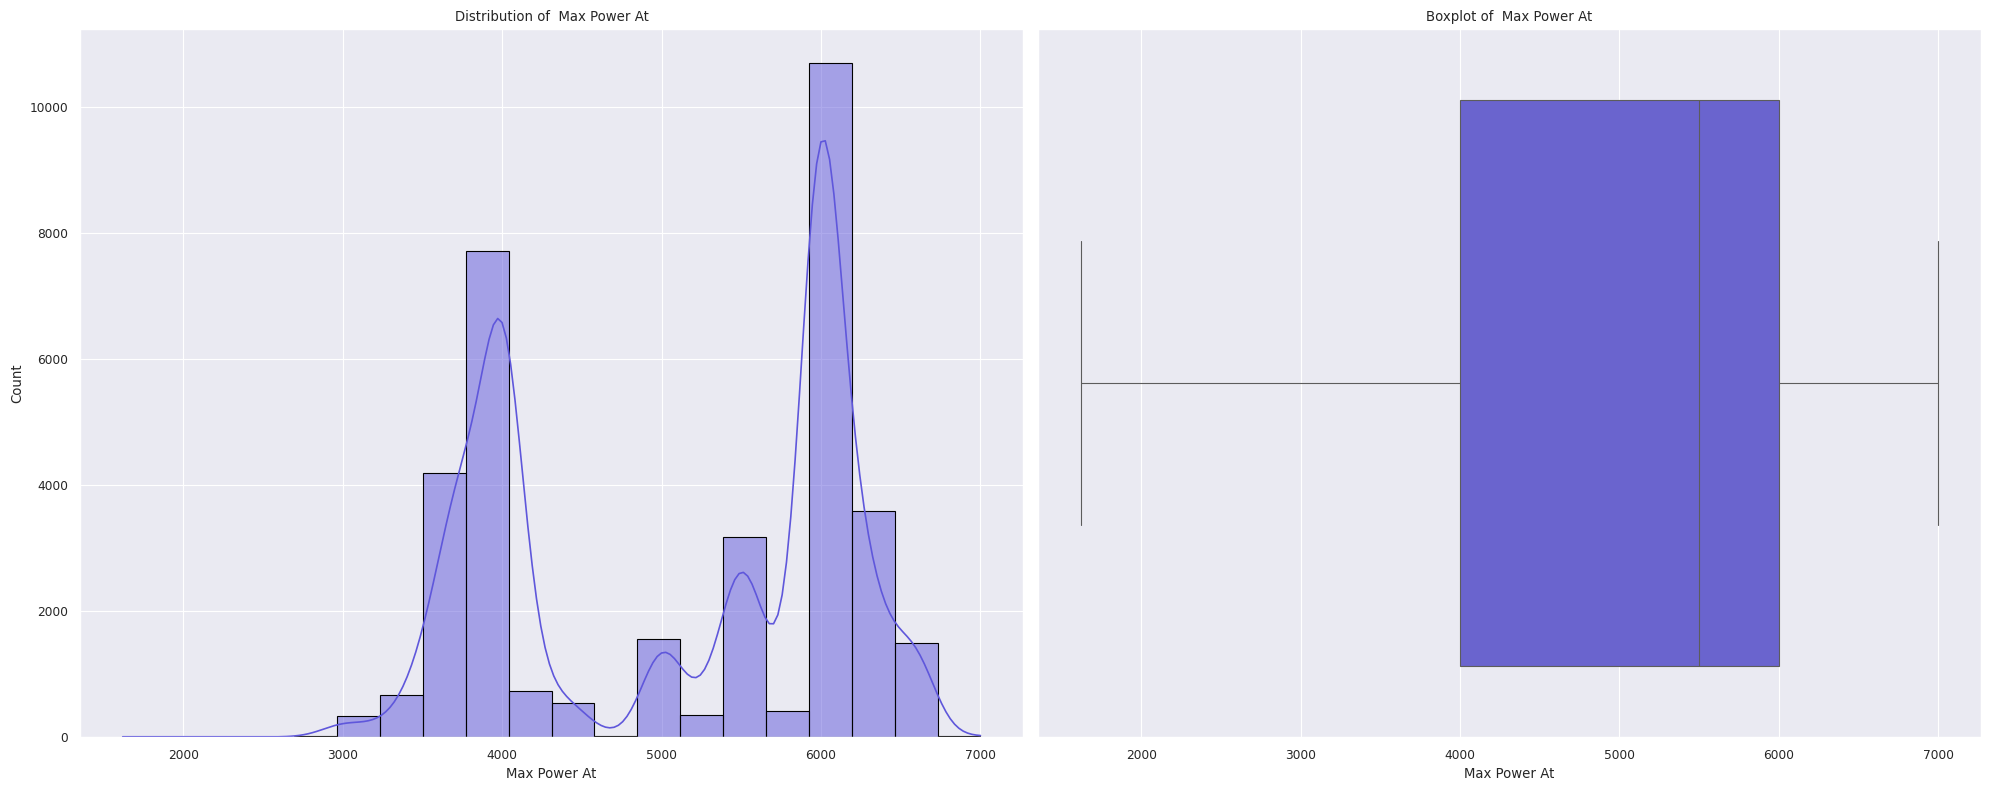

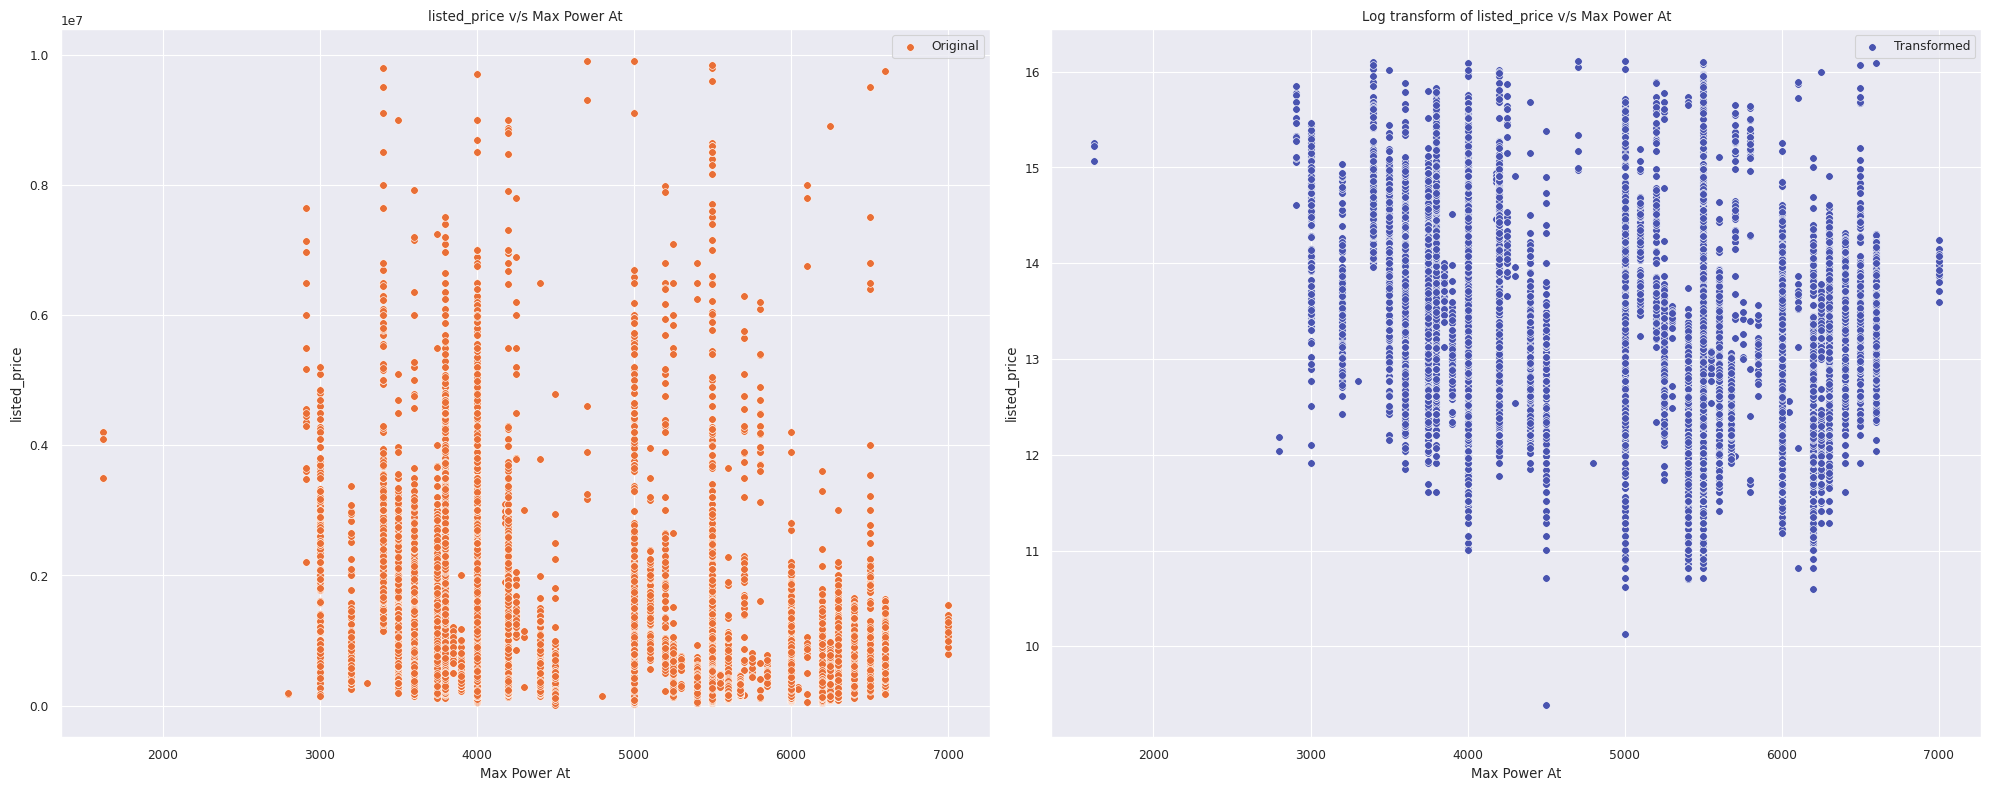

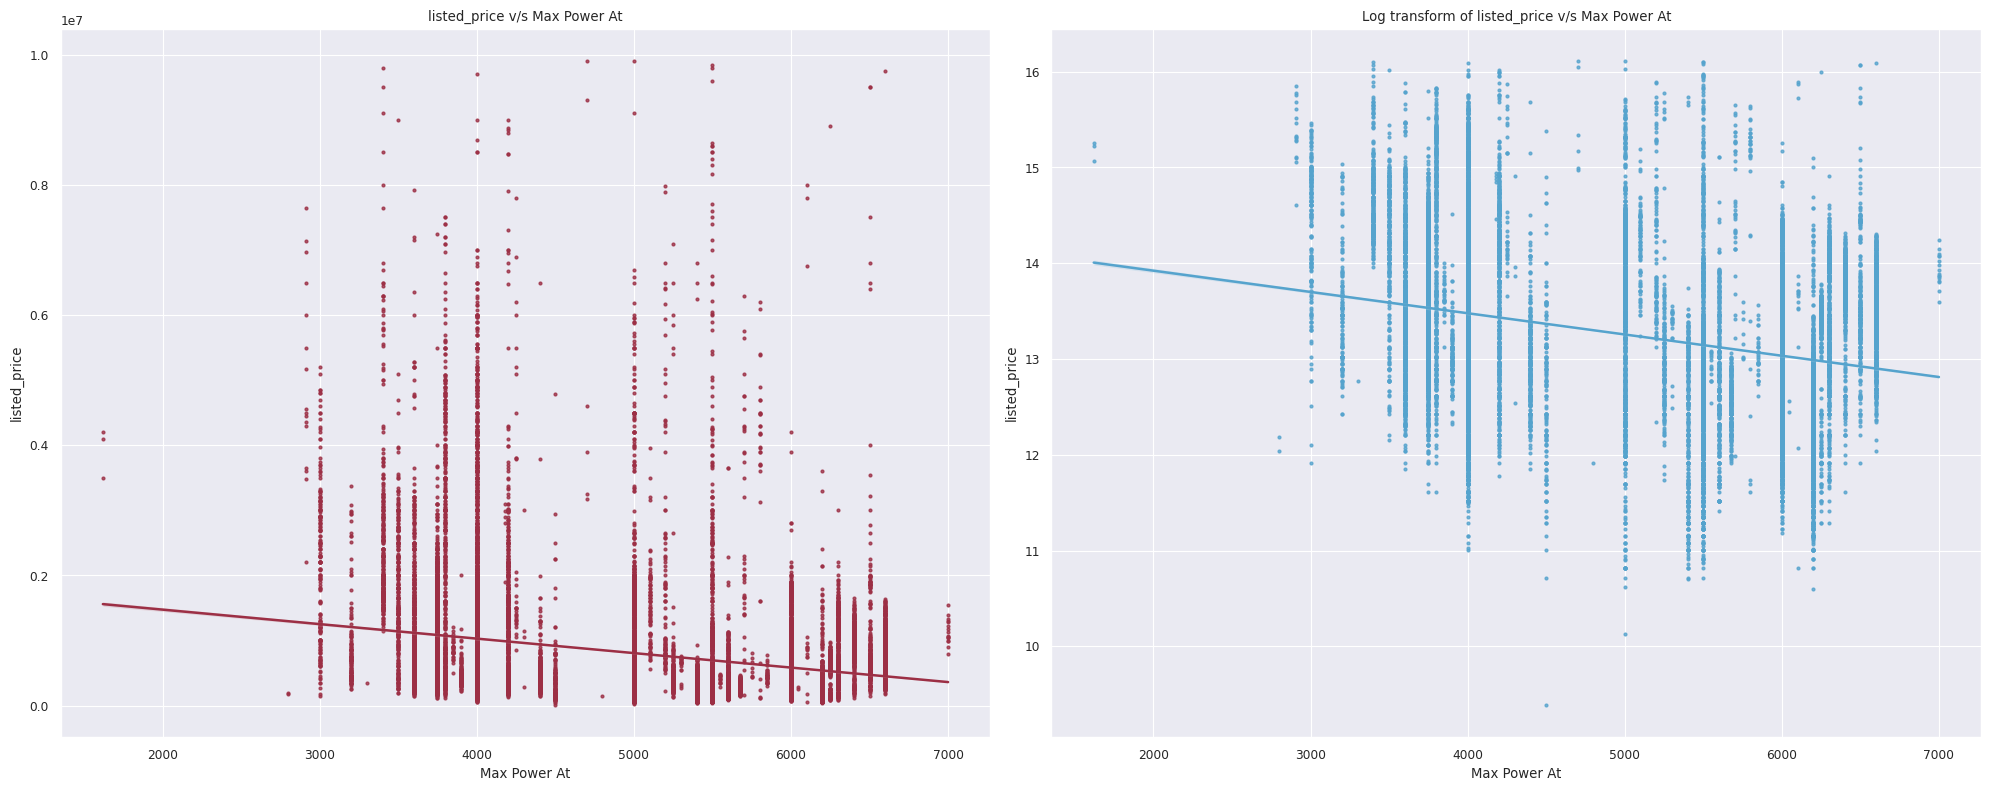

In [55]:
feature_dist_plots(df2, col='Max Power At', linewidth=0.8, sat=0.8, fontscale=1, rotation=45, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Max Power At', fontscale=1, rotation=45, plot='scatter', s=30);
target_relation_plots(df2, col='Max Power At', fontscale=1, rotation=45, plot='reg', scatter_kws={'s':4}, order=1);

---

### `Max Torque Delivered`

In [56]:
analyze_data(df2, 'Max Torque Delivered', descriptive=True);

Overview of column "Max Torque Delivered"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        328         |
|   Distinct %   | 0.8685980615433504 |
| Missing Count  |        230         |
|   Missing %    | 0.6090779090090567 |
|      Mean      | 178.23493632100607 |
|    Minimum     |        4.8         |
|    Maximum     |       850.0        |
+----------------+--------------------+


Quantile stats for column "Max Torque Delivered"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  4.8  |
|    5th Percentile   |  69.0 |
|  First Quartile, Q1 | 110.0 |
|        Median       | 145.0 |
|  Third Quartile, Q3 | 222.0 |
|   95th Percentile   | 400.0 |
|       Maximum       | 850.0 |
|        Range        | 845.2 |
| Interquartile Range | 112.0 |
+---------------------+-------+


Descriptive stats for column "Max Torque Delivere

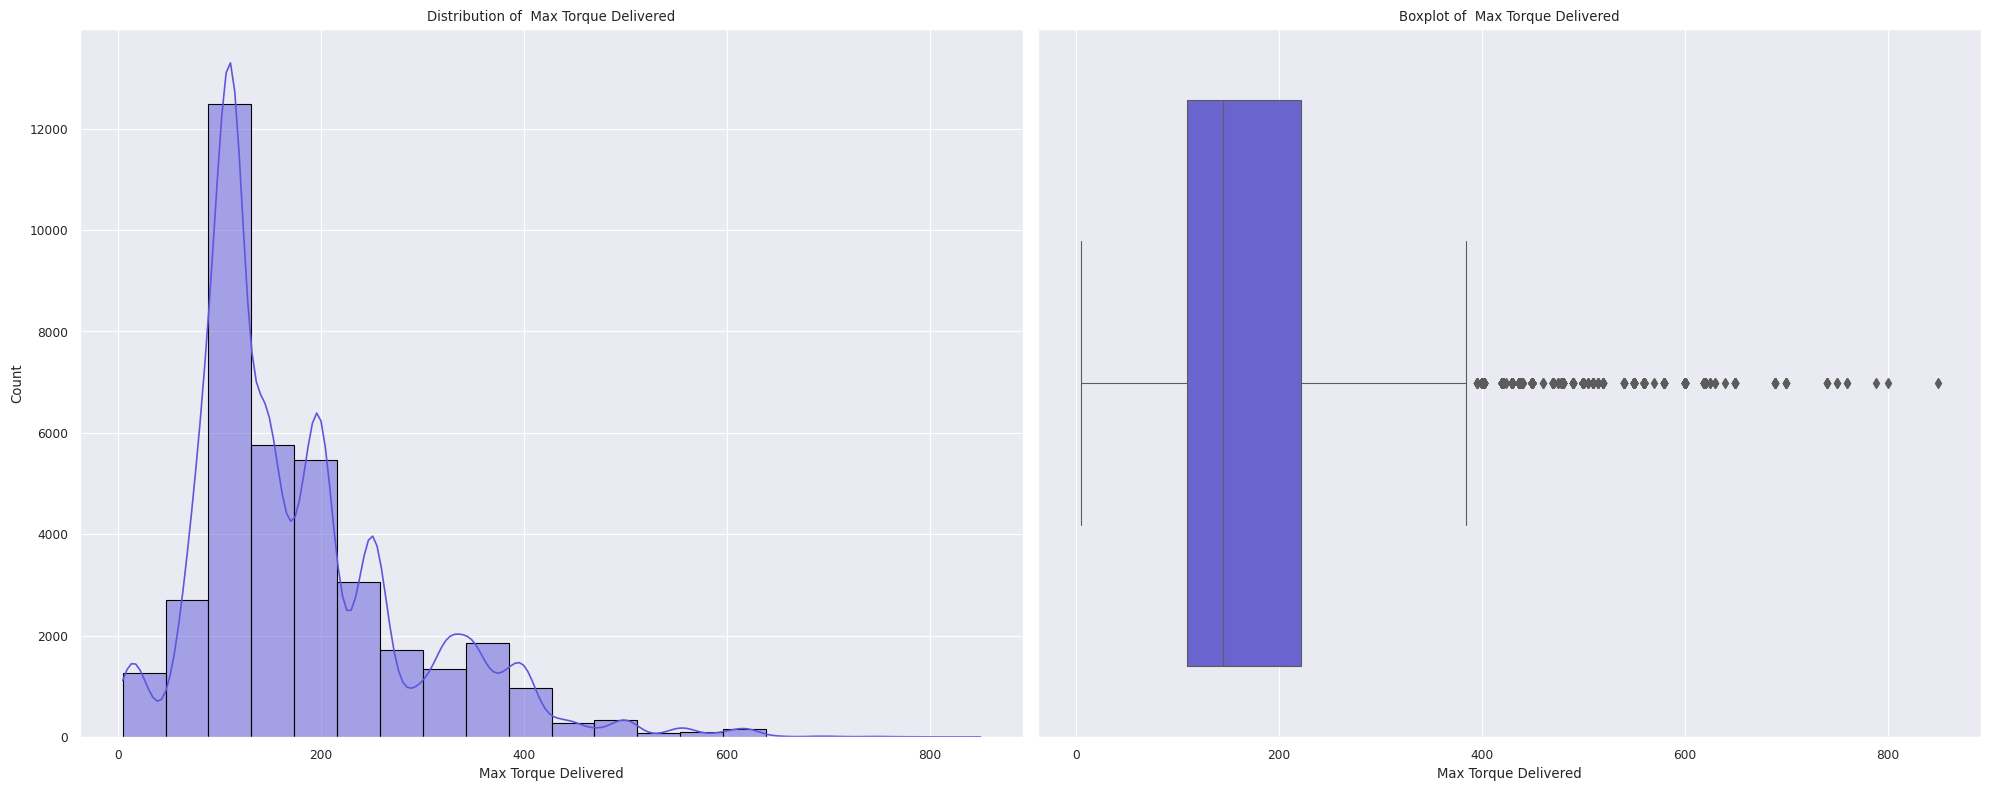

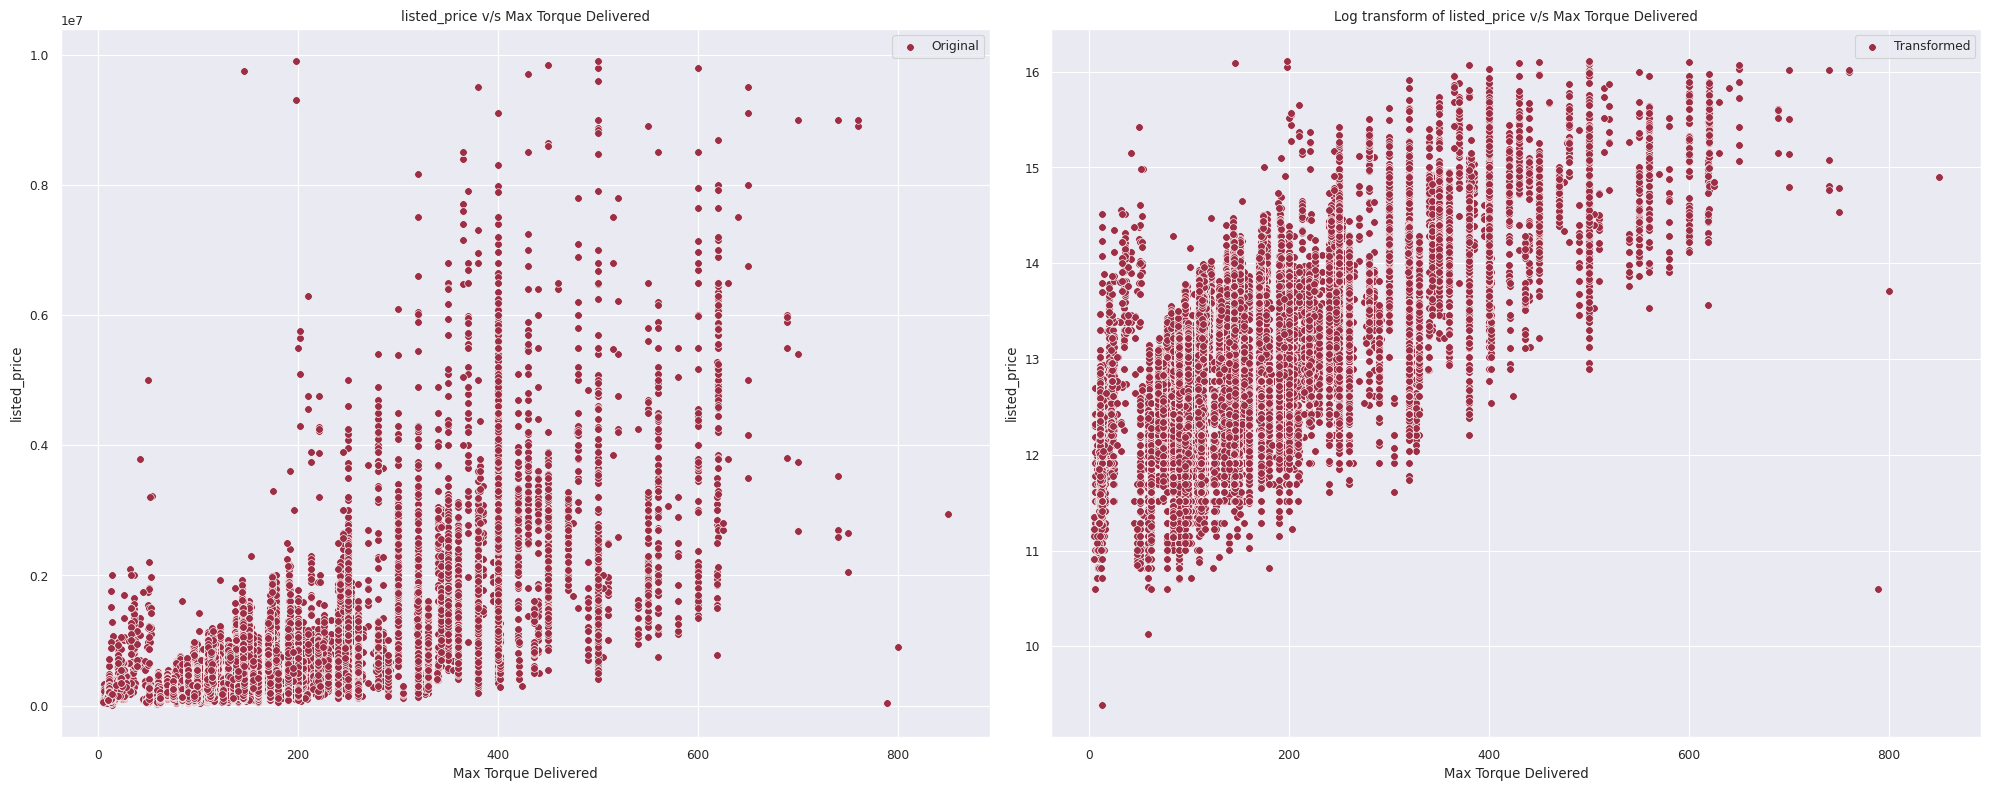

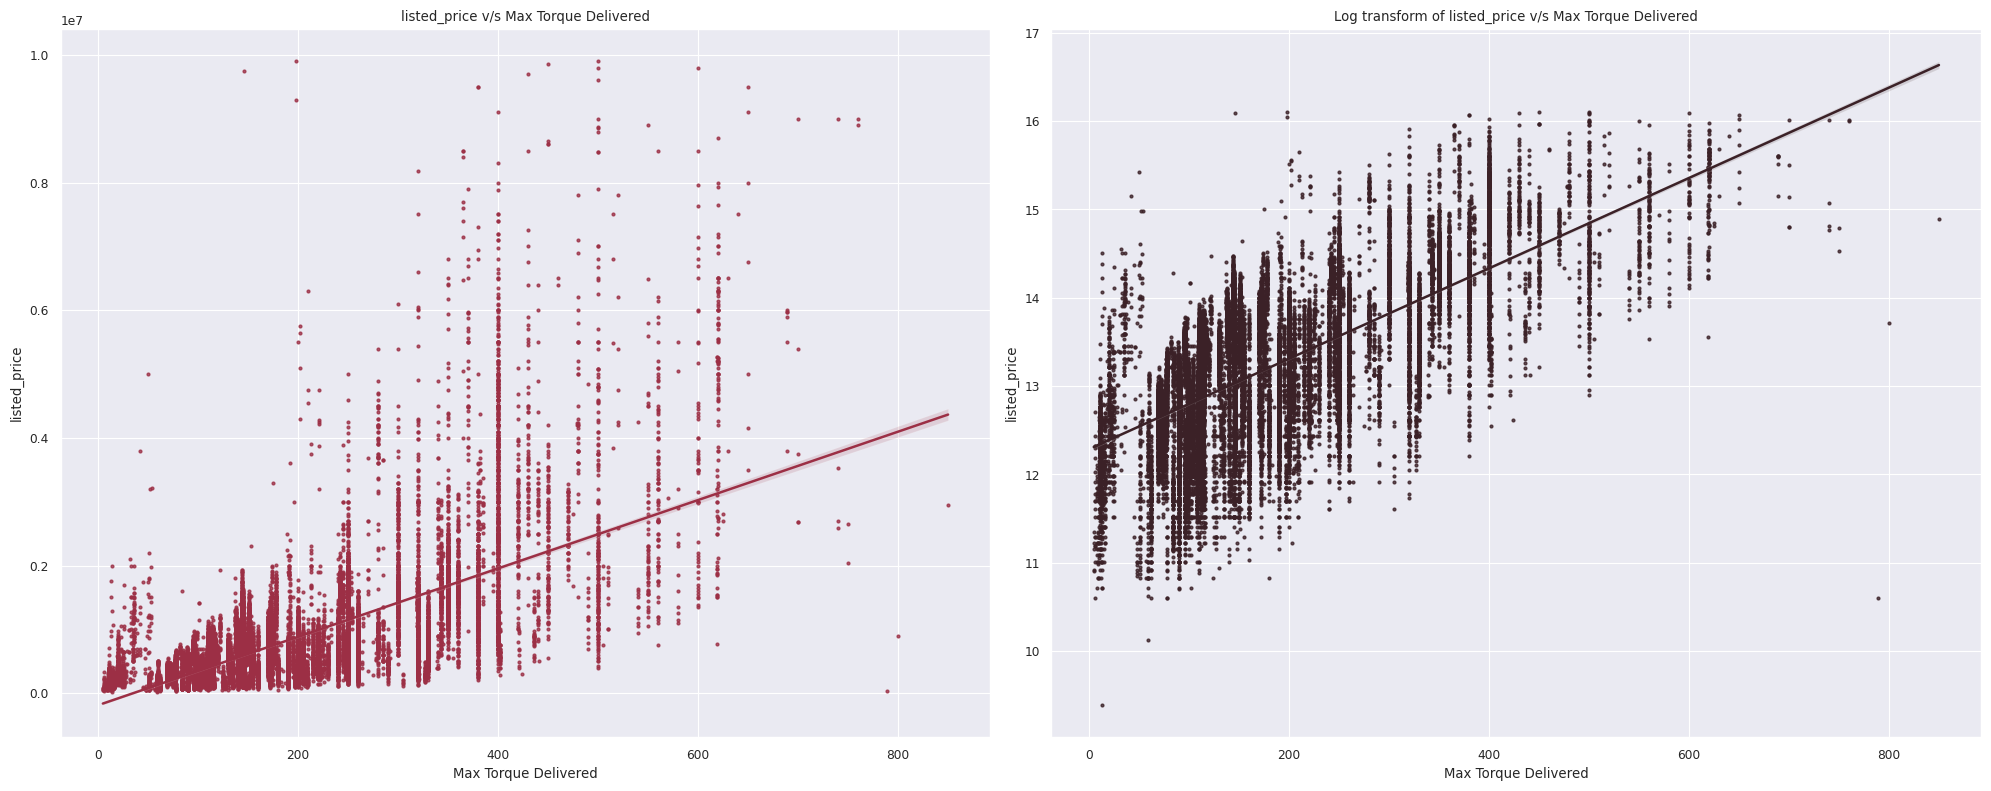

In [57]:
feature_dist_plots(df2, col='Max Torque Delivered', linewidth=0.8, sat=0.8, fontscale=1, rotation=45, transformation=np.log, sorted=True);
target_relation_plots(df2, col='Max Torque Delivered', fontscale=1, rotation=45, plot='scatter', s=30);
target_relation_plots(df2, col='Max Torque Delivered', fontscale=1, rotation=45, plot='reg', scatter_kws={'s':4}, order=1);

---

### `Max Torque At`

In [58]:
analyze_data(df2, 'Max Torque At');

Overview of column "Max Torque At"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        108         |
|   Distinct %   | 0.2860018007520788 |
| Missing Count  |        1975        |
|   Missing %    | 5.230125523012552  |
|      Mean      | 3162.1110179674183 |
|    Minimum     |       160.0        |
|    Maximum     |      21800.0       |
+----------------+--------------------+


Quantile stats for column "Max Torque At"
+---------------------+---------+
|      Statistic      |  Value  |
+---------------------+---------+
|       Minimum       |  160.0  |
|    5th Percentile   |  1750.0 |
|  First Quartile, Q1 |  2125.0 |
|        Median       |  3400.0 |
|  Third Quartile, Q3 |  4000.0 |
|   95th Percentile   |  4600.0 |
|       Maximum       | 21800.0 |
|        Range        | 21640.0 |
| Interquartile Range |  1875.0 |
+---------------------+---------+


Extremums for column "Max Torque At"


In [59]:
df2[df2['Max Torque At'] < 1000][['model', TARGET]]

model  listed_price
13610  force one    227168.000
13612  force one    414785.000
13613  force one    296923.000
17756  tata nano     58000.000
21670  tata nano     53250.000
26570  tata nano     65000.000
26571  tata nano     70000.000
29954  tata nano     75000.000
36358  tata nano     60000.000
36368  tata nano     51295.000

In [60]:
df2[df2['model'] == 'tata nano']['Max Torque At'].value_counts()

2250.000    40
4000.000    15
500.000      7
3000.000     5
3500.000     2
Name: Max Torque At, dtype: int64

Gas cars do not output their peak torque at below 1000 rpm. Since we know this and the cars which say their output it below 1000 are not really expensive cars is observed, it is most likely a mistake.

Also there is a car which has it's peak torque delivered at 21000 rpm. This is also bad data and should be ignored in our EDA.

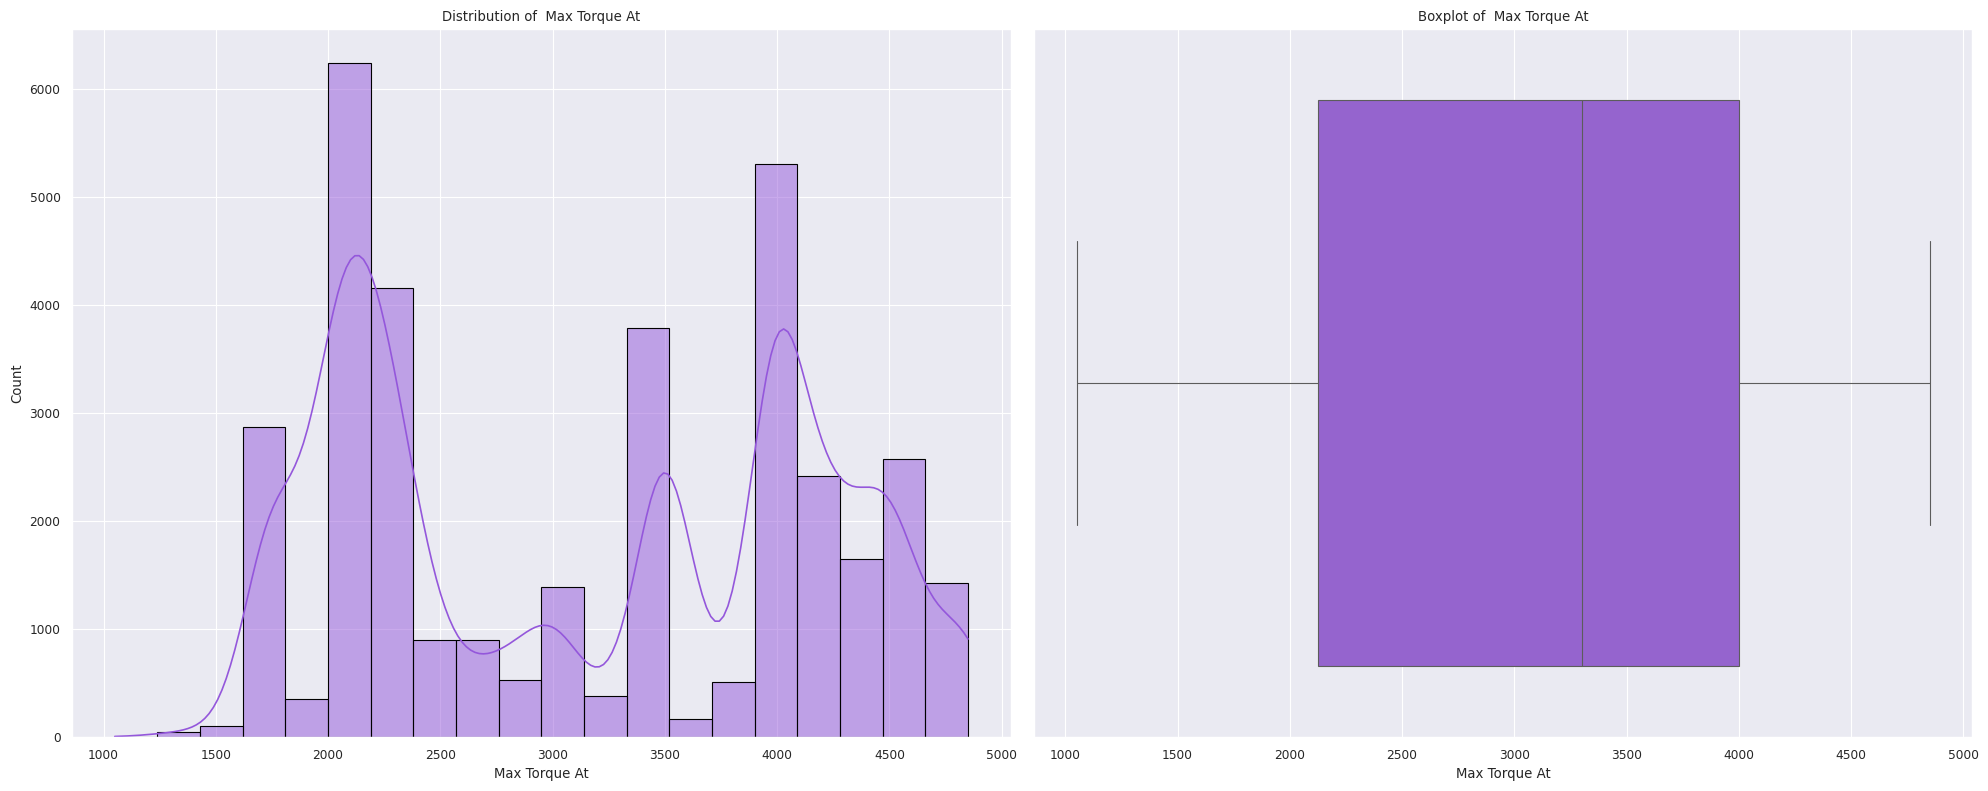

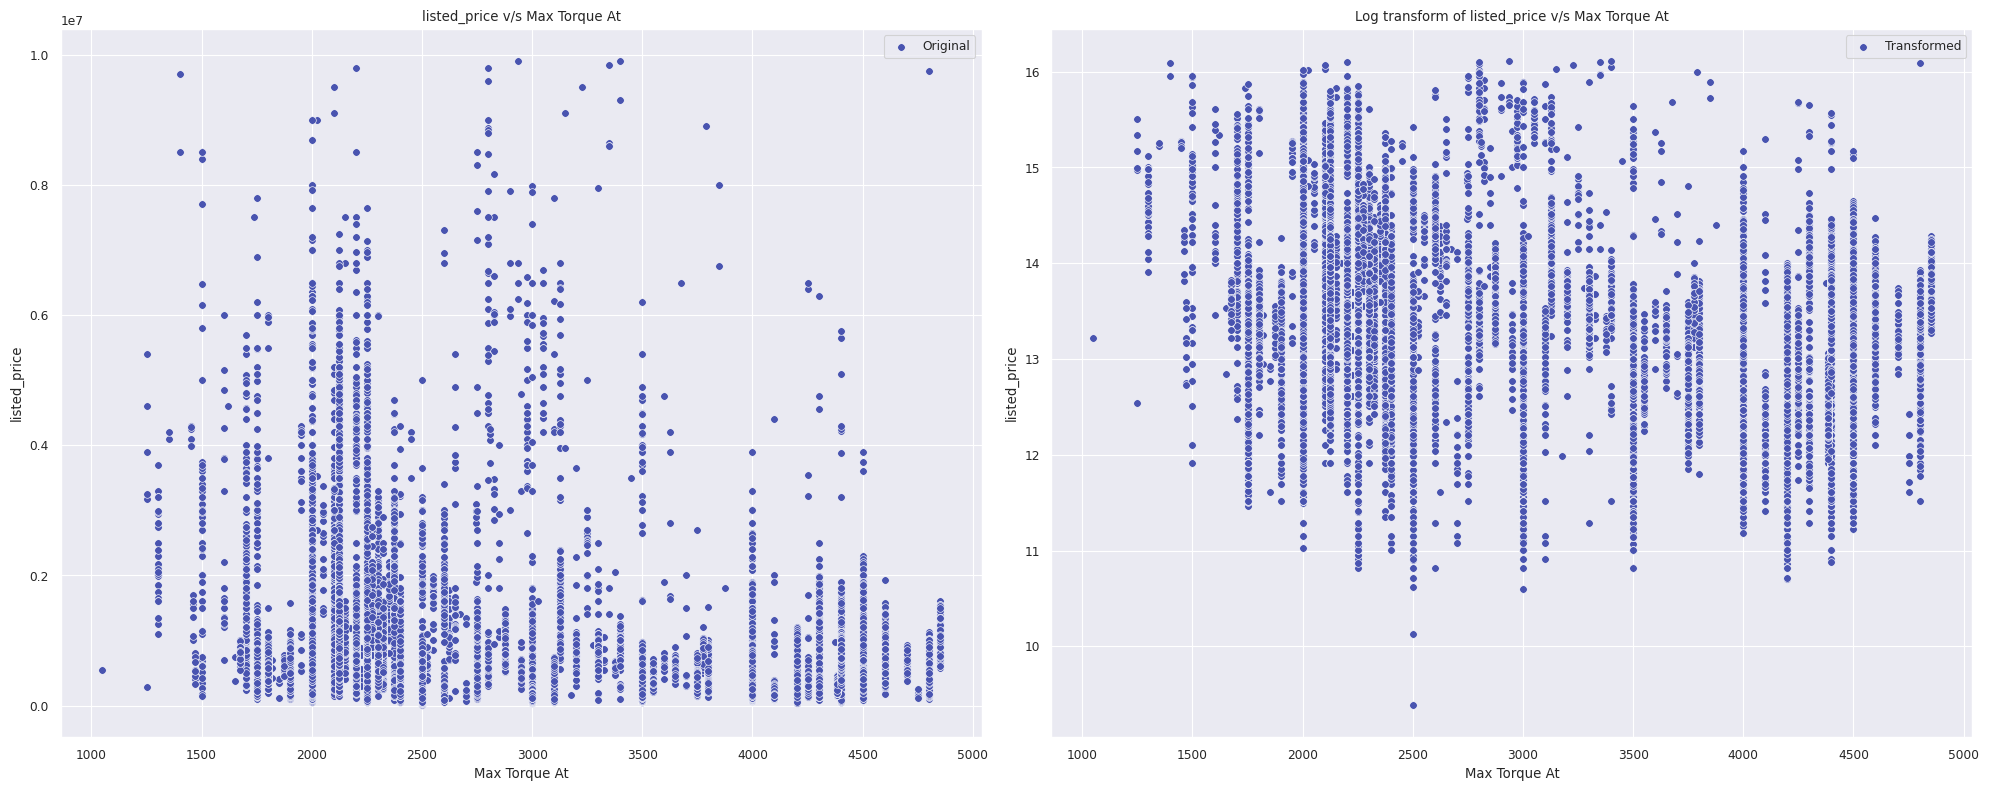

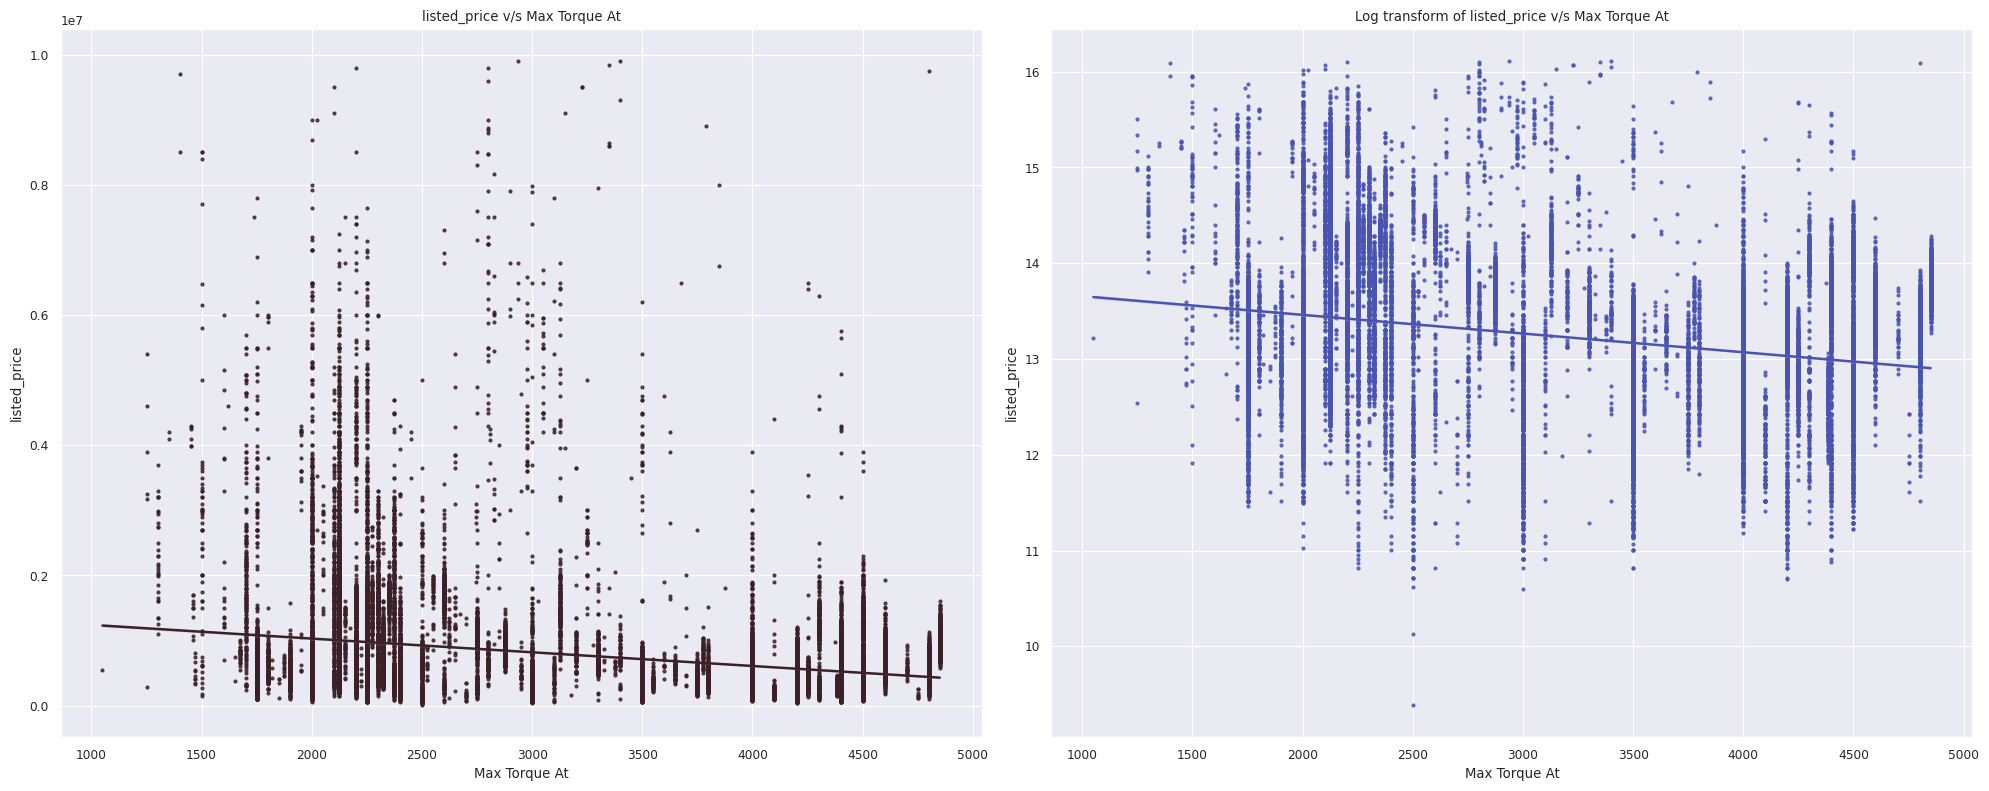

In [61]:
feature_dist_plots(df2[(df2['Max Torque At'] > 1000) & (df2['Max Torque At'] < 5000)], col='Max Torque At', linewidth=0.8, sat=0.8, fontscale=1, rotation=45, transformation=np.log, sorted=True);
target_relation_plots(df2[(df2['Max Torque At'] > 1000) & (df2['Max Torque At'] < 5000)], col='Max Torque At', fontscale=1, rotation=45, plot='scatter', s=30);
target_relation_plots(df2[(df2['Max Torque At'] > 1000) & (df2['Max Torque At'] < 5000)], col='Max Torque At', fontscale=1, rotation=45, plot='reg', scatter_kws={'s':4}, order=1);

In [62]:
def MaxTorqueAt_transformation(df: pd.DataFrame):
    """
    Mark all the rows having Max Torque At below 1000 and above 5000 as null
    """
    df.loc[(df['Max Torque At'] < 1000) | (df['Max Torque At'] > 5000), 'Max Torque At'] = np.NaN
    return

suggested_transformations.append(MaxTorqueAt_transformation)

---

### `Bore` and `Stroke`

In [63]:
analyze_data(df2, 'Bore');

Overview of column "Bore"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |         66         |
|   Distinct %   | 0.1747788782373815 |
| Missing Count  |       25133        |
|   Missing %    | 66.55632646575923  |
|      Mean      | 72.40687861271677  |
|    Minimum     |        2.85        |
|    Maximum     |       165.0        |
+----------------+--------------------+


Quantile stats for column "Bore"
+---------------------+-------------------+
|      Statistic      |       Value       |
+---------------------+-------------------+
|       Minimum       |        2.85       |
|    5th Percentile   |        68.5       |
|  First Quartile, Q1 |        69.6       |
|        Median       |        73.0       |
|  Third Quartile, Q3 |        76.5       |
|   95th Percentile   |        84.0       |
|       Maximum       |       165.0       |
|        Range        |       162.15      |
| Interquartile

In [64]:
analyze_data(df2, 'Stroke');

Overview of column "Stroke"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          21         |
|   Distinct %   | 0.05561146125734865 |
| Missing Count  |        37249        |
|   Missing %    |  98.64149144642762  |
|      Mean      |  83.49516569200779  |
|    Minimum     |         71.5        |
|    Maximum     |        104.9        |
+----------------+---------------------+


Quantile stats for column "Stroke"
+---------------------+--------------------+
|      Statistic      |       Value        |
+---------------------+--------------------+
|       Minimum       |        71.5        |
|    5th Percentile   |        76.4        |
|  First Quartile, Q1 |        82.5        |
|        Median       |        85.0        |
|  Third Quartile, Q3 |        85.8        |
|   95th Percentile   |        85.8        |
|       Maximum       |       104.9        |
|        Range        | 33.4000000

### Suggestions for the columns `Bore` and `Stroke`

**Drop both** the `Bore` and `Stroke` columns because over 60% and 90% data missing respectively.

In [65]:
# Drop the Bore and Stroke columns
def Bore_transformation(df: pd.DataFrame):
    """
    Drop the 'Bore' column
    """
    df.drop('Bore', axis=1, inplace=True)
    return

suggested_transformations.append(Bore_transformation)


def Stroke_transformation(df: pd.DataFrame):
    """
    Drop the 'Stroke' column
    """
    df.drop('Stroke', axis=1, inplace=True)
    return

suggested_transformations.append(Stroke_transformation)

---

## Conclusion

We have successfully completed the data cleaning and transformation part of the project. We have also created a list of suggested transformations which can be used to transform the data in the future.

One last step before we could move on to model building - Handling the missing values and make the custom preprocessing pipeline.

Let's take a look at the transformations suggested in this notebook

In [66]:
for trans_function in suggested_transformations:
    print(trans_function.__doc__)


    Replace the Seats with null if the value is zero
    

    Replace the Turning Radius with null if the value is greater and 15
    

    Replace all rows having Doors=5 with Doors=4
    

    Drop the 'model_type_new' column
    

    Drop the 'exterior_color_new' column
    

    Drop the 'Ground Clearance Unladen' column
    

    Drop the 'Compression Ratio' column
    

    Drop the rows having Alloy Wheel Size=7
    

    Mark all the rows having Max Torque At below 1000 and above 5000 as null
    

    Drop the 'Bore' column
    

    Drop the 'Stroke' column
    


#### We also the Doors transformation which should be a part of the model pipeline.